In [1]:
# RBF / Bayes Net experiment
# train a model on MNIST
# get adv examples from FGSM attack
# transfer examples

In [2]:
# 9.0 training an Bayes net to make no good pred on random noise
# original notebook: https://github.com/paraschopra/bayesian-neural-network-mnist/blob/master/bnn.ipynb

In [3]:
%load_ext autoreload
%autoreload 2
# Disable jedi autocompleter
%config Completer.use_jedi = False

In [4]:
# !pip3 install --user --upgrade --force-reinstall torch

In [5]:
# !pip3 install --user torchvision

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
torch.__version__

'1.10.1+cu102'

In [8]:
# import matplotlib as mpl
# # set this 'backend' when using jupyter; do this before importing pyplot
# mpl.use('nbagg')
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

In [10]:
plt.rcParams['figure.figsize'] = [8, 8]

In [11]:
import numpy as np
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
# from scipy.misc import imread # deprecated
from imageio import imread

In [12]:
# check gpus
!gpustat

countdown                      Fri May 20 17:37:41 2022  465.19.01
[0] NVIDIA GeForce RTX 2080 Ti | 78'C,  15 % |  8738 / 11019 MB | enis(7799M) enis(935M)
[1] NVIDIA GeForce RTX 2080 Ti | 87'C,  18 % |  7941 / 11018 MB | enis(7799M) root(137M)


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# manually set cuda device
torch.cuda.set_device(0)
device = 'cpu'
print(device)

cpu


In [14]:
# !pip3 install --user --ignore-installed torchaudio

In [15]:
# custom library imports
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [16]:
# class NN(nn.Module):
    
#     def __init__(self, input_size, hidden_size, output_size):
#         super(NN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
        
#     def forward(self, x):
#         output = self.fc1(x)
#         output = F.relu(output)
#         output = self.out(output)
#         return output

In [17]:
# get data 
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=10000, 
                                                                                   batch_size_for_val=10000)

In [18]:
# change names to match original notebook
train_loader = mnist_train_loader
test_loader = mnist_val_loader

In [19]:
train_loader.dataset.tensors[0].size()

torch.Size([50000, 28, 28])

In [20]:
test_loader.dataset.tensors[0].size()

torch.Size([10000, 28, 28])

In [21]:
# net = NN(28*28, 1024, 10) # not used, from the  source notebook

In [22]:
hidden_layer_sizes = [64,64]
drop_p = 0.01

# net = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p)

In [23]:
# reload from pretrained
classic_model_path = "../Experiments/sample_models/sample_classic_full.pth"
net = torch.load(classic_model_path, map_location=torch.device(device))

In [24]:
net.train()

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=64, out_features=10, bias=True)
)

In [25]:
# !pip3 install --user --no-deps pyro-ppl==1.4

In [26]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [27]:
log_softmax = nn.LogSoftmax(dim=1)

In [28]:
# def model(x_data, y_data):
    
#     fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
#     fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
#     outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
#     outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
#     priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
#     # lift module parameters to random variables sampled from the priors
#     lifted_module = pyro.random_module("module", net, priors)
#     # sample a regressor (which also samples w and b)
#     lifted_reg_model = lifted_module()
    
#     lhat = log_softmax(lifted_reg_model(x_data))
    

#     pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [29]:
# define own model based on prev experiments
def model(x_data, y_data):
    
    # input batchnorm layer 
    ibw_prior = Normal(loc=torch.zeros_like(net.ib.weight), scale=torch.ones_like(net.ib.weight))
    ibb_prior = Normal(loc=torch.zeros_like(net.ib.bias), scale=torch.ones_like(net.ib.bias))
    
    # first linear layer
    hl1w_prior = Normal(loc=torch.zeros_like(net.hidden_layers[1].weight), scale=torch.ones_like(net.hidden_layers[1].weight))
    hl1b_prior = Normal(loc=torch.zeros_like(net.hidden_layers[1].bias), scale=torch.ones_like(net.hidden_layers[1].bias))
    # first batchnorm
    hl2w_prior = Normal(loc=torch.zeros_like(net.hidden_layers[2].weight), scale=torch.ones_like(net.hidden_layers[2].weight))
    hl2b_prior = Normal(loc=torch.zeros_like(net.hidden_layers[2].bias), scale=torch.ones_like(net.hidden_layers[2].bias))
    # 2nd linear layer
    hl4w_prior = Normal(loc=torch.zeros_like(net.hidden_layers[4].weight), scale=torch.ones_like(net.hidden_layers[4].weight))
    hl4b_prior = Normal(loc=torch.zeros_like(net.hidden_layers[4].bias), scale=torch.ones_like(net.hidden_layers[4].bias))
    # 2nd batchnorm
    hl5w_prior = Normal(loc=torch.zeros_like(net.hidden_layers[5].weight), scale=torch.ones_like(net.hidden_layers[5].weight))
    hl5b_prior = Normal(loc=torch.zeros_like(net.hidden_layers[5].bias), scale=torch.ones_like(net.hidden_layers[5].bias))
        
    # final layer  
    flw_prior = Normal(loc=torch.zeros_like(net.fl.weight), scale=torch.ones_like(net.fl.weight))
    flb_prior = Normal(loc=torch.zeros_like(net.fl.bias), scale=torch.ones_like(net.fl.bias))
    
    priors = {'ib.weight':ibw_prior,
              'ib.bias':ibb_prior,
              'hl1.weight':hl1w_prior,
              'hl1.bias':hl1b_prior,
              'hl2.weight':hl2w_prior,
              'hl2.bias':hl2b_prior,
              'hl4.weight':hl4w_prior,
              'hl4.bias':hl4b_prior,
              'hl5.weight':hl5w_prior,
              'hl5.bias':hl5b_prior,
              'fl.weight':flw_prior,
              'fl.bias':flb_prior,
             }
    
     # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [30]:
# define own model based on prev experiments
def model(x_data, y_data):
    
    # input batchnorm layer 
    ibw_prior = Normal(loc=net.ib.weight, scale=torch.ones_like(net.ib.weight))
    ibb_prior = Normal(loc=net.ib.bias, scale=torch.ones_like(net.ib.bias))
    
    # first linear layer
    hl1w_prior = Normal(loc=net.hidden_layers[1].weight, scale=torch.ones_like(net.hidden_layers[1].weight))
    hl1b_prior = Normal(loc=net.hidden_layers[1].bias, scale=torch.ones_like(net.hidden_layers[1].bias))
    # first batchnorm
    hl2w_prior = Normal(loc=net.hidden_layers[2].weight, scale=torch.ones_like(net.hidden_layers[2].weight))
    hl2b_prior = Normal(loc=net.hidden_layers[2].bias, scale=torch.ones_like(net.hidden_layers[2].bias))
    # 2nd linear layer
    hl4w_prior = Normal(loc=net.hidden_layers[4].weight, scale=torch.ones_like(net.hidden_layers[4].weight))
    hl4b_prior = Normal(loc=net.hidden_layers[4].bias, scale=torch.ones_like(net.hidden_layers[4].bias))
    # 2nd batchnorm
    hl5w_prior = Normal(loc=net.hidden_layers[5].weight, scale=torch.ones_like(net.hidden_layers[5].weight))
    hl5b_prior = Normal(loc=net.hidden_layers[5].bias, scale=torch.ones_like(net.hidden_layers[5].bias))
        
    # final layer  
    flw_prior = Normal(loc=net.fl.weight, scale=torch.ones_like(net.fl.weight))
    flb_prior = Normal(loc=net.fl.bias, scale=torch.ones_like(net.fl.bias))
    
    priors = {'ib.weight':ibw_prior,
              'ib.bias':ibb_prior,
              'hl1.weight':hl1w_prior,
              'hl1.bias':hl1b_prior,
              'hl2.weight':hl2w_prior,
              'hl2.bias':hl2b_prior,
              'hl4.weight':hl4w_prior,
              'hl4.bias':hl4b_prior,
              'hl5.weight':hl5w_prior,
              'hl5.bias':hl5b_prior,
              'fl.weight':flw_prior,
              'fl.bias':flb_prior,
             }
    
     # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [31]:
softplus = torch.nn.Softplus()

In [32]:
# def guide(x_data, y_data):
    
#     # First layer weight distribution priors
#     fc1w_mu = torch.randn_like(net.fc1.weight)
#     fc1w_sigma = torch.randn_like(net.fc1.weight)
#     fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
#     fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
#     fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)

#     # First layer bias distribution priors
#     fc1b_mu = torch.randn_like(net.fc1.bias)
#     fc1b_sigma = torch.randn_like(net.fc1.bias)
#     fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
#     fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
#     fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)

#     # Output layer weight distribution priors
#     outw_mu = torch.randn_like(net.out.weight)
#     outw_sigma = torch.randn_like(net.out.weight)
#     outw_mu_param = pyro.param("outw_mu", outw_mu)
#     outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
#     outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
#     # Output layer bias distribution priors
#     outb_mu = torch.randn_like(net.out.bias)
#     outb_sigma = torch.randn_like(net.out.bias)
#     outb_mu_param = pyro.param("outb_mu", outb_mu)
#     outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
#     outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
#     priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
#     lifted_module = pyro.random_module("module", net, priors)
    
#     return lifted_module()

In [33]:
# define own guide based on prev experiments
def guide(x_data, y_data):
    
    # input batchnorm layer weight distribution priors
    ibw_mu = torch.randn_like(net.ib.weight)
    ibw_sigma = torch.randn_like(net.ib.weight)
    ibw_mu_param = pyro.param("ibw_mu", ibw_mu)
    ibw_sigma_param = softplus(pyro.param("ibw_sigma", ibw_sigma))
    ibw_prior = Normal(loc=ibw_mu_param, scale=ibw_sigma_param)
    # input batchnorm layer bias distribution priors
    ibb_mu = torch.randn_like(net.ib.bias)
    ibb_sigma = torch.randn_like(net.ib.bias)
    ibb_mu_param = pyro.param("ibb_mu", ibb_mu)
    ibb_sigma_param = softplus(pyro.param("ibb_sigma", ibb_sigma))
    ibb_prior = Normal(loc=ibb_mu_param, scale=ibb_sigma_param)
    # first linear layer weights distri prior
    hl1w_mu = torch.randn_like(net.hidden_layers[1].weight)
    hl1w_sigma = torch.randn_like(net.hidden_layers[1].weight)
    hl1w_mu_param = pyro.param("hl1w_mu", hl1w_mu)
    hl1w_sigma_param = softplus(pyro.param("hl1w_sigma", hl1w_sigma))
    hl1w_prior = Normal(loc=hl1w_mu_param, scale=hl1w_sigma_param)
    # first linear layer bias
    hl1b_mu = torch.randn_like(net.hidden_layers[1].bias)
    hl1b_sigma = torch.randn_like(net.hidden_layers[1].bias)
    hl1b_mu_param = pyro.param("hl1b_mu", hl1b_mu)
    hl1b_sigma_param = softplus(pyro.param("hl1b_sigma", hl1b_sigma))
    hl1b_prior = Normal(loc=hl1b_mu_param, scale=hl1b_sigma_param)
    # first batchnorm weights
    hl2w_mu = torch.randn_like(net.hidden_layers[2].weight)
    hl2w_sigma = torch.randn_like(net.hidden_layers[2].weight)
    hl2w_mu_param = pyro.param("hl2w_mu", hl2w_mu)
    hl2w_sigma_param = softplus(pyro.param("hl2w_sigma", hl2w_sigma))
    hl2w_prior = Normal(loc=hl2w_mu_param, scale=hl2w_sigma_param)
    # first batchnorm bias
    hl2b_mu = torch.randn_like(net.hidden_layers[2].bias)
    hl2b_sigma = torch.randn_like(net.hidden_layers[2].bias)
    hl2b_mu_param = pyro.param("hl2b_mu", hl2b_mu)
    hl2b_sigma_param = softplus(pyro.param("hl2b_sigma", hl2b_sigma))
    hl2b_prior = Normal(loc=hl2b_mu_param, scale=hl2b_sigma_param)
    # 2nd linear layer weights
    hl4w_mu = torch.randn_like(net.hidden_layers[4].weight)
    hl4w_sigma = torch.randn_like(net.hidden_layers[4].weight)
    hl4w_mu_param = pyro.param("hl4w_mu", hl4w_mu)
    hl4w_sigma_param = softplus(pyro.param("hl4w_sigma", hl4w_sigma))
    hl4w_prior = Normal(loc=hl4w_mu_param, scale=hl4w_sigma_param)
    # 2nd linear layer bias
    hl4b_mu = torch.randn_like(net.hidden_layers[4].bias)
    hl4b_sigma = torch.randn_like(net.hidden_layers[4].bias)
    hl4b_mu_param = pyro.param("hl4b_mu", hl4b_mu)
    hl4b_sigma_param = softplus(pyro.param("hl4b_sigma", hl4b_sigma))
    hl4b_prior = Normal(loc=hl4b_mu_param, scale=hl4b_sigma_param)
    # 2nd batchnorm weights
    hl5w_mu = torch.randn_like(net.hidden_layers[5].weight)
    hl5w_sigma = torch.randn_like(net.hidden_layers[5].weight)
    hl5w_mu_param = pyro.param("hl5w_mu", hl5w_mu)
    hl5w_sigma_param = softplus(pyro.param("hl5w_sigma", hl5w_sigma))
    hl5w_prior = Normal(loc=hl5w_mu_param, scale=hl5w_sigma_param)
    # 2nd batchnorm bias
    hl5b_mu = torch.randn_like(net.hidden_layers[5].bias)
    hl5b_sigma = torch.randn_like(net.hidden_layers[5].bias)
    hl5b_mu_param = pyro.param("hl5b_mu", hl5b_mu)
    hl5b_sigma_param = softplus(pyro.param("hl5b_sigma", hl5b_sigma))
    hl5b_prior = Normal(loc=hl5b_mu_param, scale=hl5b_sigma_param)
    # output layer
    # weights
    flw_mu = torch.randn_like(net.fl.weight)
    flw_sigma = torch.randn_like(net.fl.weight)
    flw_mu_param = pyro.param("flw_mu", flw_mu)
    flw_sigma_param = softplus(pyro.param("flw_sigma", flw_sigma))
    flw_prior = Normal(loc=flw_mu_param, scale=flw_sigma_param)
    # bias
    flb_mu = torch.randn_like(net.fl.bias)
    flb_sigma = torch.randn_like(net.fl.bias)
    flb_mu_param = pyro.param("flb_mu", flb_mu)
    flb_sigma_param = softplus(pyro.param("flb_sigma", flb_sigma))
    flb_prior = Normal(loc=flb_mu_param, scale=flb_sigma_param)
    
    priors = {'ib.weight':ibw_prior,
              'ib.bias':ibb_prior,
              'hl1.weight':hl1w_prior,
              'hl1.bias':hl1b_prior,
              'hl2.weight':hl2w_prior,
              'hl2.bias':hl2b_prior,
              'hl4.weight':hl4w_prior,
              'hl4.bias':hl4b_prior,
              'hl5.weight':hl5w_prior,
              'hl5.bias':hl5b_prior,
              'fl.weight':flw_prior,
              'fl.bias':flb_prior,
             }
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [34]:
optim = Adam({"lr": 0.001})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [35]:
pre_training_state_dict = net.state_dict()

In [36]:
num_iterations = 5000
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/home/felix/.local/lib/python3.6/site-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  0  Loss  21.04814854815483
Epoch  1  Loss  20.48674672887802
Epoch  2  Loss  18.637147223682405
Epoch  3  Loss  19.531219416809083
Epoch  4  Loss  17.332989736318588
Epoch  5  Loss  16.73855600194931
Epoch  6  Loss  16.602117401218415
Epoch  7  Loss  15.893067787561417
Epoch  8  Loss  15.05578216126442
Epoch  9  Loss  14.591389160461425
Epoch  10  Loss  14.176295690402984
Epoch  11  Loss  14.264127484221458
Epoch  12  Loss  13.191893216686248
Epoch  13  Loss  13.461457337799072
Epoch  14  Loss  13.88432431865692
Epoch  15  Loss  12.717644959115981
Epoch  16  Loss  12.134063663043976
Epoch  17  Loss  12.601108111162185
Epoch  18  Loss  11.797110425329208
Epoch  19  Loss  11.788911628303527
Epoch  20  Loss  11.61505593389511
Epoch  21  Loss  11.29347261425972
Epoch  22  Loss  11.083783313379287
Epoch  23  Loss  11.131406536550521
Epoch  24  Loss  10.22405166545868
Epoch  25  Loss  10.228754673433304
Epoch  26  Loss  9.611209032306672
Epoch  27  Loss  9.391639746294022
Epoch  28  L

Epoch  229  Loss  1.7703218073558806
Epoch  230  Loss  1.8223357267284392
Epoch  231  Loss  1.8443470220088958
Epoch  232  Loss  1.8129009094905852
Epoch  233  Loss  1.763177343645096
Epoch  234  Loss  1.7777911481189728
Epoch  235  Loss  1.8243451008987426
Epoch  236  Loss  1.7431635795497895
Epoch  237  Loss  1.758778202996254
Epoch  238  Loss  1.8115107896327973
Epoch  239  Loss  1.9273660940742492
Epoch  240  Loss  1.701881390686035
Epoch  241  Loss  1.760204407968521
Epoch  242  Loss  1.6147969595146179
Epoch  243  Loss  1.7193930971050262
Epoch  244  Loss  1.6862410527515412
Epoch  245  Loss  1.7720059458255768
Epoch  246  Loss  1.7457656602573395
Epoch  247  Loss  1.7110490617656708
Epoch  248  Loss  1.6336508389520645
Epoch  249  Loss  1.659842500782013
Epoch  250  Loss  1.5802247391700746
Epoch  251  Loss  1.663148966445923
Epoch  252  Loss  1.6881803662586212
Epoch  253  Loss  1.624123826713562
Epoch  254  Loss  1.5720046196079254
Epoch  255  Loss  1.547004837346077
Epoch  25

Epoch  452  Loss  0.8812239483094215
Epoch  453  Loss  0.8475385492515564
Epoch  454  Loss  0.8952941700434685
Epoch  455  Loss  0.8834519916152954
Epoch  456  Loss  0.9036051845121383
Epoch  457  Loss  0.9114519879198074
Epoch  458  Loss  0.9086181405687332
Epoch  459  Loss  0.8838211120843887
Epoch  460  Loss  0.8513014845442772
Epoch  461  Loss  0.889107247581482
Epoch  462  Loss  0.8597969709420205
Epoch  463  Loss  0.8857794420051575
Epoch  464  Loss  0.847553772277832
Epoch  465  Loss  0.8849819942331314
Epoch  466  Loss  0.8883608935880661
Epoch  467  Loss  0.8572197033405304
Epoch  468  Loss  0.8863274974775315
Epoch  469  Loss  0.8743355523300171
Epoch  470  Loss  0.870073687505722
Epoch  471  Loss  0.8951415557193756
Epoch  472  Loss  0.869840883796215
Epoch  473  Loss  0.8572317624998093
Epoch  474  Loss  0.8603650421977043
Epoch  475  Loss  0.8590916936492919
Epoch  476  Loss  0.8343747299265861
Epoch  477  Loss  0.8163185366463661
Epoch  478  Loss  0.8431765453505516
Epoch

Epoch  675  Loss  0.6917353836464882
Epoch  676  Loss  0.6909831370091438
Epoch  677  Loss  0.6925067537212372
Epoch  678  Loss  0.7047481874132157
Epoch  679  Loss  0.6877923993992805
Epoch  680  Loss  0.7105541657555103
Epoch  681  Loss  0.6900132287669182
Epoch  682  Loss  0.7134536406064034
Epoch  683  Loss  0.6819071853733063
Epoch  684  Loss  0.6822876945447922
Epoch  685  Loss  0.6789774918186665
Epoch  686  Loss  0.694132283372879
Epoch  687  Loss  0.6823510611510277
Epoch  688  Loss  0.6768730511009693
Epoch  689  Loss  0.6822767284822464
Epoch  690  Loss  0.7025215011644363
Epoch  691  Loss  0.6869563334226608
Epoch  692  Loss  0.6871554497694969
Epoch  693  Loss  0.6905740184426308
Epoch  694  Loss  0.6796169123697281
Epoch  695  Loss  0.6855765627515316
Epoch  696  Loss  0.6822375575971603
Epoch  697  Loss  0.6807252506899834
Epoch  698  Loss  0.6637320797395706
Epoch  699  Loss  0.6678340335428715
Epoch  700  Loss  0.6684434700679779
Epoch  701  Loss  0.6749825854873657
Ep

Epoch  898  Loss  0.5730156488370896
Epoch  899  Loss  0.5962136541163922
Epoch  900  Loss  0.573381020936966
Epoch  901  Loss  0.5775158766019345
Epoch  902  Loss  0.5819466750562191
Epoch  903  Loss  0.5784665985643863
Epoch  904  Loss  0.5726065566945076
Epoch  905  Loss  0.5589891112363339
Epoch  906  Loss  0.5638883347427845
Epoch  907  Loss  0.5613536959826946
Epoch  908  Loss  0.5709678636837006
Epoch  909  Loss  0.5678914642667771
Epoch  910  Loss  0.5699282681143284
Epoch  911  Loss  0.5668531396687031
Epoch  912  Loss  0.569130729444027
Epoch  913  Loss  0.56858405315876
Epoch  914  Loss  0.5658178319573403
Epoch  915  Loss  0.567525128377676
Epoch  916  Loss  0.5693896177983284
Epoch  917  Loss  0.5635253471291065
Epoch  918  Loss  0.5601466278231144
Epoch  919  Loss  0.5569511737918854
Epoch  920  Loss  0.5611474902200699
Epoch  921  Loss  0.5612010805153846
Epoch  922  Loss  0.5675982205212117
Epoch  923  Loss  0.5835233402568102
Epoch  924  Loss  0.5570082933449745
Epoch 

Epoch  1117  Loss  0.4962899438071251
Epoch  1118  Loss  0.48502350157260893
Epoch  1119  Loss  0.4905681026041508
Epoch  1120  Loss  0.49330138682365415
Epoch  1121  Loss  0.48710115160226825
Epoch  1122  Loss  0.4893493538117409
Epoch  1123  Loss  0.4882920687699318
Epoch  1124  Loss  0.48920308007717134
Epoch  1125  Loss  0.48646670170903206
Epoch  1126  Loss  0.49006783008217814
Epoch  1127  Loss  0.4920304825699329
Epoch  1128  Loss  0.4899708378171921
Epoch  1129  Loss  0.4798857806968689
Epoch  1130  Loss  0.4909562293672562
Epoch  1131  Loss  0.48258461168527605
Epoch  1132  Loss  0.4876184972500801
Epoch  1133  Loss  0.4890464827299118
Epoch  1134  Loss  0.48354935568094254
Epoch  1135  Loss  0.4844666922903061
Epoch  1136  Loss  0.4851669007396698
Epoch  1137  Loss  0.48138443692445754
Epoch  1138  Loss  0.47577616029381753
Epoch  1139  Loss  0.4882580548787117
Epoch  1140  Loss  0.47688193848013877
Epoch  1141  Loss  0.48224484098792075
Epoch  1142  Loss  0.4746898377907276


Epoch  1331  Loss  0.427281431889534
Epoch  1332  Loss  0.4312822813808918
Epoch  1333  Loss  0.42422333058357237
Epoch  1334  Loss  0.42511500353336334
Epoch  1335  Loss  0.42053316130161283
Epoch  1336  Loss  0.4269268195998669
Epoch  1337  Loss  0.4272294641768932
Epoch  1338  Loss  0.4261979190969467
Epoch  1339  Loss  0.4235328020310402
Epoch  1340  Loss  0.44024366294503214
Epoch  1341  Loss  0.41562431188583376
Epoch  1342  Loss  0.41835912095546723
Epoch  1343  Loss  0.4237703578567505
Epoch  1344  Loss  0.41639235706090927
Epoch  1345  Loss  0.43033758970737457
Epoch  1346  Loss  0.42115226873636247
Epoch  1347  Loss  0.42316142652511596
Epoch  1348  Loss  0.42488821412086486
Epoch  1349  Loss  0.4299146642684937
Epoch  1350  Loss  0.4163227551782131
Epoch  1351  Loss  0.41545436499357224
Epoch  1352  Loss  0.4079311439800262
Epoch  1353  Loss  0.42050897602915766
Epoch  1354  Loss  0.4153623672819138
Epoch  1355  Loss  0.41613973135352134
Epoch  1356  Loss  0.4190105583143234

Epoch  1545  Loss  0.3775364093017578
Epoch  1546  Loss  0.37586393653869626
Epoch  1547  Loss  0.37660035031318667
Epoch  1548  Loss  0.37343667583942414
Epoch  1549  Loss  0.3795569817578793
Epoch  1550  Loss  0.3789517264342308
Epoch  1551  Loss  0.37234919479370115
Epoch  1552  Loss  0.37793770282030104
Epoch  1553  Loss  0.369189581592083
Epoch  1554  Loss  0.37992322504997256
Epoch  1555  Loss  0.37320402455925944
Epoch  1556  Loss  0.3741511262667179
Epoch  1557  Loss  0.38486328926086427
Epoch  1558  Loss  0.3732567213654518
Epoch  1559  Loss  0.3809798061823845
Epoch  1560  Loss  0.3801387553048134
Epoch  1561  Loss  0.3737157398891449
Epoch  1562  Loss  0.37548990208625793
Epoch  1563  Loss  0.3763900291728973
Epoch  1564  Loss  0.3764465987300873
Epoch  1565  Loss  0.3661198564982414
Epoch  1566  Loss  0.3705910910630226
Epoch  1567  Loss  0.37418433633089065
Epoch  1568  Loss  0.37654527603387833
Epoch  1569  Loss  0.37289960450172427
Epoch  1570  Loss  0.3752542023444176
E

Epoch  1759  Loss  0.34960409712314605
Epoch  1760  Loss  0.34247330321311953
Epoch  1761  Loss  0.34088091439723966
Epoch  1762  Loss  0.33761258708000186
Epoch  1763  Loss  0.3423150714206696
Epoch  1764  Loss  0.3387021627140045
Epoch  1765  Loss  0.34582833195209506
Epoch  1766  Loss  0.3393863835334778
Epoch  1767  Loss  0.34785992485046385
Epoch  1768  Loss  0.3455812102162838
Epoch  1769  Loss  0.3390736495542526
Epoch  1770  Loss  0.33683454380989075
Epoch  1771  Loss  0.33211874153137205
Epoch  1772  Loss  0.34315774199485777
Epoch  1773  Loss  0.3341690553021431
Epoch  1774  Loss  0.3376034704637527
Epoch  1775  Loss  0.338197907050848
Epoch  1776  Loss  0.3395516654801369
Epoch  1777  Loss  0.3405933530020714
Epoch  1778  Loss  0.3341209394216538
Epoch  1779  Loss  0.335978634018898
Epoch  1780  Loss  0.33589376026153567
Epoch  1781  Loss  0.33512564080238344
Epoch  1782  Loss  0.34183939971923827
Epoch  1783  Loss  0.3381978185272217
Epoch  1784  Loss  0.3375400444352627
Ep

Epoch  1973  Loss  0.321658213634491
Epoch  1974  Loss  0.31385806655168536
Epoch  1975  Loss  0.3164135144853592
Epoch  1976  Loss  0.31421270079612734
Epoch  1977  Loss  0.3203062579488754
Epoch  1978  Loss  0.3119203435897827
Epoch  1979  Loss  0.316418657708168
Epoch  1980  Loss  0.3128182375526428
Epoch  1981  Loss  0.31256602294921876
Epoch  1982  Loss  0.3132674667739868
Epoch  1983  Loss  0.31646489680290224
Epoch  1984  Loss  0.3113027906417847
Epoch  1985  Loss  0.3137745041847229
Epoch  1986  Loss  0.3146130784130096
Epoch  1987  Loss  0.30809279318809507
Epoch  1988  Loss  0.3135173392701149
Epoch  1989  Loss  0.3157247869300842
Epoch  1990  Loss  0.3222798205947876
Epoch  1991  Loss  0.3097932590007782
Epoch  1992  Loss  0.31539232879638673
Epoch  1993  Loss  0.3148562941789627
Epoch  1994  Loss  0.3157662024974823
Epoch  1995  Loss  0.3216026379418373
Epoch  1996  Loss  0.31398212454319
Epoch  1997  Loss  0.3149396386814117
Epoch  1998  Loss  0.3090445653486252
Epoch  199

Epoch  2187  Loss  0.29898489128112793
Epoch  2188  Loss  0.2920443811559677
Epoch  2189  Loss  0.30071996797561645
Epoch  2190  Loss  0.29402244834423064
Epoch  2191  Loss  0.29730002748966217
Epoch  2192  Loss  0.29162466853141783
Epoch  2193  Loss  0.29747429214954374
Epoch  2194  Loss  0.2926128627204895
Epoch  2195  Loss  0.29332883352279665
Epoch  2196  Loss  0.2953933571243286
Epoch  2197  Loss  0.291345715007782
Epoch  2198  Loss  0.2927012093925476
Epoch  2199  Loss  0.294456652135849
Epoch  2200  Loss  0.2978023159003258
Epoch  2201  Loss  0.30036863642930983
Epoch  2202  Loss  0.2939923333501816
Epoch  2203  Loss  0.29100996475219726
Epoch  2204  Loss  0.2958506387066841
Epoch  2205  Loss  0.2980696563434601
Epoch  2206  Loss  0.29203155911445616
Epoch  2207  Loss  0.29220751066684725
Epoch  2208  Loss  0.2877354082250595
Epoch  2209  Loss  0.29431930565357206
Epoch  2210  Loss  0.29349610790252684
Epoch  2211  Loss  0.2986217831707001
Epoch  2212  Loss  0.2946964793300629
E

Epoch  2401  Loss  0.2827361900162697
Epoch  2402  Loss  0.2775244895553589
Epoch  2403  Loss  0.2780735030603409
Epoch  2404  Loss  0.27919510561943056
Epoch  2405  Loss  0.2742123884010315
Epoch  2406  Loss  0.28627472064971926
Epoch  2407  Loss  0.27810681408882143
Epoch  2408  Loss  0.2838976869654655
Epoch  2409  Loss  0.27887871339797976
Epoch  2410  Loss  0.28017209500312806
Epoch  2411  Loss  0.28804064009189606
Epoch  2412  Loss  0.2714370880031586
Epoch  2413  Loss  0.2808973983383179
Epoch  2414  Loss  0.2832548561954498
Epoch  2415  Loss  0.28039442546844484
Epoch  2416  Loss  0.283119673166275
Epoch  2417  Loss  0.28377086216211317
Epoch  2418  Loss  0.2866032168674469
Epoch  2419  Loss  0.2788193838596344
Epoch  2420  Loss  0.27656556571483615
Epoch  2421  Loss  0.28386108863830567
Epoch  2422  Loss  0.2791471016597748
Epoch  2423  Loss  0.2827180277824402
Epoch  2424  Loss  0.286964303779602
Epoch  2425  Loss  0.28780857228040696
Epoch  2426  Loss  0.2779657876205444
Epo

Epoch  2615  Loss  0.27097029784202575
Epoch  2616  Loss  0.26722337502479554
Epoch  2617  Loss  0.27455978643417356
Epoch  2618  Loss  0.27020085238456726
Epoch  2619  Loss  0.27210401847839355
Epoch  2620  Loss  0.26710291506767275
Epoch  2621  Loss  0.27287855568885805
Epoch  2622  Loss  0.2687597075653076
Epoch  2623  Loss  0.2789042115879059
Epoch  2624  Loss  0.2710298669576645
Epoch  2625  Loss  0.27041405032396315
Epoch  2626  Loss  0.2657424122428894
Epoch  2627  Loss  0.2750130954170227
Epoch  2628  Loss  0.26644650218009946
Epoch  2629  Loss  0.2692981723475456
Epoch  2630  Loss  0.2759717390966415
Epoch  2631  Loss  0.27501882868766786
Epoch  2632  Loss  0.2801497320842743
Epoch  2633  Loss  0.27404620463371276
Epoch  2634  Loss  0.2703495462703705
Epoch  2635  Loss  0.2754109837245941
Epoch  2636  Loss  0.26928989911556245
Epoch  2637  Loss  0.2676655558013916
Epoch  2638  Loss  0.2691836586284637
Epoch  2639  Loss  0.2704263491153717
Epoch  2640  Loss  0.2765493449020386


Epoch  2829  Loss  0.2656502229380608
Epoch  2830  Loss  0.2670147727870941
Epoch  2831  Loss  0.2695252856349945
Epoch  2832  Loss  0.2599634720993042
Epoch  2833  Loss  0.25447638889312746
Epoch  2834  Loss  0.26043160256385806
Epoch  2835  Loss  0.26155219534873964
Epoch  2836  Loss  0.26856399262905123
Epoch  2837  Loss  0.2638863555431366
Epoch  2838  Loss  0.25875169118881225
Epoch  2839  Loss  0.2616921729564667
Epoch  2840  Loss  0.26327320774316787
Epoch  2841  Loss  0.26941845273017884
Epoch  2842  Loss  0.26119824006795883
Epoch  2843  Loss  0.27104462153434755
Epoch  2844  Loss  0.2634537874269485
Epoch  2845  Loss  0.26447414929389956
Epoch  2846  Loss  0.26354219031333925
Epoch  2847  Loss  0.26359319348335264
Epoch  2848  Loss  0.26415205188751223
Epoch  2849  Loss  0.26947945915222166
Epoch  2850  Loss  0.27100920176506044
Epoch  2851  Loss  0.265007445898056
Epoch  2852  Loss  0.2660707055950165
Epoch  2853  Loss  0.2704099029636383
Epoch  2854  Loss  0.264905452919006

Epoch  3043  Loss  0.2586273324012756
Epoch  3044  Loss  0.2568818060541153
Epoch  3045  Loss  0.26012477767944336
Epoch  3046  Loss  0.25463724284172057
Epoch  3047  Loss  0.26324450266838073
Epoch  3048  Loss  0.25938051157951353
Epoch  3049  Loss  0.26080870814323426
Epoch  3050  Loss  0.25818853837013245
Epoch  3051  Loss  0.2602187807178497
Epoch  3052  Loss  0.26273052594423296
Epoch  3053  Loss  0.25987942374229434
Epoch  3054  Loss  0.2516349669647217
Epoch  3055  Loss  0.2594489499759674
Epoch  3056  Loss  0.25438036485672
Epoch  3057  Loss  0.2494580931520462
Epoch  3058  Loss  0.2709345395565033
Epoch  3059  Loss  0.2620464285039902
Epoch  3060  Loss  0.25319423542022707
Epoch  3061  Loss  0.2567854083251953
Epoch  3062  Loss  0.2536749762439728
Epoch  3063  Loss  0.2587596868133545
Epoch  3064  Loss  0.2529535979652405
Epoch  3065  Loss  0.2545460327243805
Epoch  3066  Loss  0.2591877098274231
Epoch  3067  Loss  0.2647332652759552
Epoch  3068  Loss  0.2559068958091736
Epoch

Epoch  3257  Loss  0.25129368366241456
Epoch  3258  Loss  0.25060826412200926
Epoch  3259  Loss  0.2552302190876007
Epoch  3260  Loss  0.25065964692115783
Epoch  3261  Loss  0.2484324210548401
Epoch  3262  Loss  0.25675649138450624
Epoch  3263  Loss  0.2602394180202484
Epoch  3264  Loss  0.2560843367958069
Epoch  3265  Loss  0.2567371495723724
Epoch  3266  Loss  0.253546943321228
Epoch  3267  Loss  0.25188277391433717
Epoch  3268  Loss  0.24973684586524963
Epoch  3269  Loss  0.2492075431060791
Epoch  3270  Loss  0.2506148207950592
Epoch  3271  Loss  0.25601961455106736
Epoch  3272  Loss  0.24932762013912202
Epoch  3273  Loss  0.2518395264720917
Epoch  3274  Loss  0.25445618792533875
Epoch  3275  Loss  0.24902905015945434
Epoch  3276  Loss  0.2526175098347664
Epoch  3277  Loss  0.2584777642822266
Epoch  3278  Loss  0.2540289263057709
Epoch  3279  Loss  0.2522250769805908
Epoch  3280  Loss  0.24925728176116943
Epoch  3281  Loss  0.2526892061424255
Epoch  3282  Loss  0.24638054418563843
E

Epoch  3470  Loss  0.25543056807518005
Epoch  3471  Loss  0.2482656208705902
Epoch  3472  Loss  0.25426916840076447
Epoch  3473  Loss  0.2495951343345642
Epoch  3474  Loss  0.24232471152305604
Epoch  3475  Loss  0.24748471627235413
Epoch  3476  Loss  0.24436431601524353
Epoch  3477  Loss  0.24934482432365418
Epoch  3478  Loss  0.24672146892547608
Epoch  3479  Loss  0.2460966239643097
Epoch  3480  Loss  0.24983061207294463
Epoch  3481  Loss  0.24854174953222274
Epoch  3482  Loss  0.25095099841117857
Epoch  3483  Loss  0.2460414258670807
Epoch  3484  Loss  0.24849111557006837
Epoch  3485  Loss  0.24520272566318513
Epoch  3486  Loss  0.24319290143013
Epoch  3487  Loss  0.24674099456310272
Epoch  3488  Loss  0.240900954246521
Epoch  3489  Loss  0.25573095160484316
Epoch  3490  Loss  0.25072102944135666
Epoch  3491  Loss  0.24410101702690123
Epoch  3492  Loss  0.25059688917160033
Epoch  3493  Loss  0.2488678509902954
Epoch  3494  Loss  0.25116003499031064
Epoch  3495  Loss  0.25346400122165

Epoch  3683  Loss  0.2540721780872345
Epoch  3684  Loss  0.24328066849708557
Epoch  3685  Loss  0.24086874939203262
Epoch  3686  Loss  0.24475013619422914
Epoch  3687  Loss  0.24280026281356812
Epoch  3688  Loss  0.24879815706253053
Epoch  3689  Loss  0.23970023305177687
Epoch  3690  Loss  0.24259134019851686
Epoch  3691  Loss  0.24486171460151673
Epoch  3692  Loss  0.24448845416545867
Epoch  3693  Loss  0.2404956085205078
Epoch  3694  Loss  0.2453045244407654
Epoch  3695  Loss  0.24324584502220153
Epoch  3696  Loss  0.2469540745639801
Epoch  3697  Loss  0.24953372693538667
Epoch  3698  Loss  0.24800817712783813
Epoch  3699  Loss  0.24223244932174684
Epoch  3700  Loss  0.24884335500240326
Epoch  3701  Loss  0.24576856470108033
Epoch  3702  Loss  0.24355490035057067
Epoch  3703  Loss  0.24062285992622376
Epoch  3704  Loss  0.24598934596061706
Epoch  3705  Loss  0.2428466308403015
Epoch  3706  Loss  0.24482732659816742
Epoch  3707  Loss  0.24348345713853836
Epoch  3708  Loss  0.248201712

Epoch  3896  Loss  0.23914784642219544
Epoch  3897  Loss  0.2402116477870941
Epoch  3898  Loss  0.2392061596775055
Epoch  3899  Loss  0.24119007528305053
Epoch  3900  Loss  0.23676929369449615
Epoch  3901  Loss  0.23817122438192367
Epoch  3902  Loss  0.2411682562804222
Epoch  3903  Loss  0.23650983828544617
Epoch  3904  Loss  0.2436824137878418
Epoch  3905  Loss  0.23572362866401672
Epoch  3906  Loss  0.24098471329689025
Epoch  3907  Loss  0.24514014506340026
Epoch  3908  Loss  0.24337139944076538
Epoch  3909  Loss  0.24247642417907714
Epoch  3910  Loss  0.2403125804233551
Epoch  3911  Loss  0.24006003016471864
Epoch  3912  Loss  0.2411856583404541
Epoch  3913  Loss  0.2392921574306488
Epoch  3914  Loss  0.2415086792564392
Epoch  3915  Loss  0.24119143575668334
Epoch  3916  Loss  0.23877758684158326
Epoch  3917  Loss  0.23416362997055054
Epoch  3918  Loss  0.24322440663337708
Epoch  3919  Loss  0.24028903134822846
Epoch  3920  Loss  0.23763372799396515
Epoch  3921  Loss  0.242404376735

Epoch  4108  Loss  0.235051971616745
Epoch  4109  Loss  0.2345618634033203
Epoch  4110  Loss  0.2395295186328888
Epoch  4111  Loss  0.23938865777015686
Epoch  4112  Loss  0.23688520314216613
Epoch  4113  Loss  0.23842739928245543
Epoch  4114  Loss  0.23688661613464357
Epoch  4115  Loss  0.23438351340293884
Epoch  4116  Loss  0.24055658005714417
Epoch  4117  Loss  0.23652584959983824
Epoch  4118  Loss  0.23965875152111055
Epoch  4119  Loss  0.2340048493862152
Epoch  4120  Loss  0.23088080510139466
Epoch  4121  Loss  0.23774750120878219
Epoch  4122  Loss  0.23939448521852494
Epoch  4123  Loss  0.23522309328079224
Epoch  4124  Loss  0.23641682205200196
Epoch  4125  Loss  0.2442180126953125
Epoch  4126  Loss  0.23716916746139527
Epoch  4127  Loss  0.2407509155368805
Epoch  4128  Loss  0.24241163327217102
Epoch  4129  Loss  0.2350715919303894
Epoch  4130  Loss  0.2339414626312256
Epoch  4131  Loss  0.2370426021194458
Epoch  4132  Loss  0.23455400742292404
Epoch  4133  Loss  0.23692940955162

Epoch  4320  Loss  0.2344654342365265
Epoch  4321  Loss  0.23340312244415284
Epoch  4322  Loss  0.2339947408771515
Epoch  4323  Loss  0.23526639920949935
Epoch  4324  Loss  0.23801363334655762
Epoch  4325  Loss  0.23479192548751832
Epoch  4326  Loss  0.23571542262792589
Epoch  4327  Loss  0.23831342020750046
Epoch  4328  Loss  0.23628437634468077
Epoch  4329  Loss  0.23777979239463806
Epoch  4330  Loss  0.2371093107175827
Epoch  4331  Loss  0.2347280832195282
Epoch  4332  Loss  0.23375999457359314
Epoch  4333  Loss  0.23216080555438995
Epoch  4334  Loss  0.2287325628423691
Epoch  4335  Loss  0.23429466807365418
Epoch  4336  Loss  0.23696662194252013
Epoch  4337  Loss  0.23544718611717225
Epoch  4338  Loss  0.2322600547504425
Epoch  4339  Loss  0.23760518899440766
Epoch  4340  Loss  0.2302078303217888
Epoch  4341  Loss  0.23796775276184082
Epoch  4342  Loss  0.23426716911315917
Epoch  4343  Loss  0.23658769448280334
Epoch  4344  Loss  0.2388020600771904
Epoch  4345  Loss  0.240665797429

Epoch  4532  Loss  0.2357603614616394
Epoch  4533  Loss  0.238432604970932
Epoch  4534  Loss  0.22903325288772583
Epoch  4535  Loss  0.2405870376586914
Epoch  4536  Loss  0.23465016798973085
Epoch  4537  Loss  0.23383158780097962
Epoch  4538  Loss  0.23303175307512283
Epoch  4539  Loss  0.24058068642616273
Epoch  4540  Loss  0.2348506537437439
Epoch  4541  Loss  0.23495129076957702
Epoch  4542  Loss  0.22869569892406463
Epoch  4543  Loss  0.2266965538048744
Epoch  4544  Loss  0.24546253590583803
Epoch  4545  Loss  0.23261710498809815
Epoch  4546  Loss  0.23383603582143783
Epoch  4547  Loss  0.22973700531482696
Epoch  4548  Loss  0.23954693703651428
Epoch  4549  Loss  0.22857885596752167
Epoch  4550  Loss  0.23966502183675767
Epoch  4551  Loss  0.2334195952987671
Epoch  4552  Loss  0.2351809260082245
Epoch  4553  Loss  0.23172289246559144
Epoch  4554  Loss  0.2356659578704834
Epoch  4555  Loss  0.24191419734954833
Epoch  4556  Loss  0.22997556328296662
Epoch  4557  Loss  0.2367376980257

Epoch  4744  Loss  0.22729482137680054
Epoch  4745  Loss  0.2306466401195526
Epoch  4746  Loss  0.23061376256942748
Epoch  4747  Loss  0.23963976095199585
Epoch  4748  Loss  0.2342235612678528
Epoch  4749  Loss  0.23269124905347824
Epoch  4750  Loss  0.2376655613899231
Epoch  4751  Loss  0.23052975813865662
Epoch  4752  Loss  0.23617771562576295
Epoch  4753  Loss  0.23339566407203674
Epoch  4754  Loss  0.23791647117614745
Epoch  4755  Loss  0.2261086382317543
Epoch  4756  Loss  0.2340922465968132
Epoch  4757  Loss  0.23131226950645448
Epoch  4758  Loss  0.2330562593460083
Epoch  4759  Loss  0.226165255279541
Epoch  4760  Loss  0.228267285490036
Epoch  4761  Loss  0.23344793293952942
Epoch  4762  Loss  0.2303884760761261
Epoch  4763  Loss  0.23281377628326416
Epoch  4764  Loss  0.231193947763443
Epoch  4765  Loss  0.23120299671173095
Epoch  4766  Loss  0.2318834801197052
Epoch  4767  Loss  0.2295728782558441
Epoch  4768  Loss  0.2261528139591217
Epoch  4769  Loss  0.22598029027938843
Ep

Epoch  4956  Loss  0.22086492288589477
Epoch  4957  Loss  0.23183096311569215
Epoch  4958  Loss  0.23190357208251952
Epoch  4959  Loss  0.22958769388198852
Epoch  4960  Loss  0.23644435304641723
Epoch  4961  Loss  0.22880303684234618
Epoch  4962  Loss  0.2285887213611603
Epoch  4963  Loss  0.22811907020568847
Epoch  4964  Loss  0.23475733502388
Epoch  4965  Loss  0.22518434922218322
Epoch  4966  Loss  0.22929553391456603
Epoch  4967  Loss  0.22725565034866332
Epoch  4968  Loss  0.2270264126443863
Epoch  4969  Loss  0.2272362931919098
Epoch  4970  Loss  0.228735888838768
Epoch  4971  Loss  0.2271592020750046
Epoch  4972  Loss  0.23208316916704178
Epoch  4973  Loss  0.23515740342140198
Epoch  4974  Loss  0.2313281753730774
Epoch  4975  Loss  0.22892562982559203
Epoch  4976  Loss  0.2355608001303673
Epoch  4977  Loss  0.2243412431716919
Epoch  4978  Loss  0.2314586273908615
Epoch  4979  Loss  0.23219682799339295
Epoch  4980  Loss  0.2211397037410736
Epoch  4981  Loss  0.23207366624832154


In [37]:
# reload instead
saved_model_dict = torch.load("../Experiments/sample_models/sample_bayesian.pt")
net.load_state_dict(saved_model_dict['net'])
guide = saved_model_dict['guide']
pyro.get_param_store().load("../Experiments/sample_models/sample_bayesian_params.pt")

In [38]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += sum([x==y for x,y in zip(predicted,labels)])
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 96 %


In [39]:
# check that base weights have changed
post_training_state_dict = net.state_dict()

In [40]:
for k,v in pre_training_state_dict.items():
    print(post_training_state_dict[k]==v)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
 

In [41]:
# so this training does no change the weights
# just the sampling ... methods?

In [42]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [43]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [44]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [45]:
def test_batch(images, labels, plot=True, show_only_rejected=False, verbose=False):
    y = give_uncertainities(images)
    predicted_for_images = 0
    pred_max_values = []
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

        if(plot):
            if not show_only_rejected:
                plot_and_print = True
            elif not highted_something:
                plot_and_print = True
            else:
                plot_and_print = False
        else:
            plot_and_print = False
                
        if plot_and_print:
            print("Real: ",labels[i].item())
            plt.show()
            imshow(images[i].squeeze())
        else:
            plt.close()
            
        predicted = np.argmax(all_digits_prob)
        pred_max_values.append(max(all_digits_prob))
        
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot_and_print):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot_and_print):
                    print("Incorrect :()")
        else:
            if(plot_and_print):
                print("Undecided.")
                

    print("Summary")
    print("Total images: ",len(labels))
    print("Predicted for: ",predicted_for_images)
    if predicted_for_images==0:
        predicted_for_images=-1
    print("Accuracy when predicted: ",correct_predictions/predicted_for_images)

    return len(labels), correct_predictions, predicted_for_images, pred_max_values

In [46]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch, pred_max_values = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Summary
Total images:  10000
Predicted for:  9770
Accuracy when predicted:  0.9876151484135107
Total images:  10000
Skipped:  230
Accuracy when made predictions: 98 %


In [47]:
from scipy import stats

In [48]:
print(stats.describe(pred_max_values))
print("percentage of confident predictions (>=0.5):",float(len([x for x in pred_max_values if x>=0.5])/float(len(pred_max_values))))

DescribeResult(nobs=10000, minmax=(0.0032513185869902372, 0.9999955296516418), mean=0.9393253267179477, variance=0.03189874245725421, skewness=-3.6468381428222587, kurtosis=12.767178196463288)
percentage of confident predictions (>=0.5): 0.95


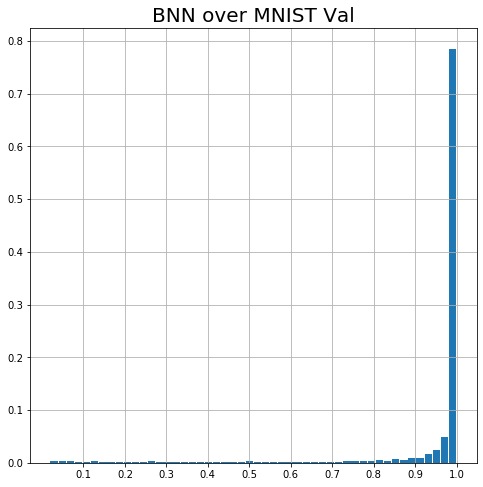

In [49]:
# histogram
weights = np.ones_like(pred_max_values)/len(pred_max_values)
plt.hist(pred_max_values, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title('BNN over MNIST Val', fontsize=20)
plt.show()

In [50]:
# preparing for evaluation
dataiter = iter(test_loader)
images, labels = dataiter.next()

Real:  4


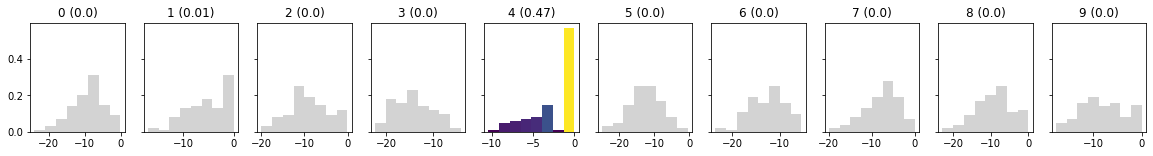

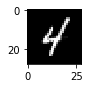

Correct
Real:  6


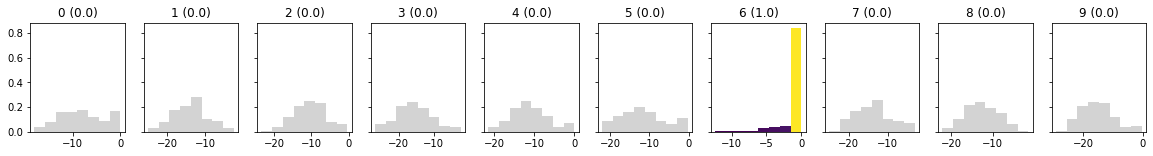

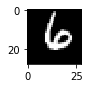

Correct
Real:  7


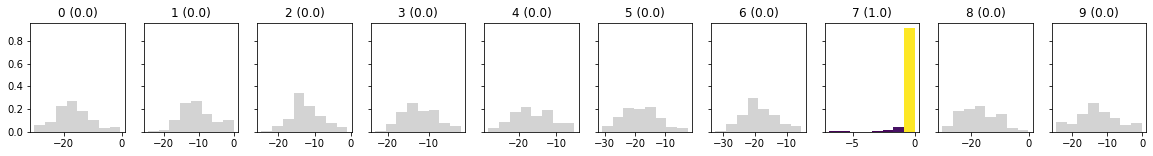

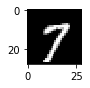

Correct
Real:  5


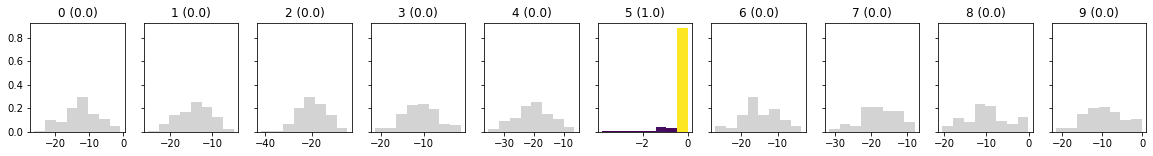

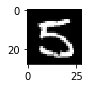

Correct
Real:  4


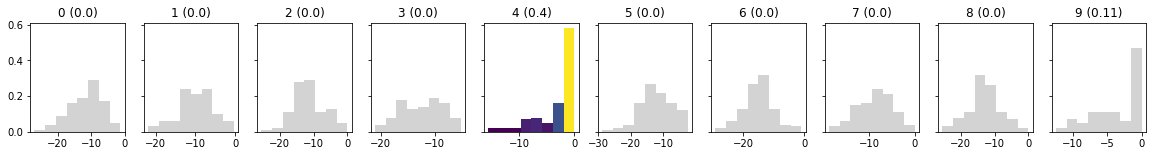

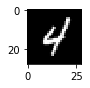

Correct
Real:  4


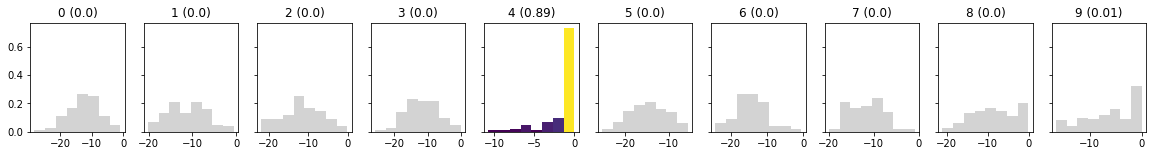

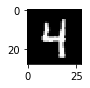

Correct
Real:  3


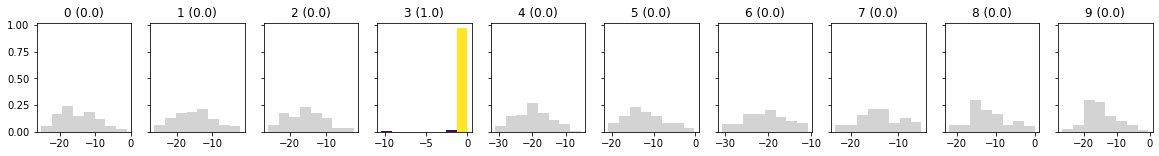

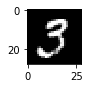

Correct
Real:  6


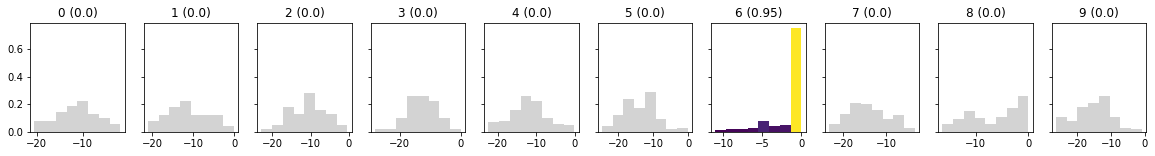

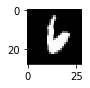

Correct
Real:  6


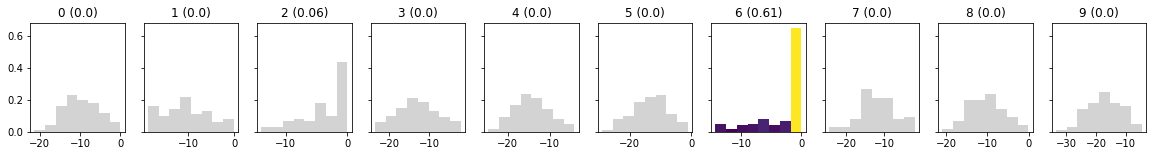

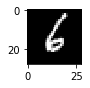

Correct
Real:  2


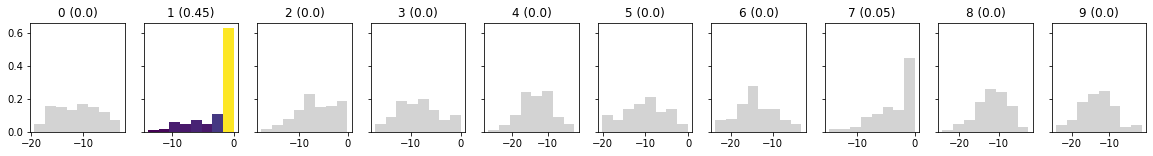

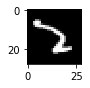

Incorrect :()
Summary
Total images:  10
Predicted for:  10
Accuracy when predicted:  0.9


In [51]:
num_to_plot = 10
start = np.random.randint(0,high=len(images)-num_to_plot)
_ = test_batch(images[start:start+num_to_plot], labels[start:start+num_to_plot])

Real:  4


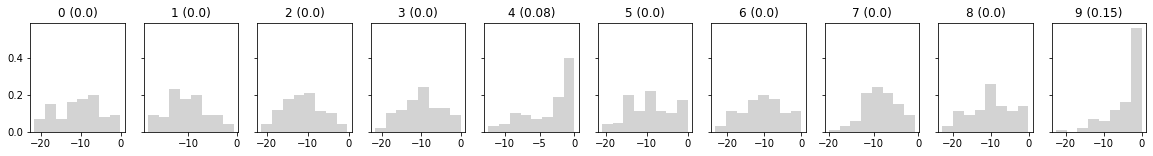

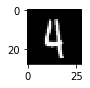

Undecided.
Real:  4


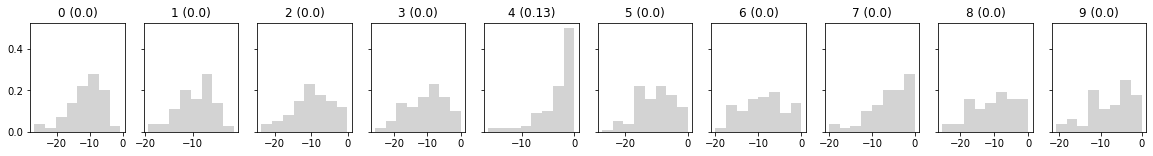

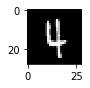

Undecided.
Real:  6


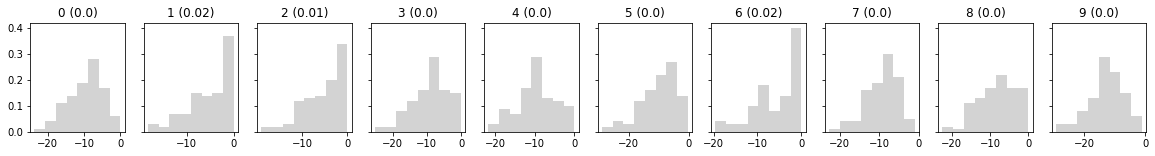

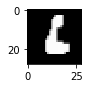

Undecided.
Real:  4


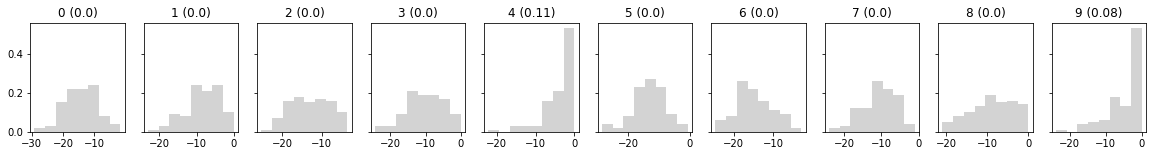

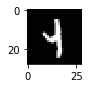

Undecided.
Real:  5


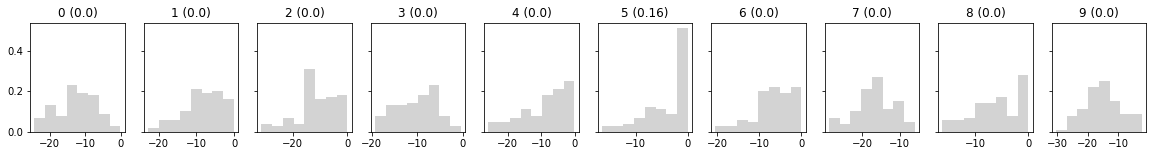

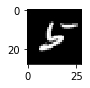

Undecided.
Real:  1


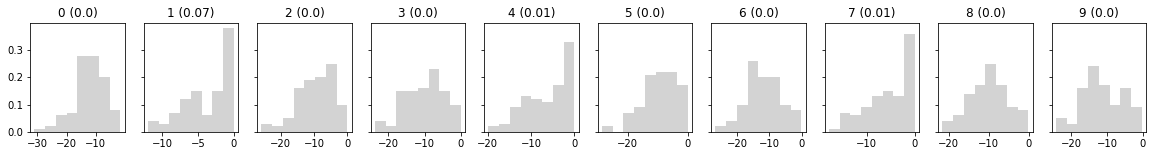

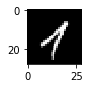

Undecided.
Real:  3


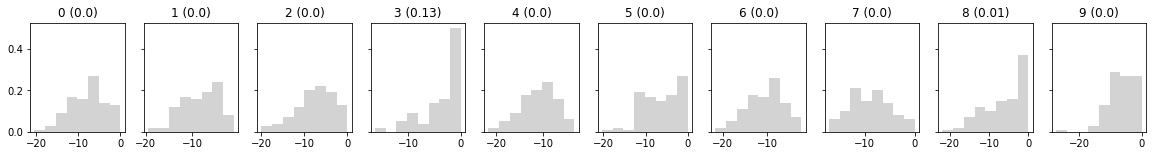

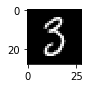

Undecided.
Real:  0


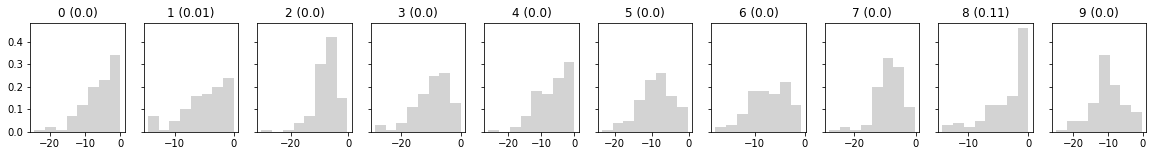

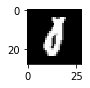

Undecided.
Real:  8


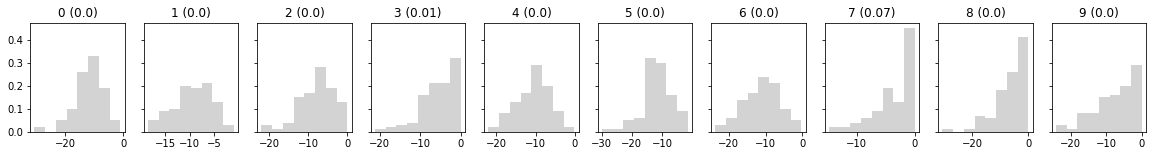

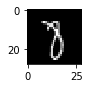

Undecided.
Real:  2


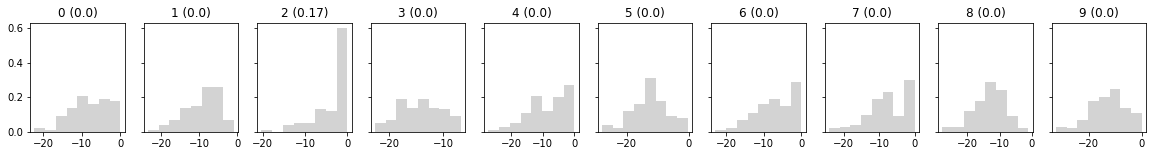

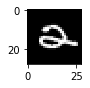

Undecided.
Real:  7


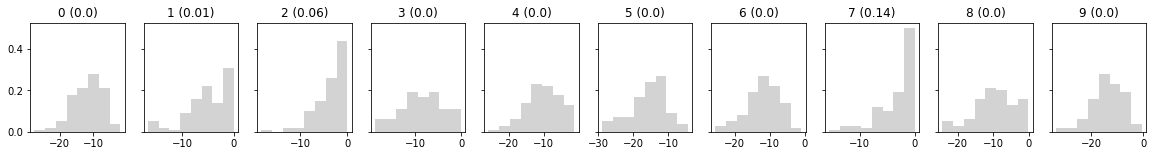

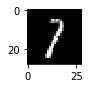

Undecided.
Real:  7


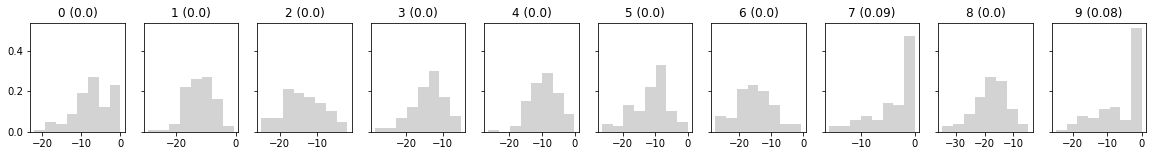

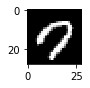

Undecided.
Real:  6


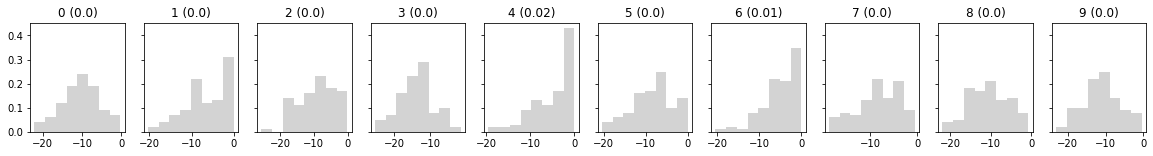

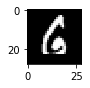

Undecided.
Real:  3


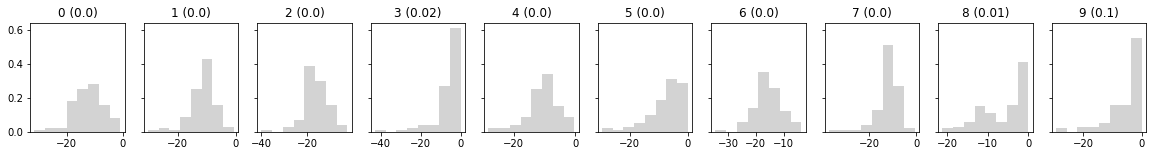

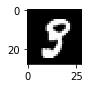

Undecided.
Real:  7


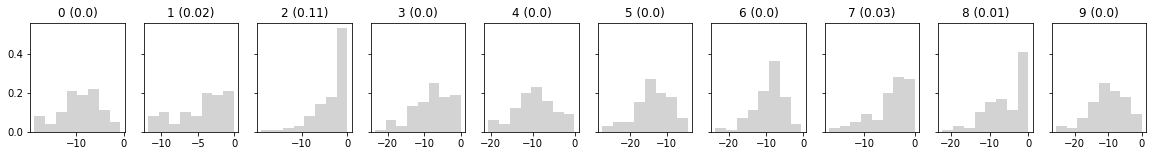

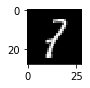

Undecided.
Real:  7


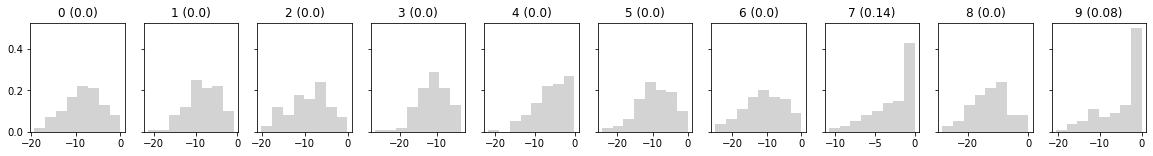

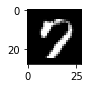

Undecided.
Real:  9


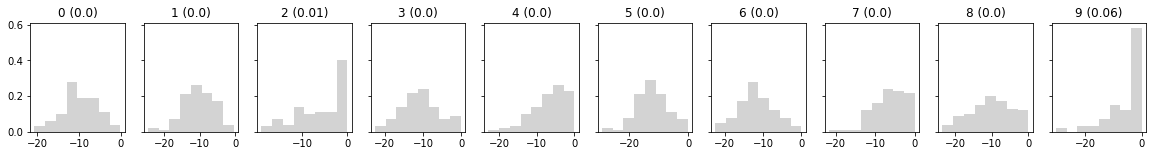

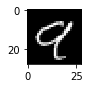

Undecided.
Real:  9


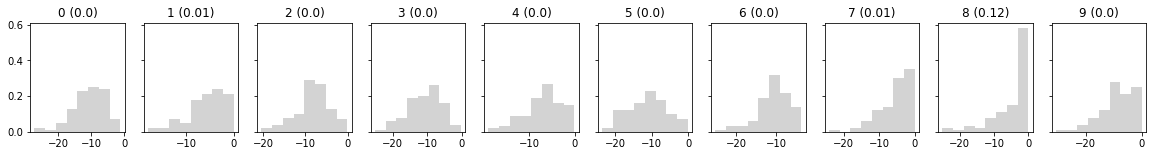

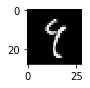

Undecided.
Real:  4


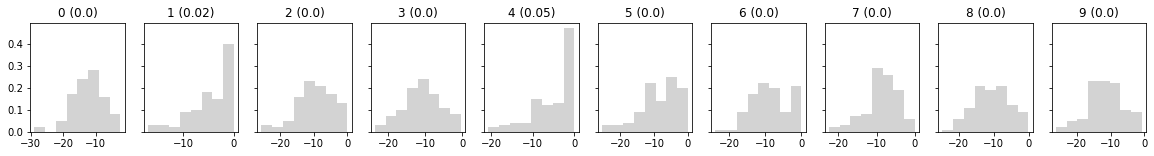

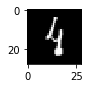

Undecided.
Real:  1


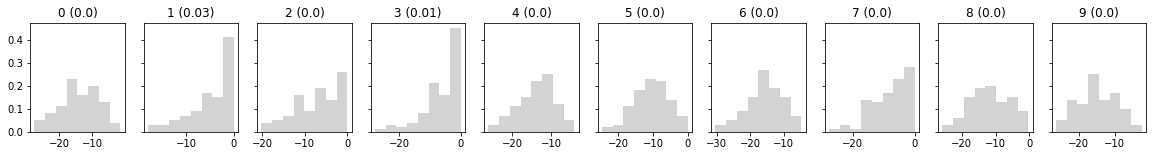

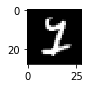

Undecided.
Real:  6


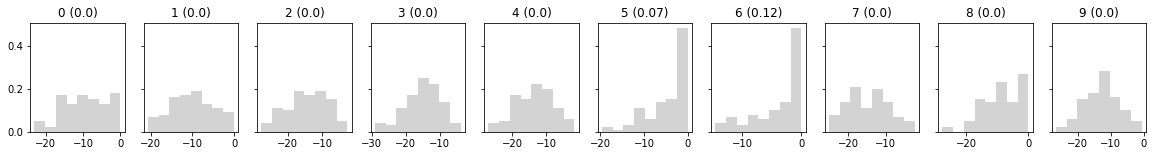

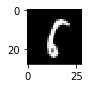

Undecided.
Real:  2


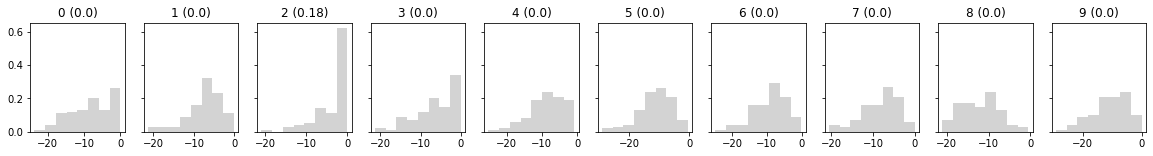

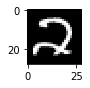

Undecided.
Real:  8


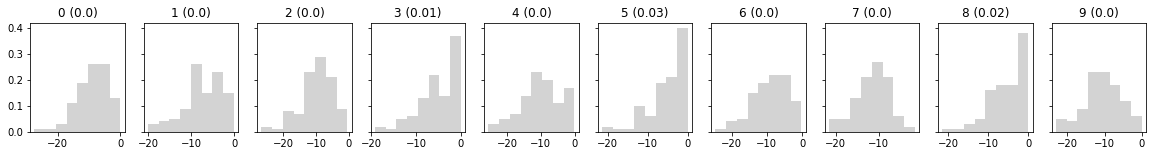

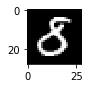

Undecided.
Real:  9


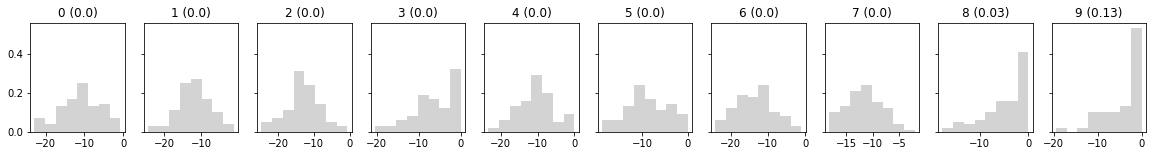

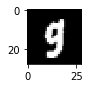

Undecided.
Real:  2


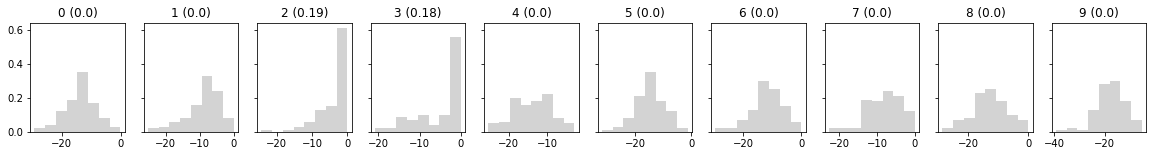

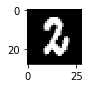

Undecided.
Real:  2


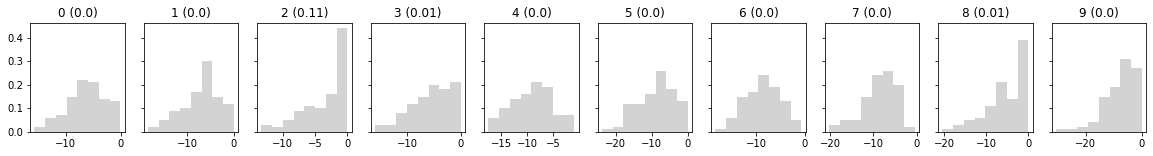

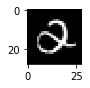

Undecided.
Real:  7


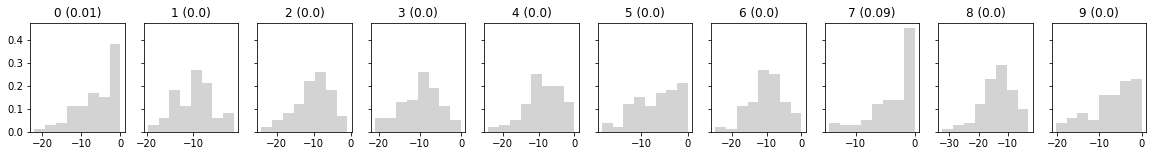

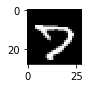

Undecided.
Real:  5


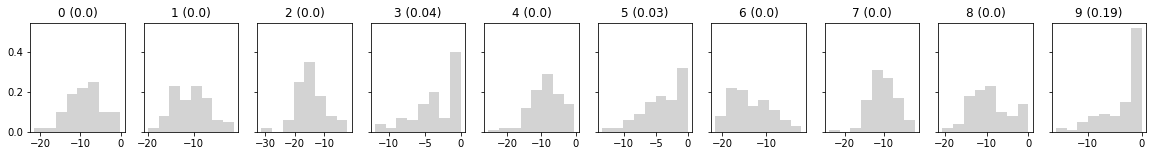

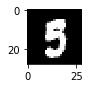

Undecided.
Real:  9


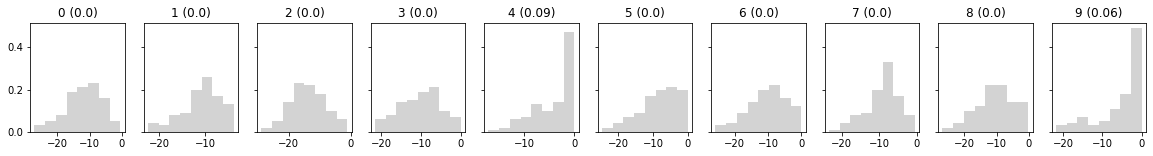

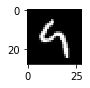

Undecided.
Real:  2


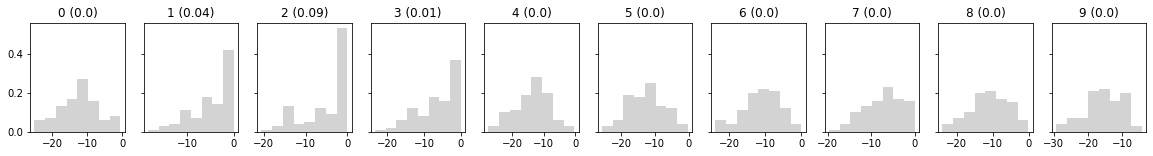

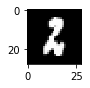

Undecided.
Real:  4


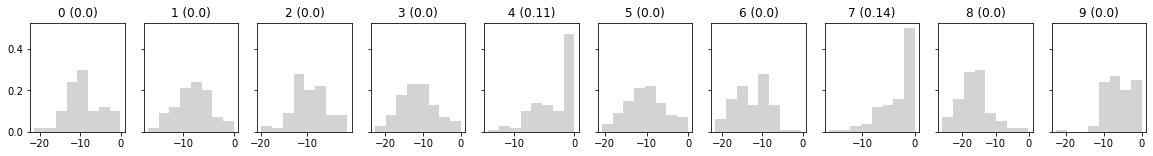

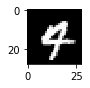

Undecided.
Real:  7


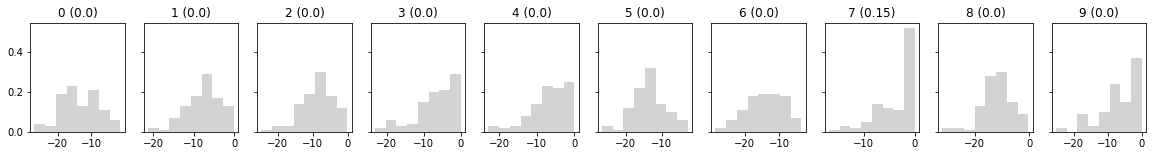

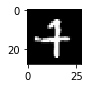

Undecided.
Real:  8


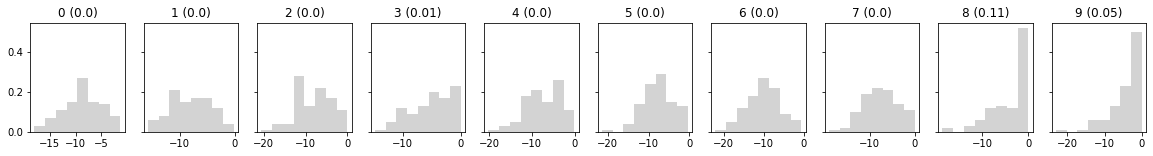

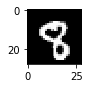

Undecided.
Real:  7


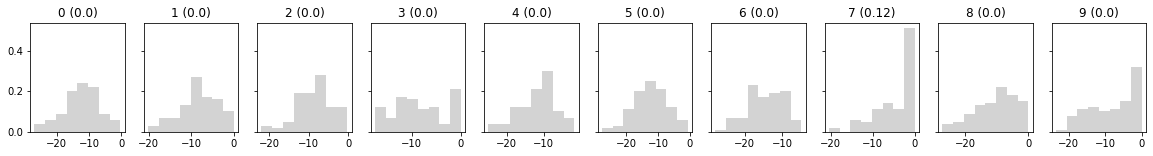

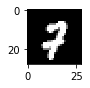

Undecided.
Real:  5


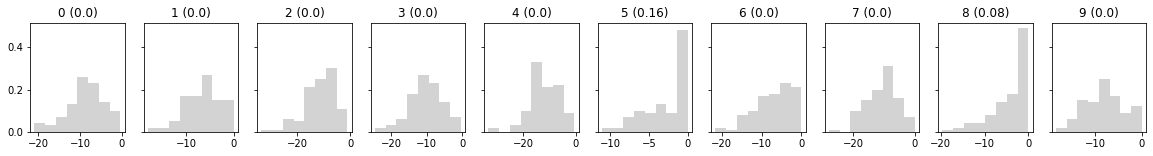

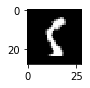

Undecided.
Real:  8


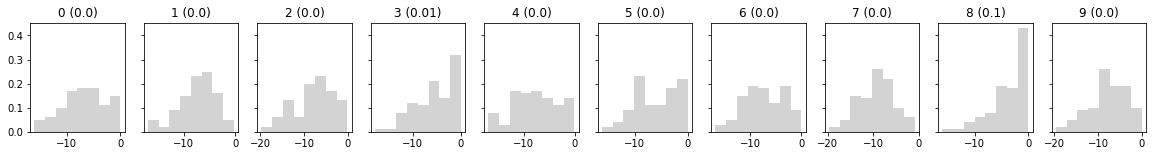

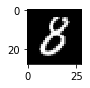

Undecided.
Real:  0


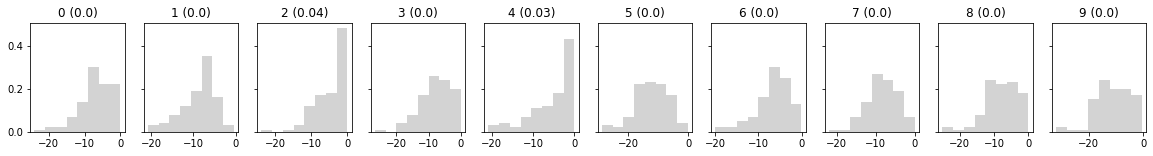

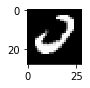

Undecided.
Real:  0


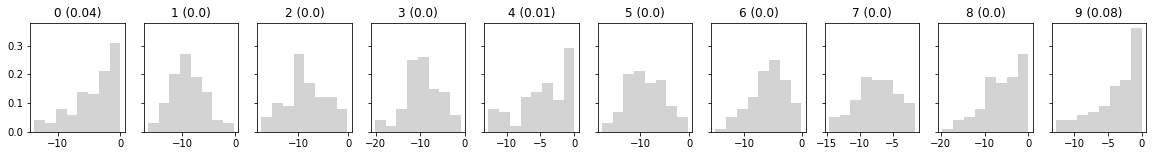

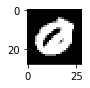

Undecided.
Real:  3


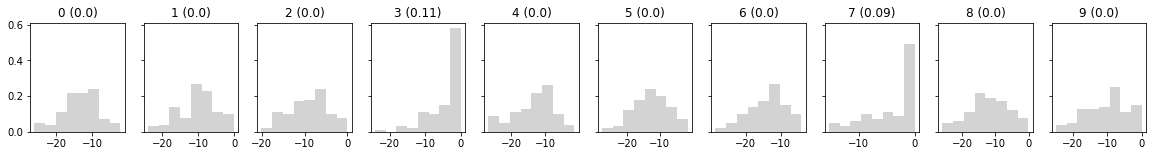

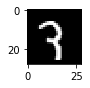

Undecided.
Real:  2


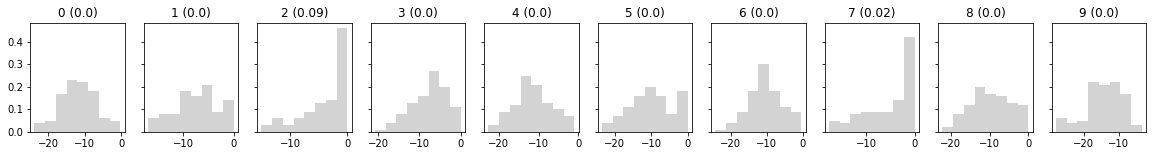

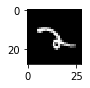

Undecided.
Real:  7


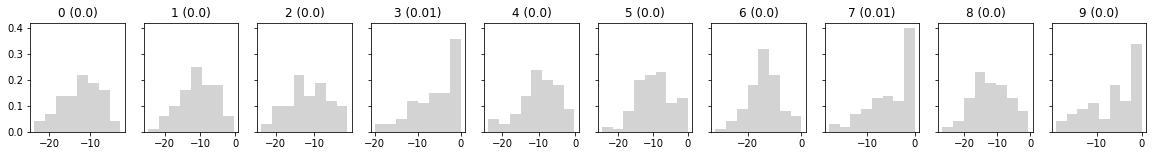

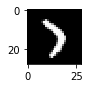

Undecided.
Real:  8


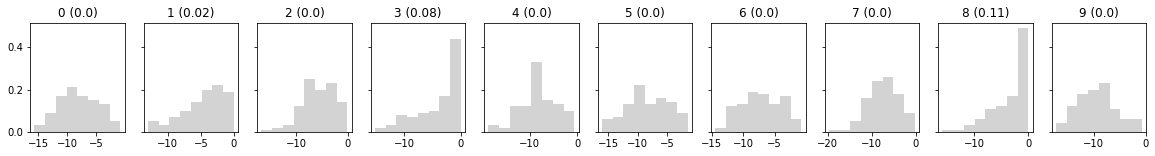

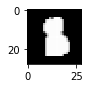

Undecided.
Real:  2


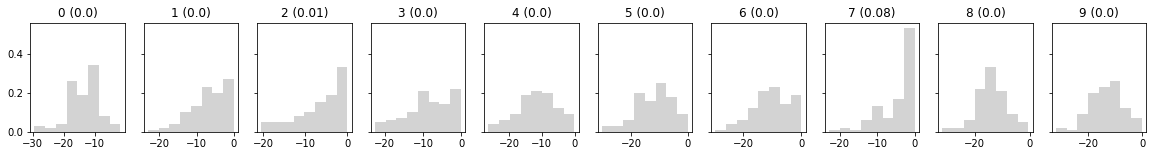

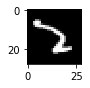

Undecided.
Real:  5


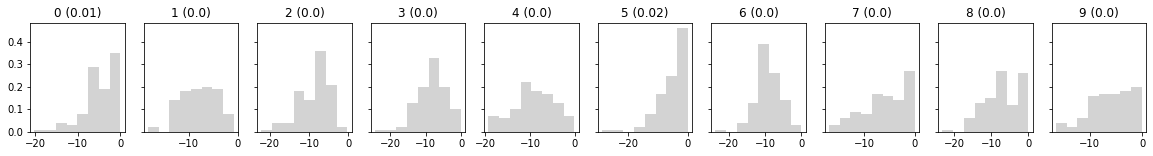

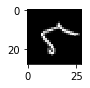

Undecided.
Real:  5


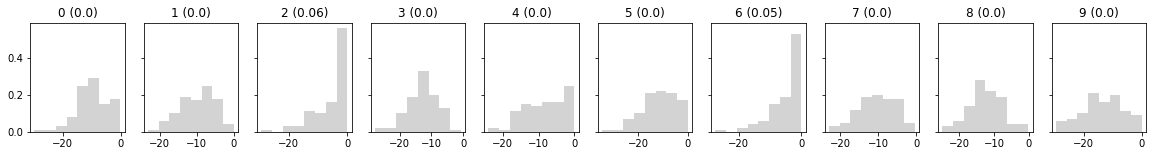

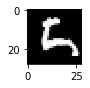

Undecided.
Real:  9


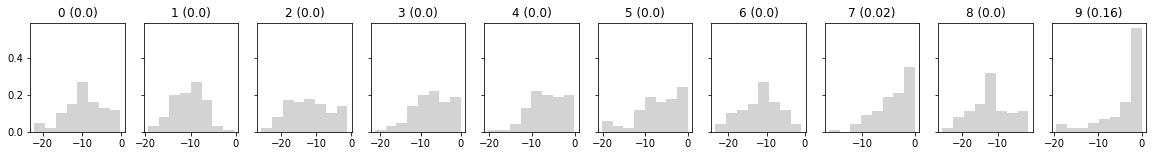

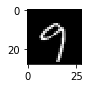

Undecided.
Real:  7


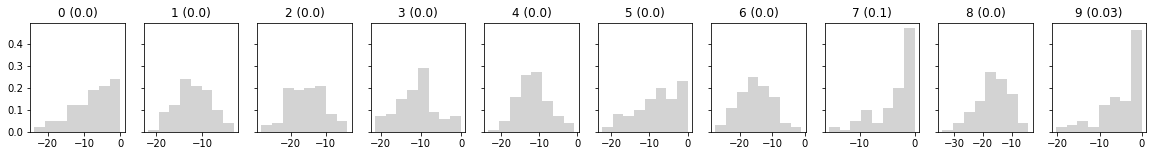

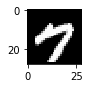

Undecided.
Real:  7


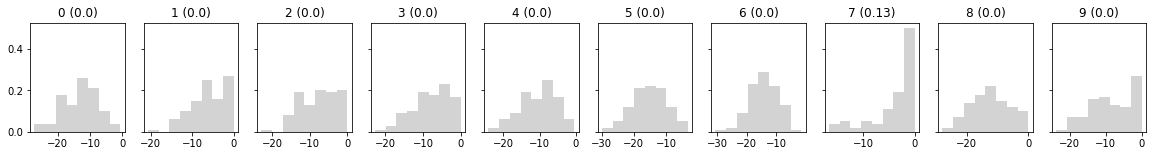

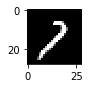

Undecided.
Real:  9


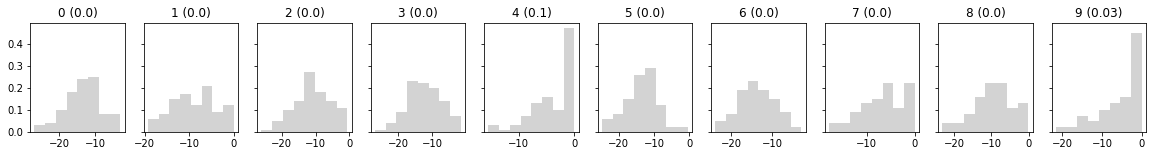

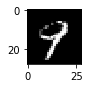

Undecided.
Real:  2


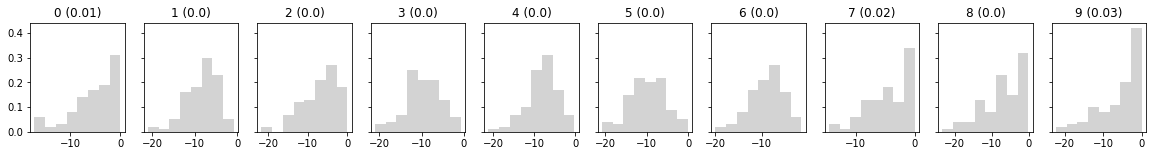

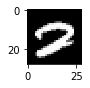

Undecided.
Real:  7


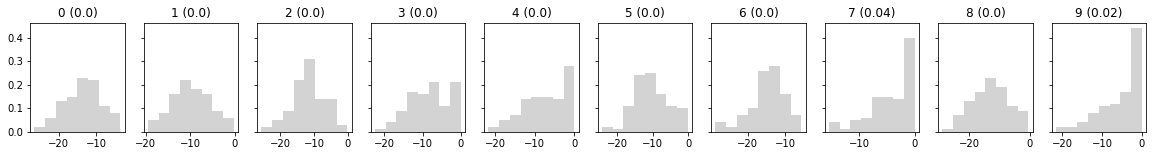

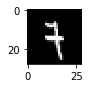

Undecided.
Real:  3


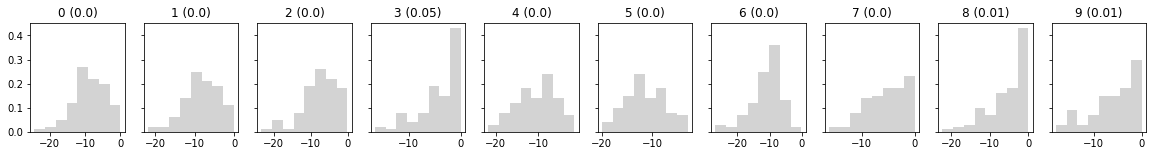

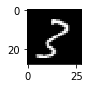

Undecided.
Real:  3


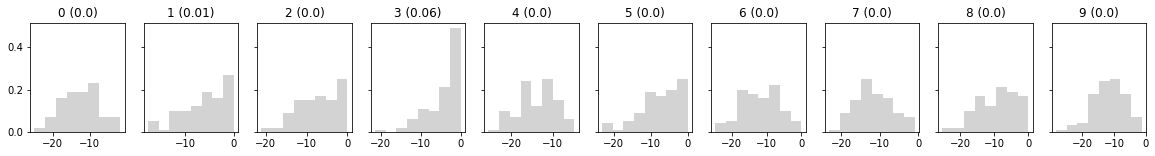

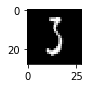

Undecided.
Real:  9


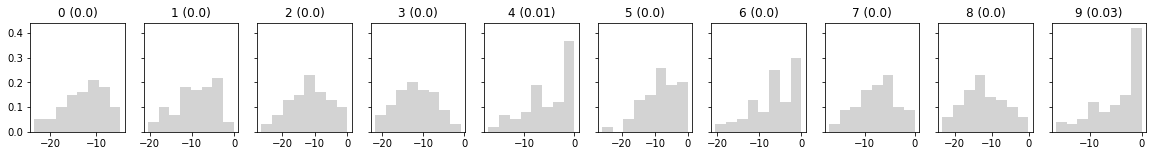

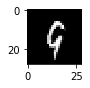

Undecided.
Real:  5


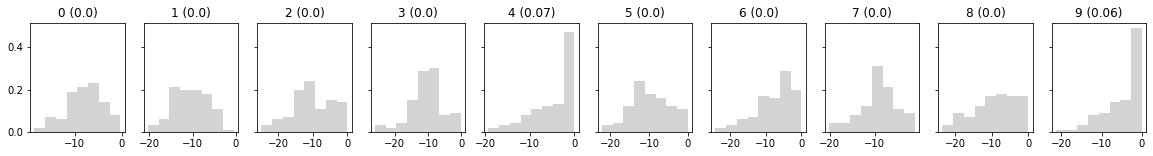

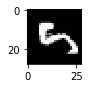

Undecided.
Real:  4


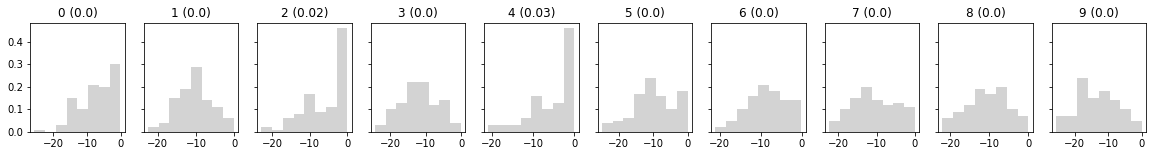

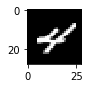

Undecided.
Real:  7


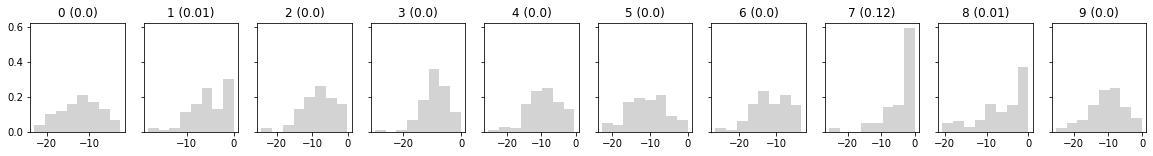

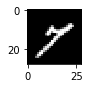

Undecided.
Real:  9


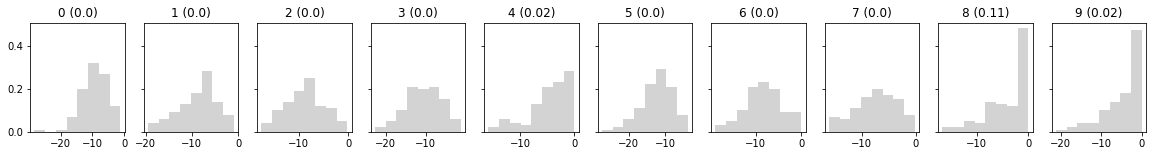

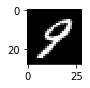

Undecided.
Real:  9


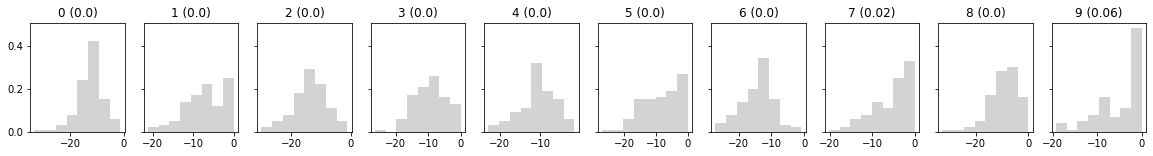

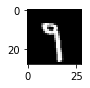

Undecided.
Real:  2


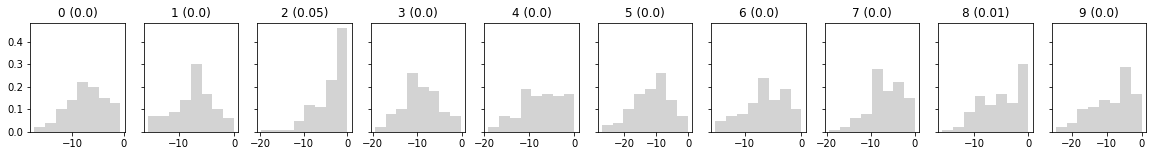

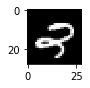

Undecided.
Real:  4


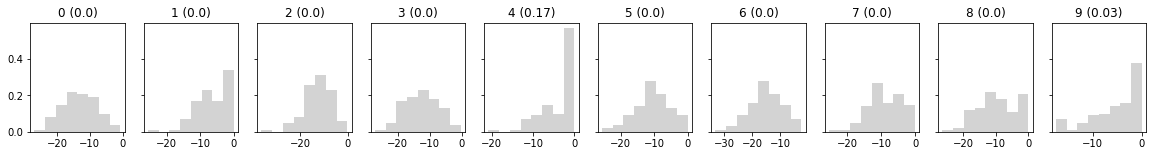

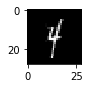

Undecided.
Real:  2


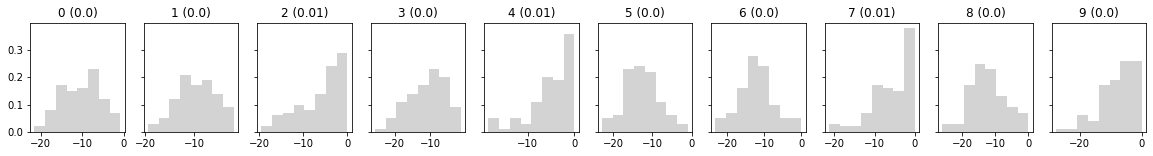

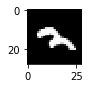

Undecided.
Real:  2


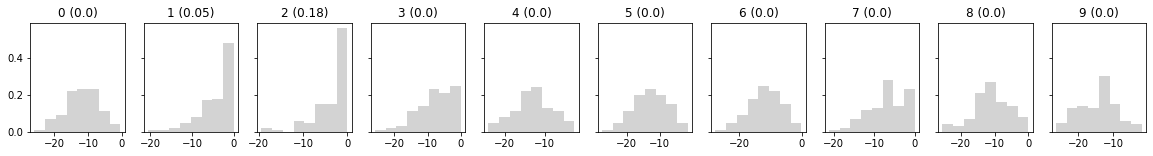

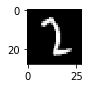

Undecided.
Real:  2


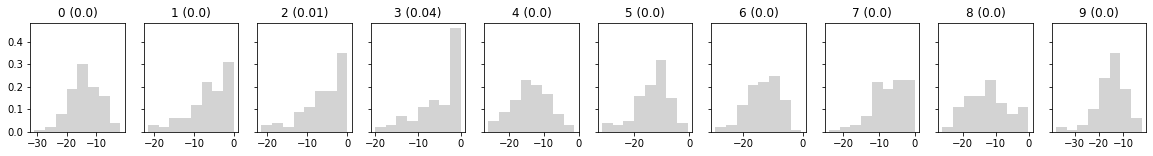

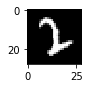

Undecided.
Real:  5


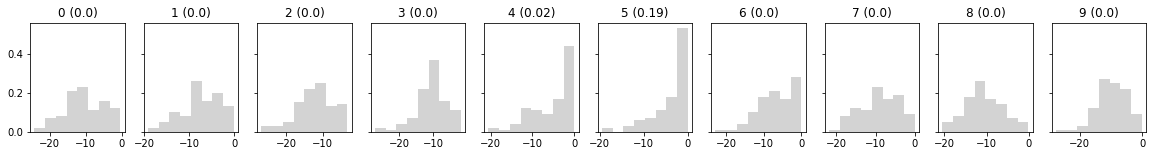

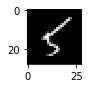

Undecided.
Real:  3


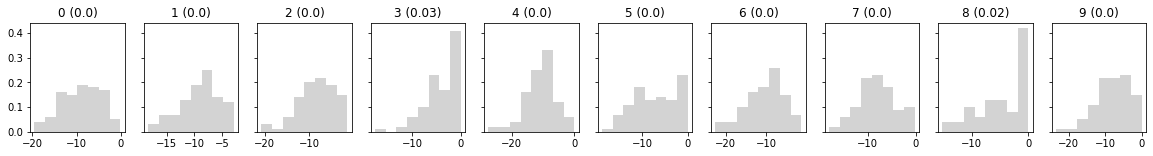

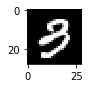

Undecided.
Real:  6


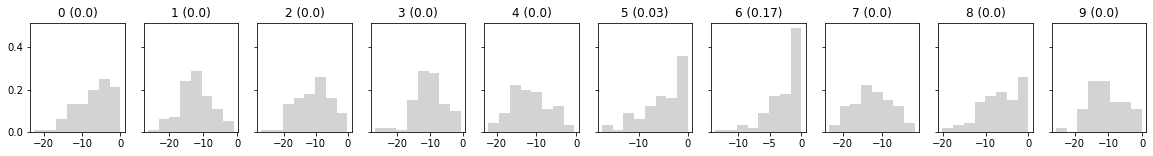

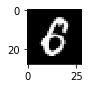

Undecided.
Real:  5


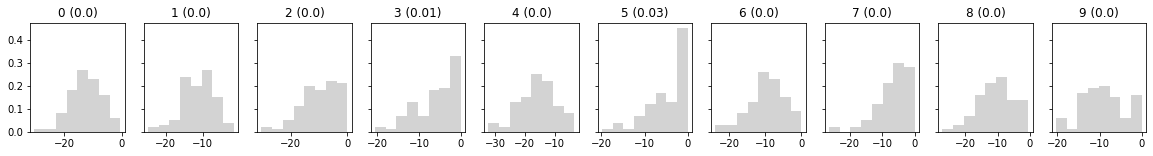

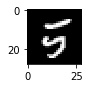

Undecided.
Real:  0


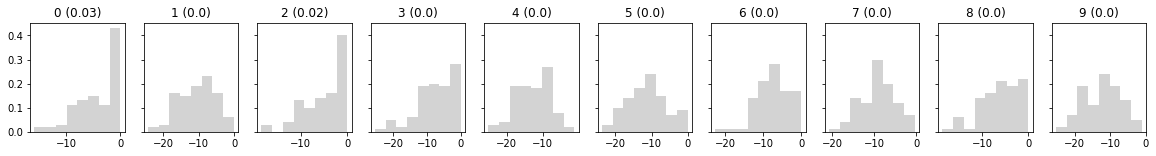

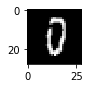

Undecided.
Real:  3


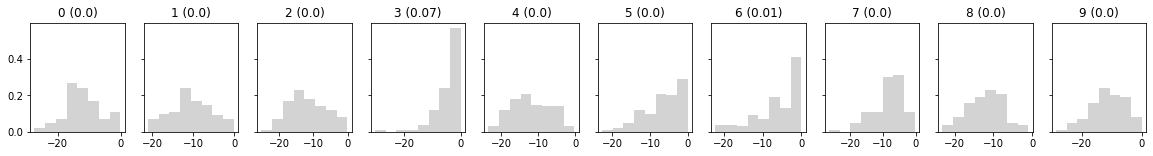

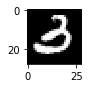

Undecided.
Real:  9


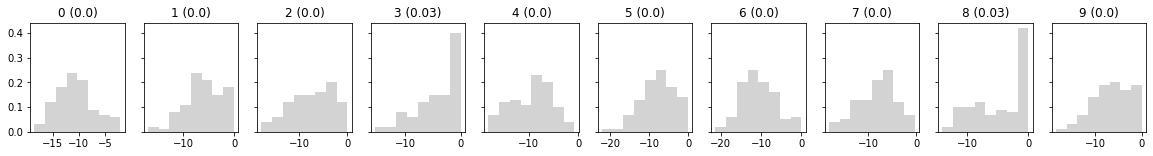

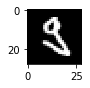

Undecided.
Real:  8


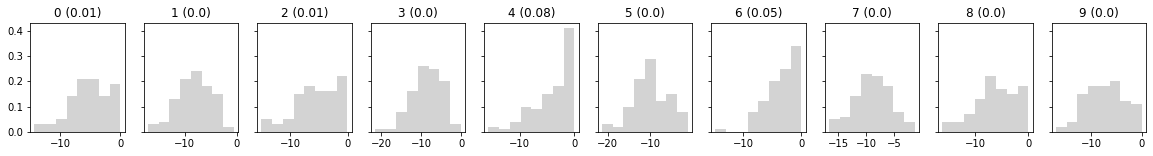

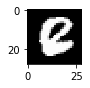

Undecided.
Real:  1


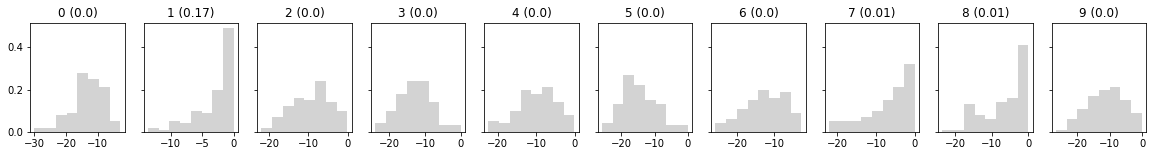

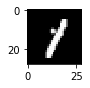

Undecided.
Real:  5


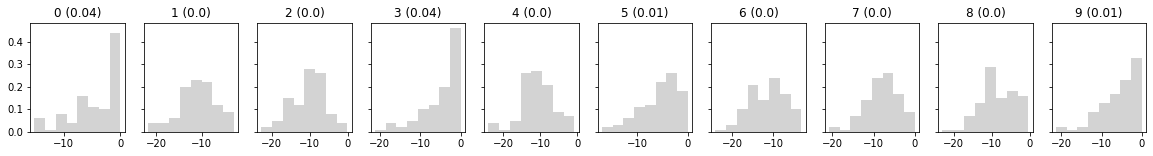

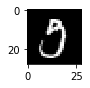

Undecided.
Real:  2


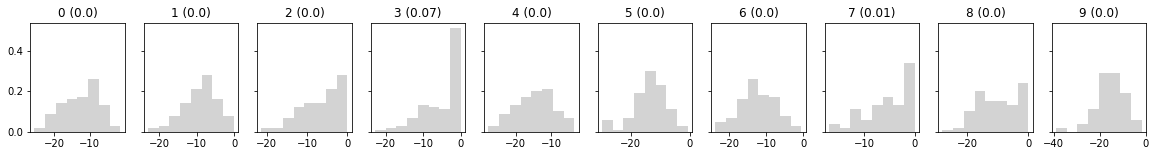

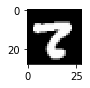

Undecided.
Real:  8


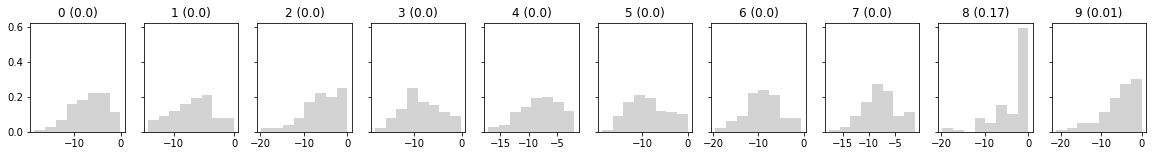

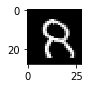

Undecided.
Real:  2


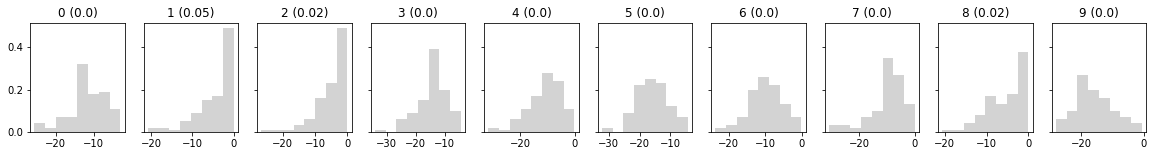

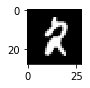

Undecided.
Real:  1


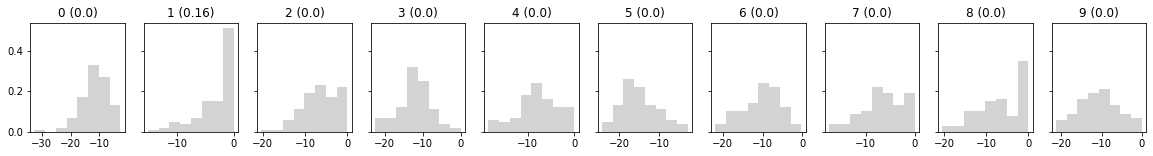

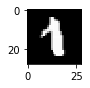

Undecided.
Real:  6


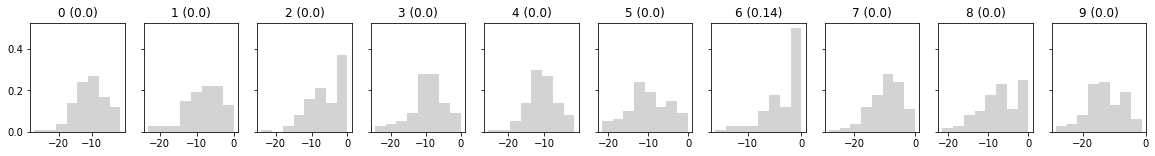

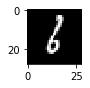

Undecided.
Real:  8


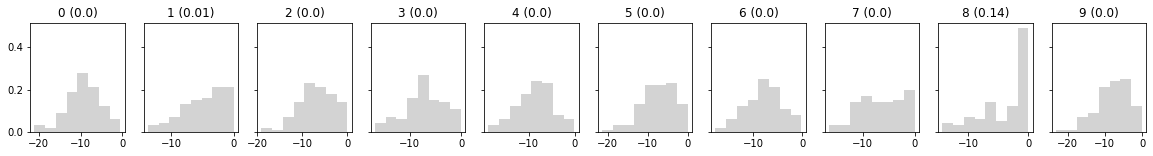

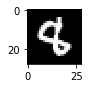

Undecided.
Real:  2


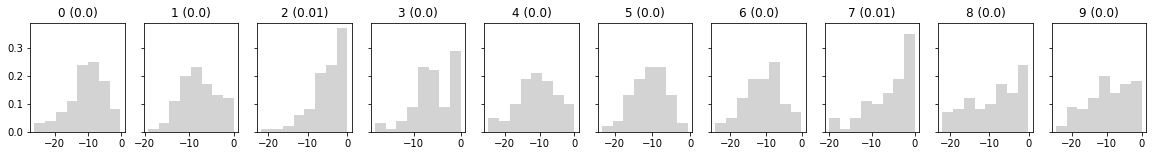

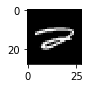

Undecided.
Real:  9


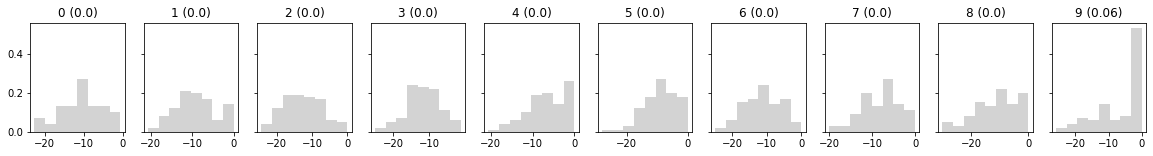

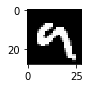

Undecided.
Real:  6


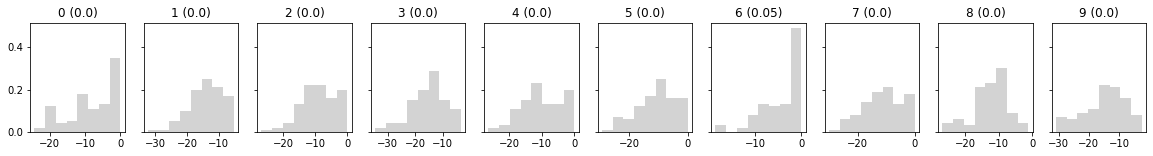

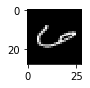

Undecided.
Real:  5


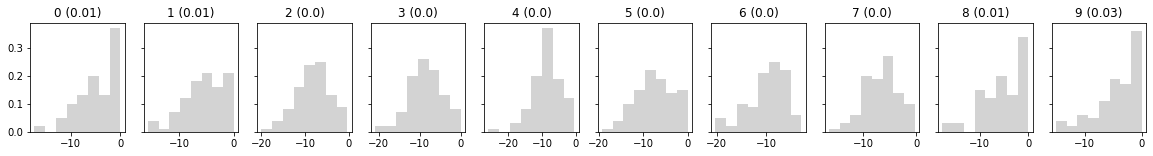

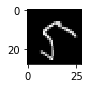

Undecided.
Real:  4


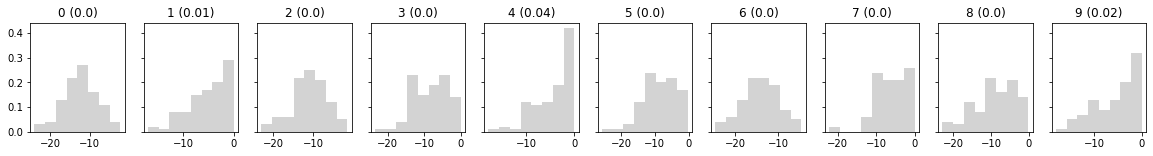

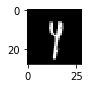

Undecided.
Real:  8


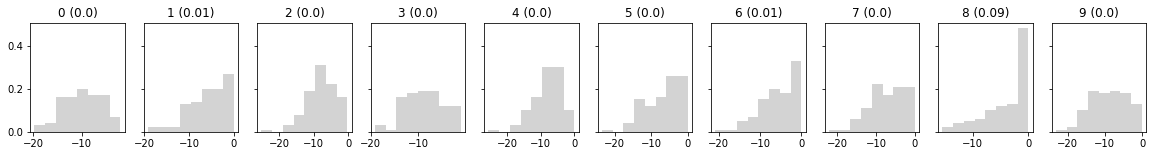

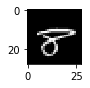

Undecided.
Real:  3


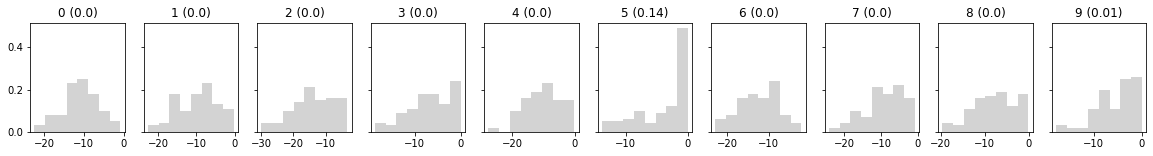

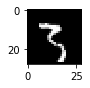

Undecided.
Real:  3


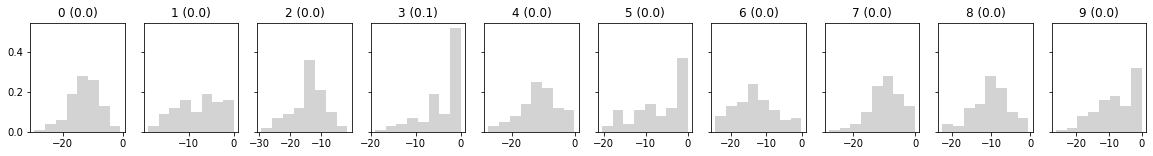

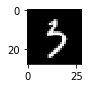

Undecided.
Real:  5


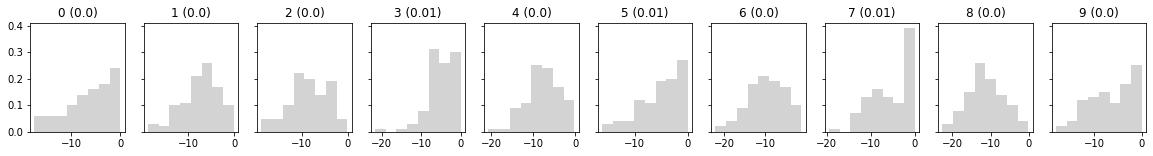

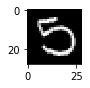

Undecided.
Real:  8


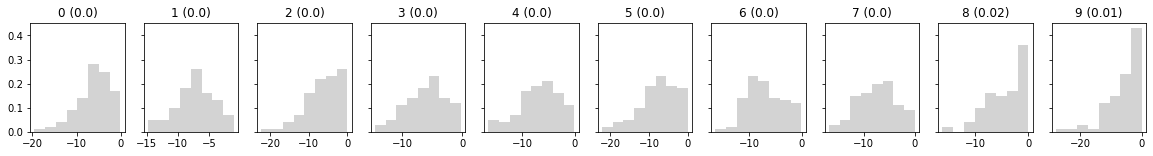

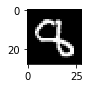

Undecided.
Real:  8


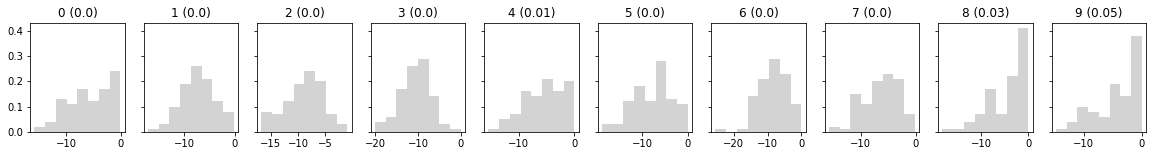

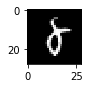

Undecided.
Real:  2


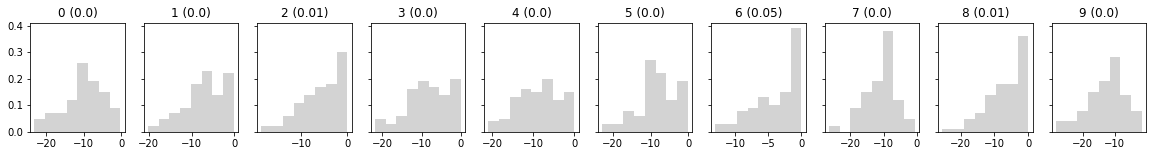

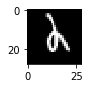

Undecided.
Real:  9


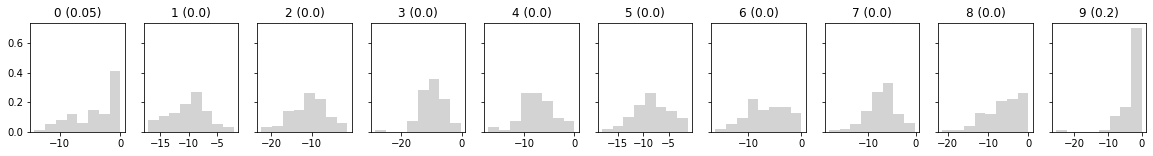

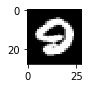

Undecided.
Real:  8


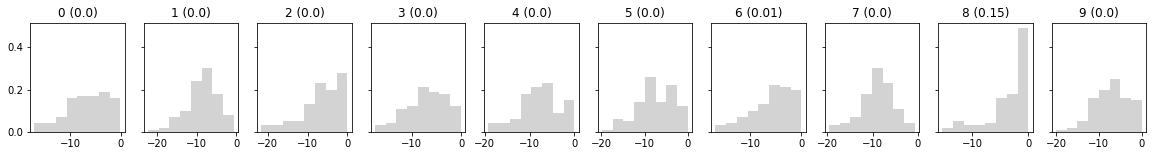

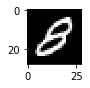

Undecided.
Real:  6


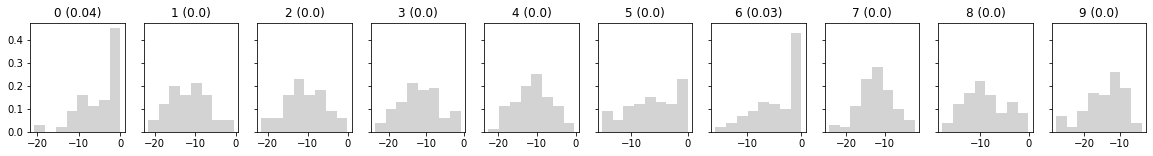

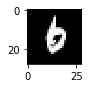

Undecided.
Real:  9


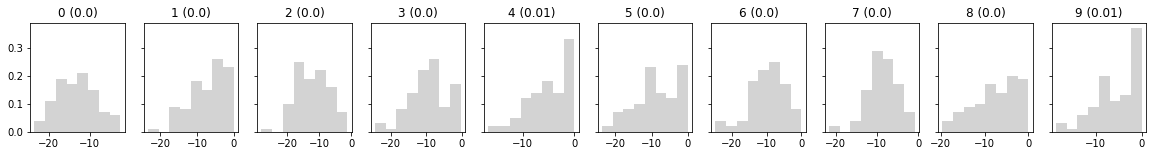

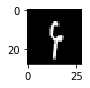

Undecided.
Real:  7


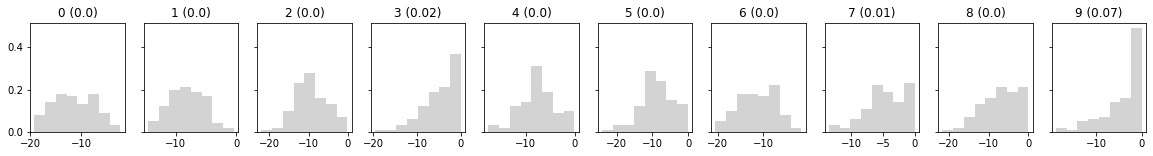

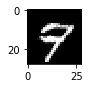

Undecided.
Real:  7


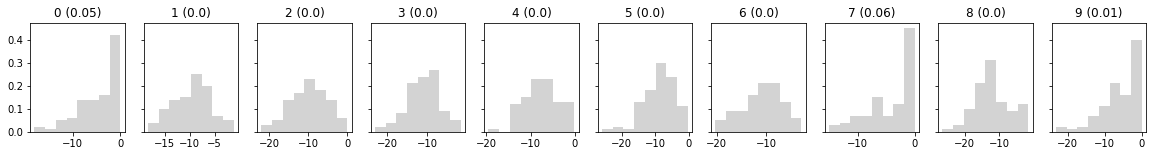

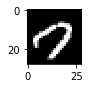

Undecided.
Real:  1


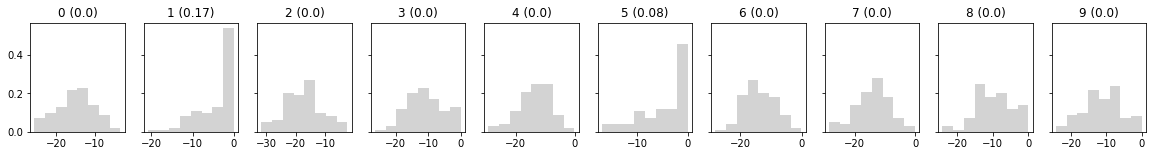

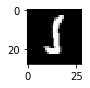

Undecided.
Real:  7


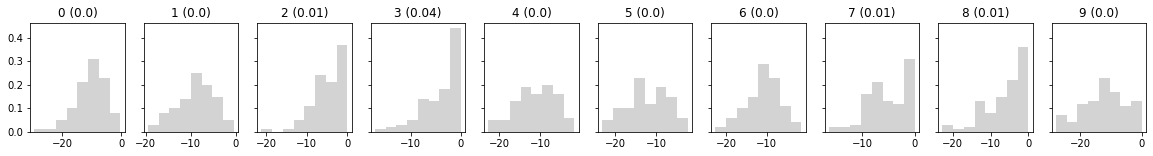

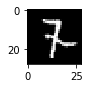

Undecided.
Real:  8


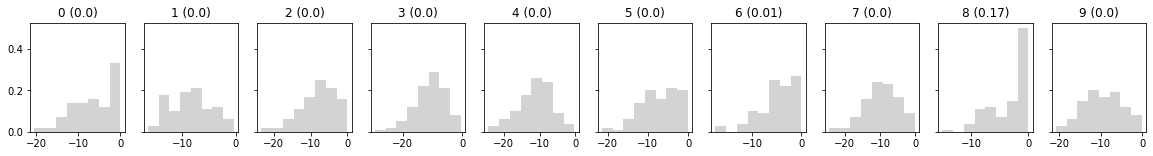

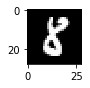

Undecided.
Real:  4


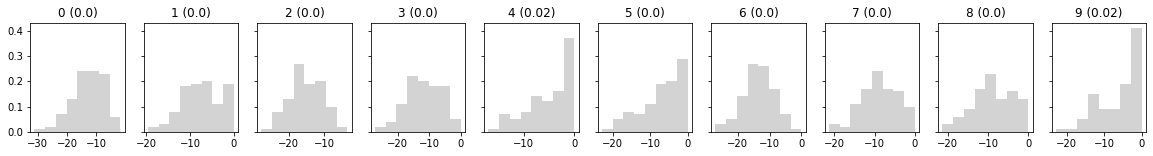

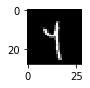

Undecided.
Real:  1


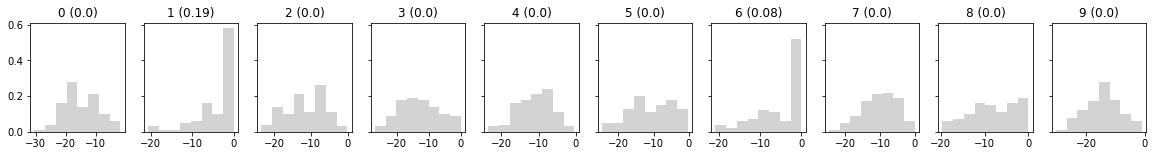

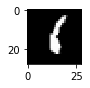

Undecided.
Real:  2


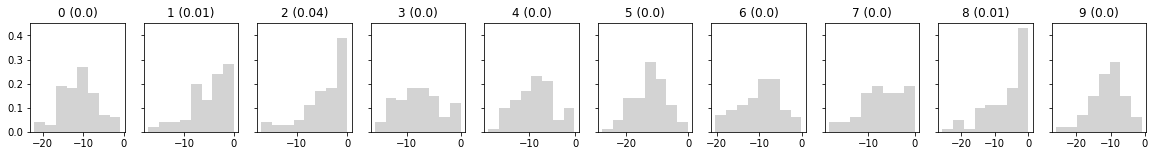

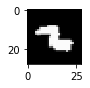

Undecided.
Real:  1


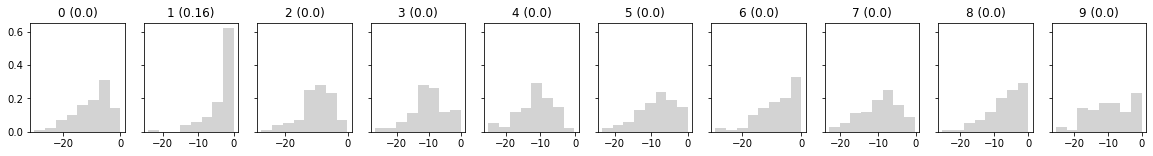

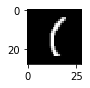

Undecided.
Real:  9


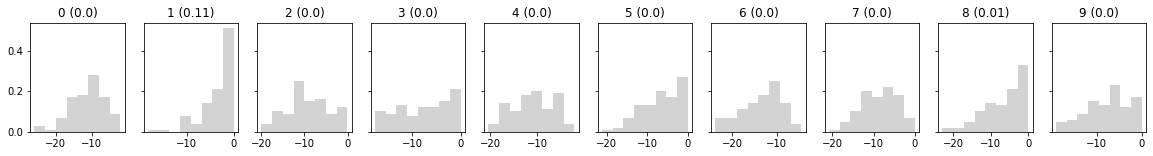

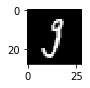

Undecided.
Real:  8


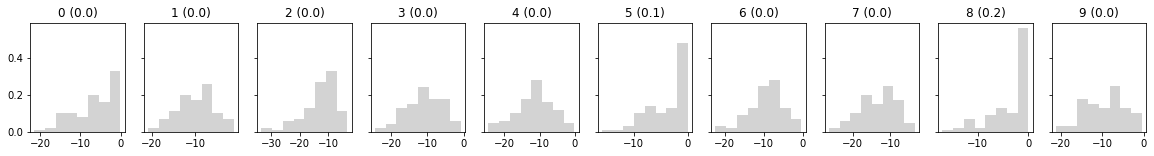

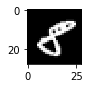

Undecided.
Real:  2


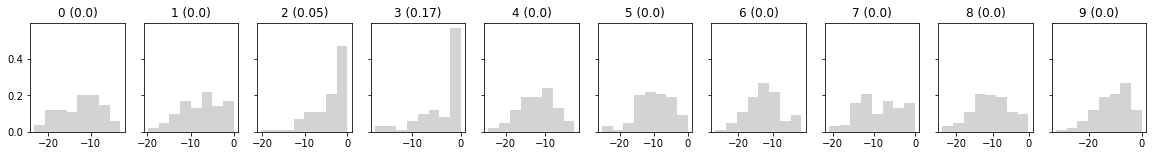

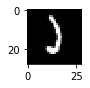

Undecided.
Real:  4


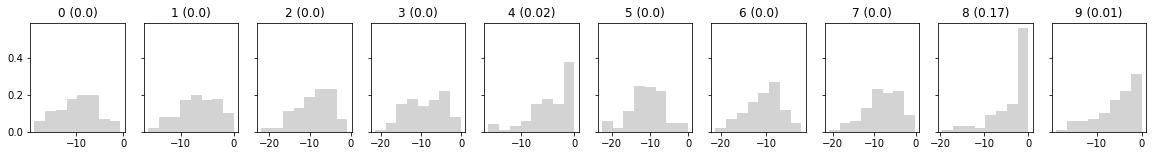

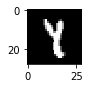

Undecided.
Real:  5


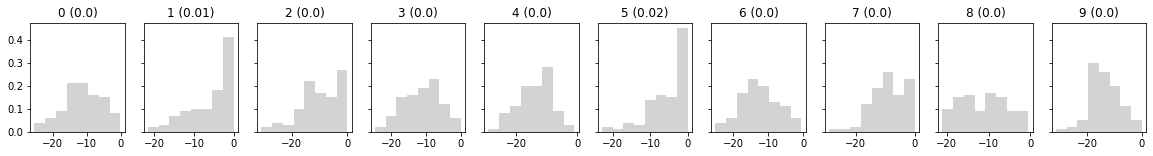

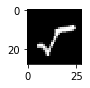

Undecided.
Real:  3


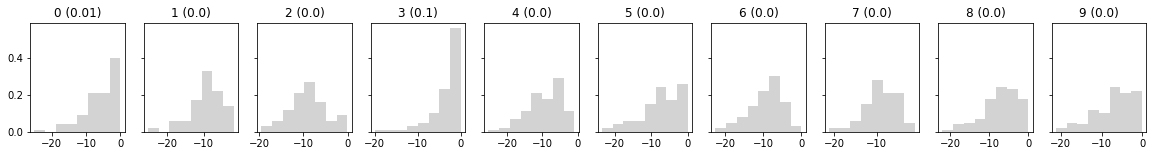

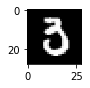

Undecided.
Real:  8


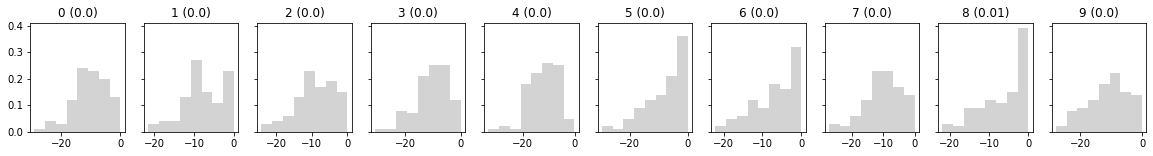

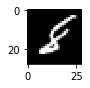

Undecided.
Real:  4


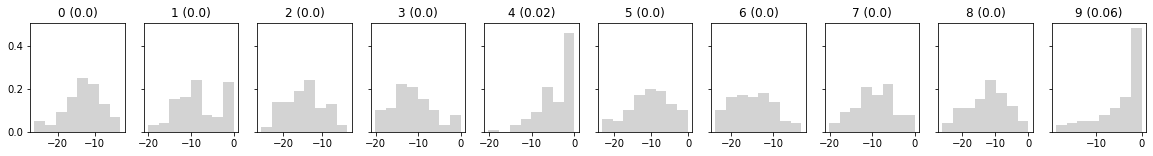

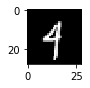

Undecided.
Real:  8


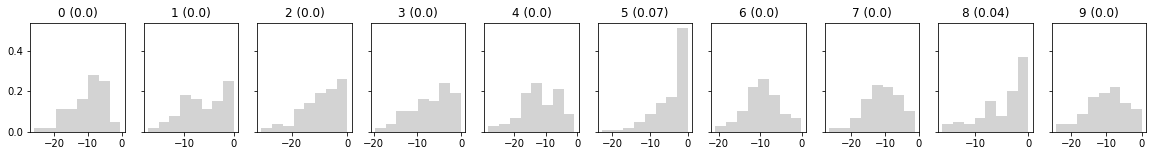

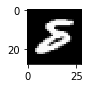

Undecided.
Real:  4


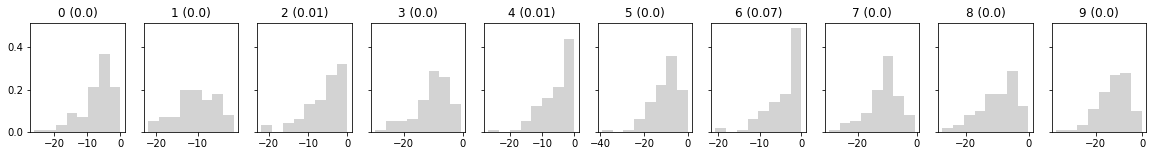

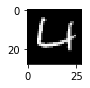

Undecided.
Real:  2


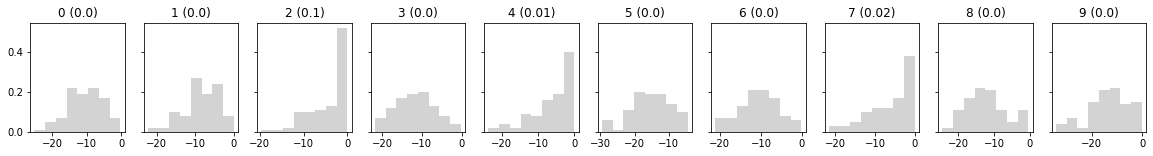

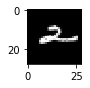

Undecided.
Real:  3


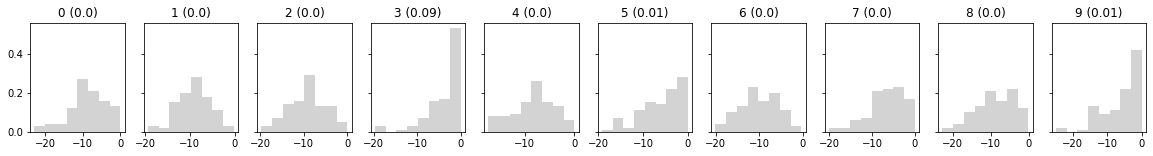

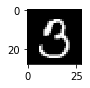

Undecided.
Real:  3


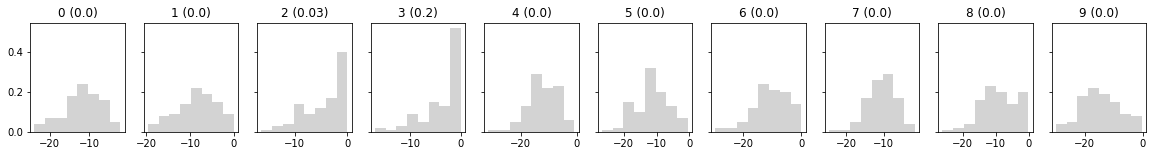

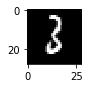

Undecided.
Real:  7


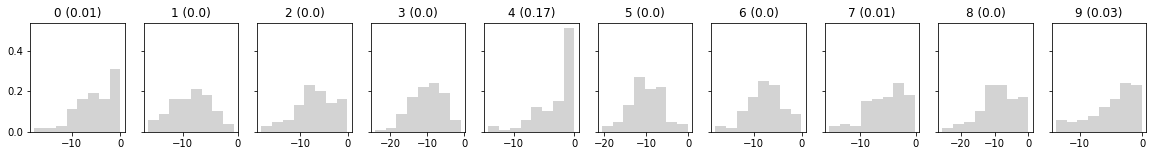

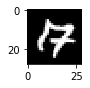

Undecided.
Real:  0


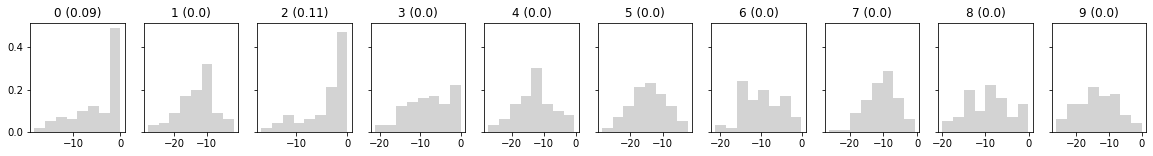

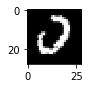

Undecided.
Real:  7


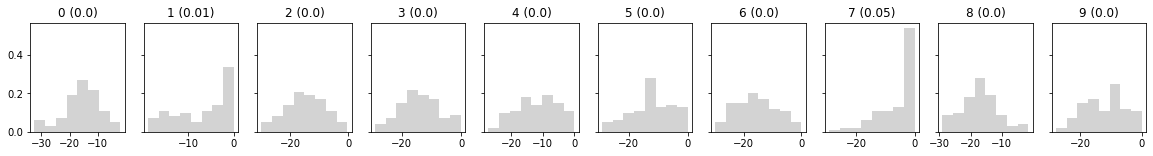

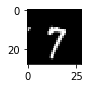

Undecided.
Real:  8


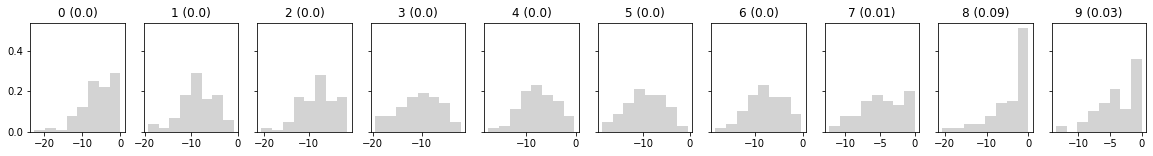

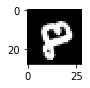

Undecided.
Real:  6


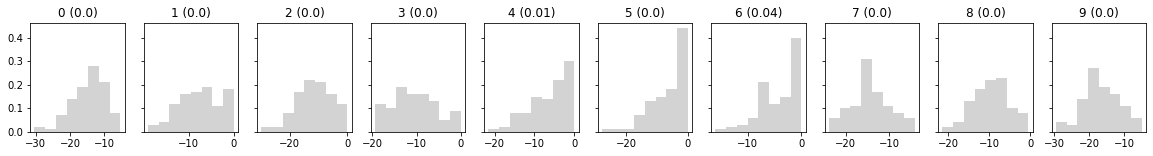

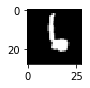

Undecided.
Real:  8


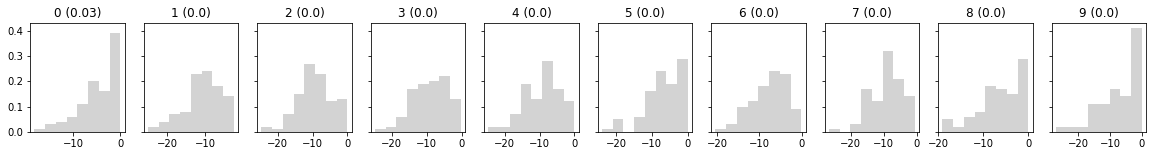

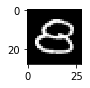

Undecided.
Real:  7


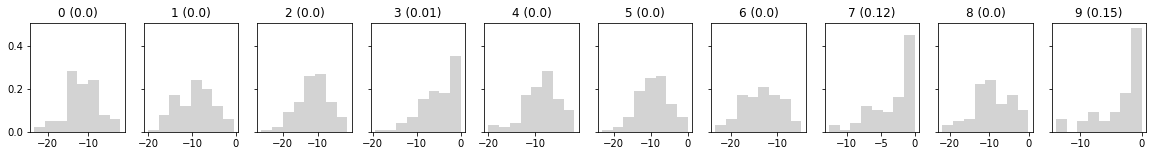

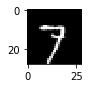

Undecided.
Real:  8


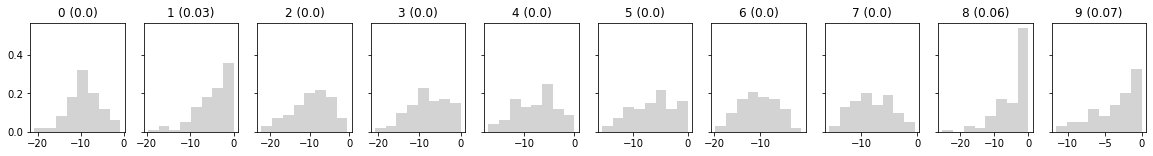

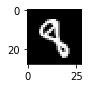

Undecided.
Real:  9


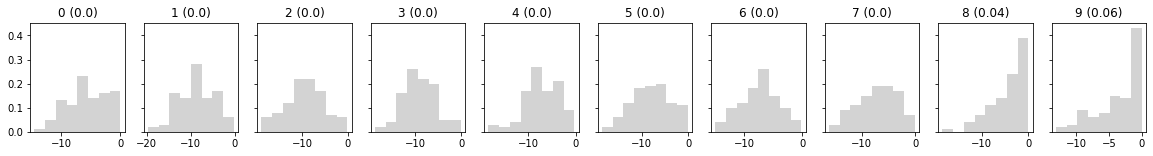

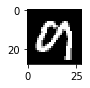

Undecided.
Real:  8


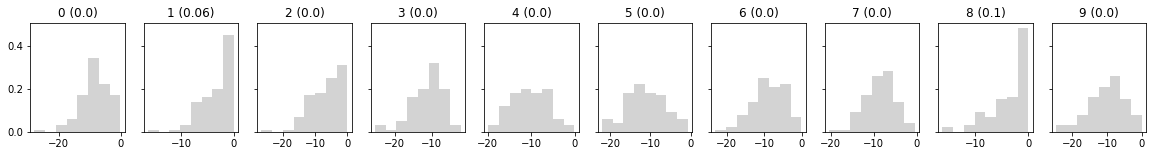

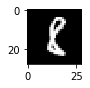

Undecided.
Real:  9


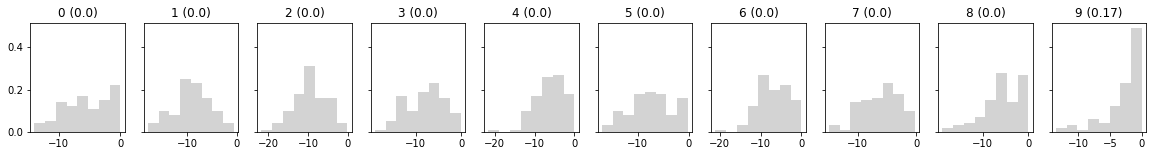

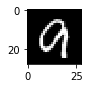

Undecided.
Real:  5


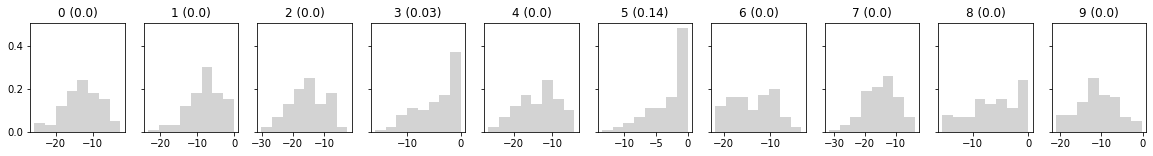

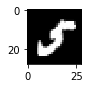

Undecided.
Real:  3


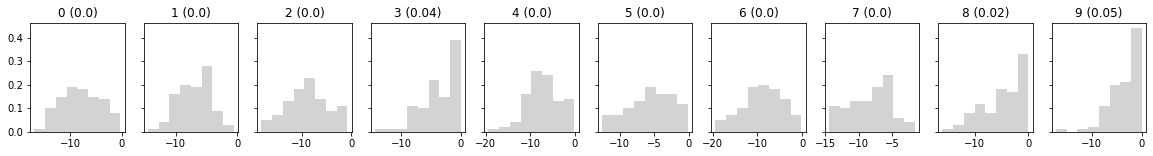

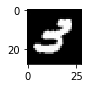

Undecided.
Real:  3


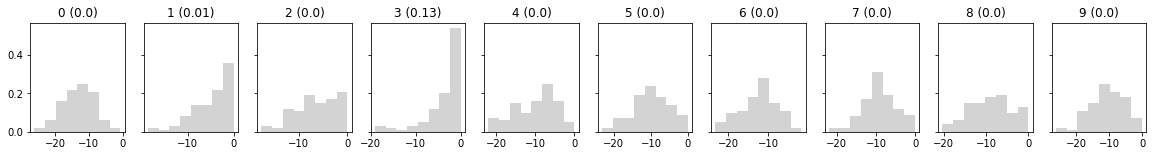

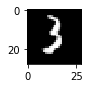

Undecided.
Real:  9


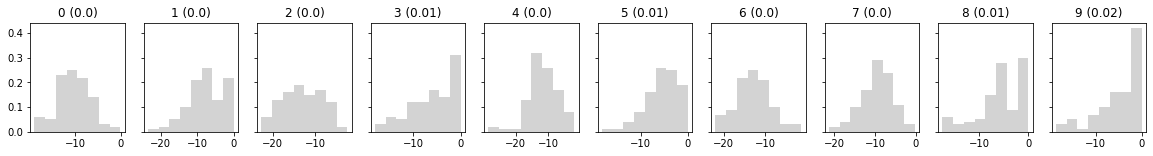

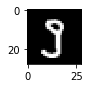

Undecided.
Real:  5


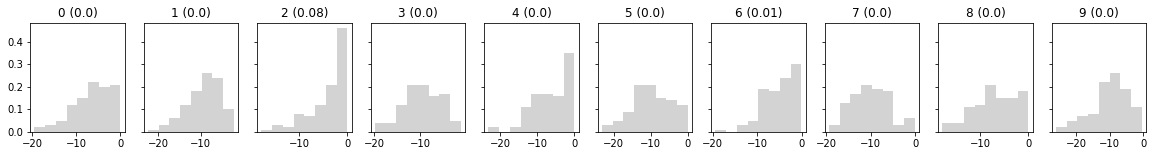

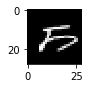

Undecided.
Real:  2


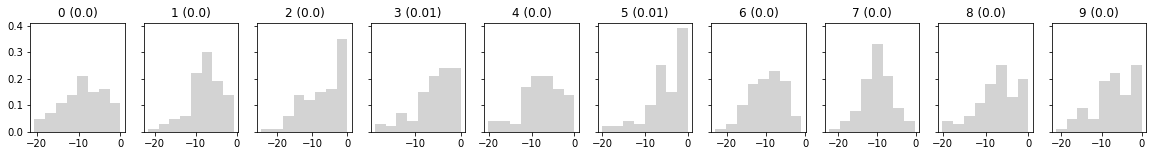

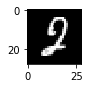

Undecided.
Real:  3


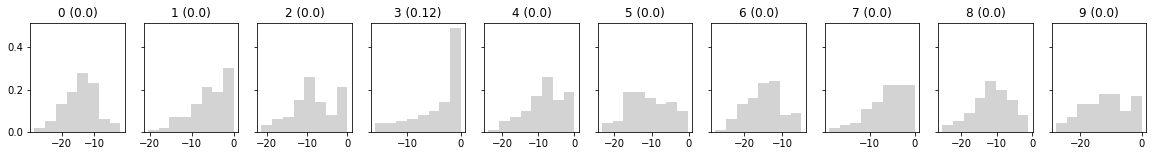

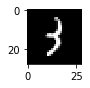

Undecided.
Real:  5


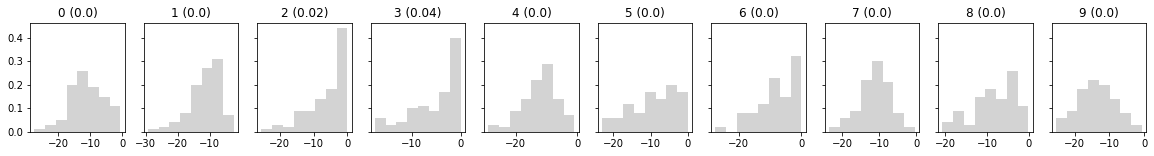

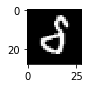

Undecided.
Real:  9


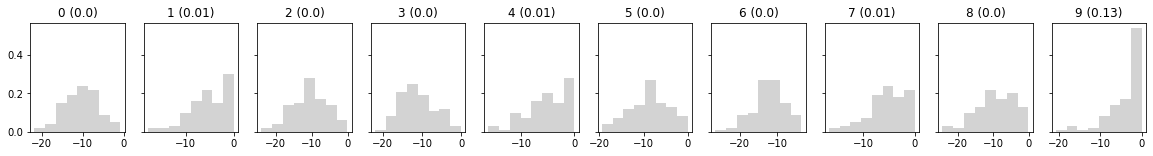

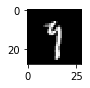

Undecided.
Real:  9


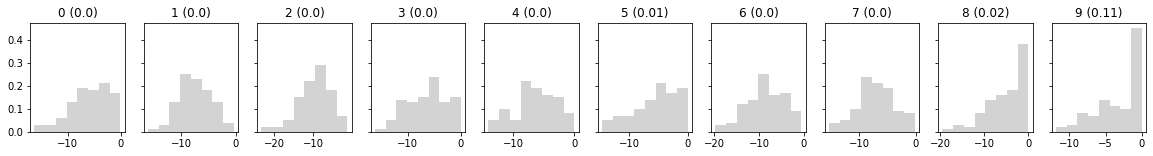

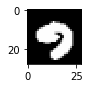

Undecided.
Real:  6


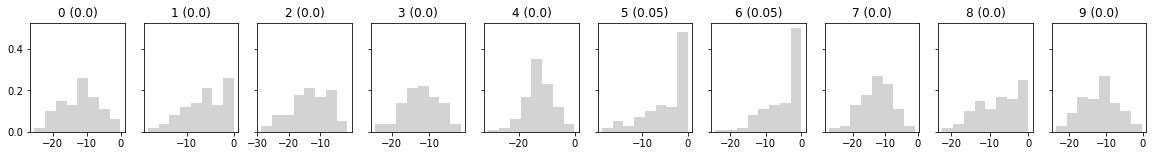

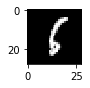

Undecided.
Real:  2


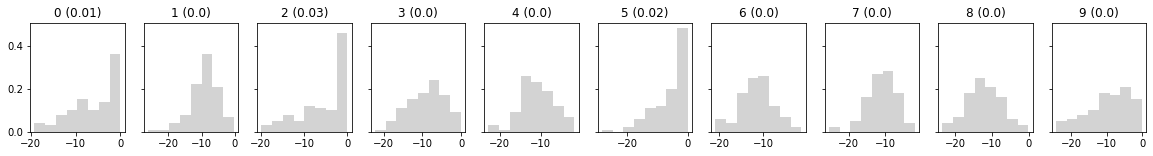

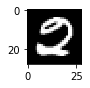

Undecided.
Real:  5


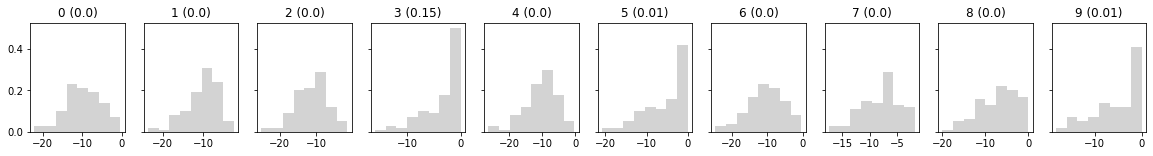

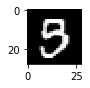

Undecided.
Real:  9


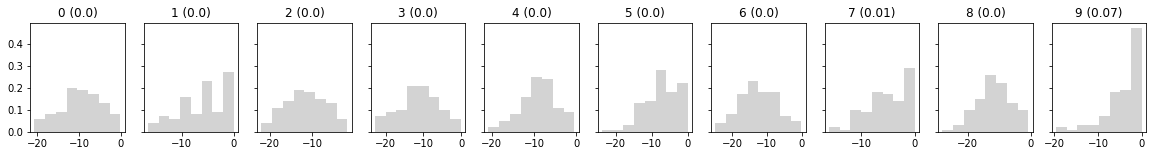

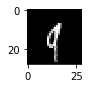

Undecided.
Real:  8


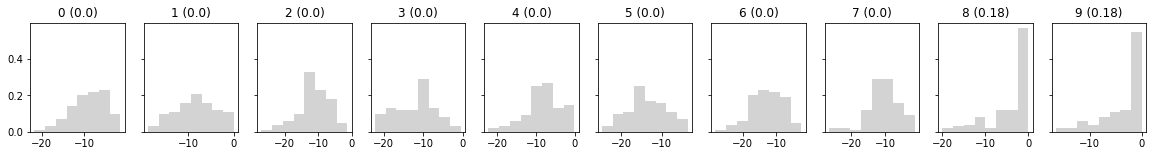

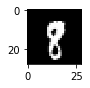

Undecided.
Real:  9


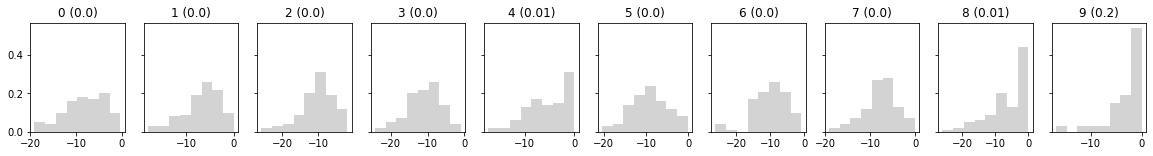

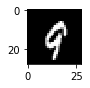

Undecided.
Real:  4


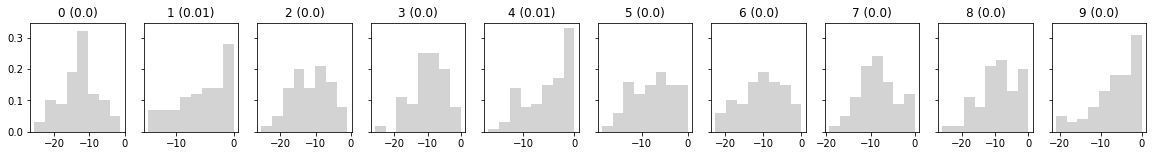

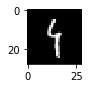

Undecided.
Real:  9


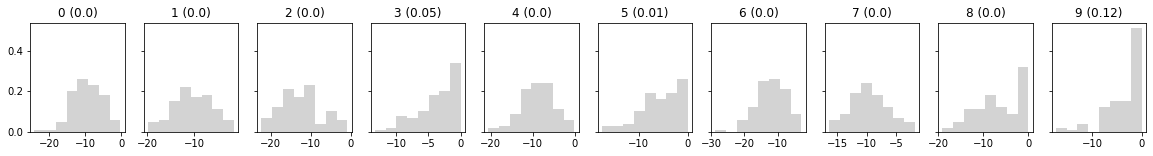

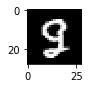

Undecided.
Real:  9


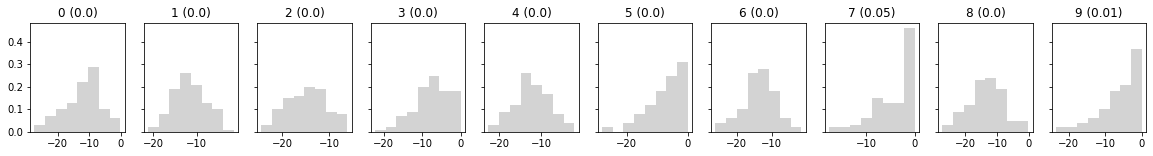

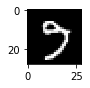

Undecided.
Real:  2


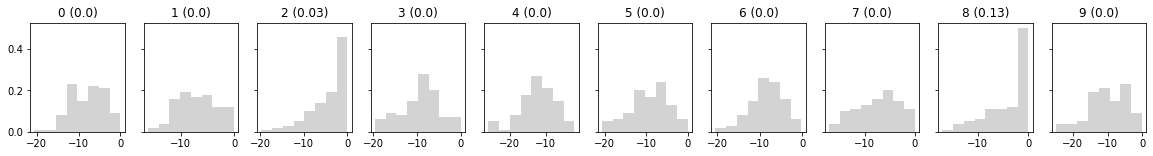

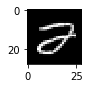

Undecided.
Real:  2


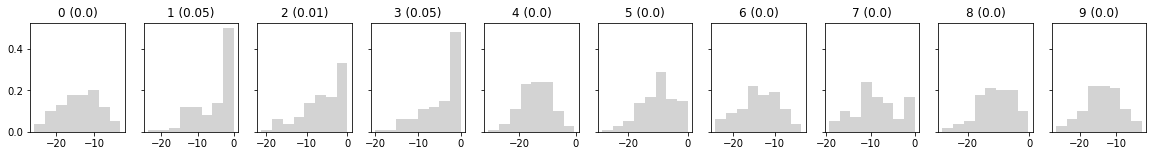

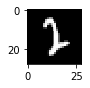

Undecided.
Real:  4


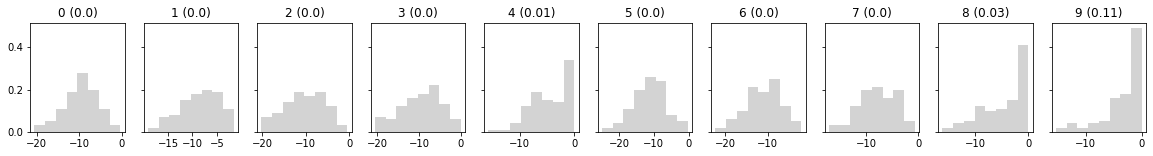

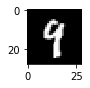

Undecided.
Real:  4


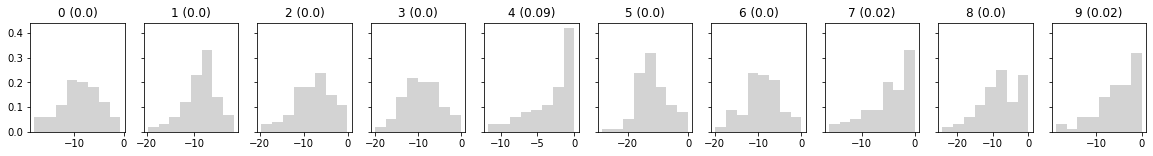

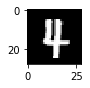

Undecided.
Real:  0


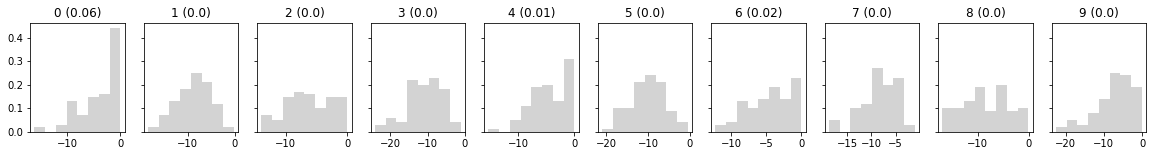

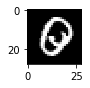

Undecided.
Real:  2


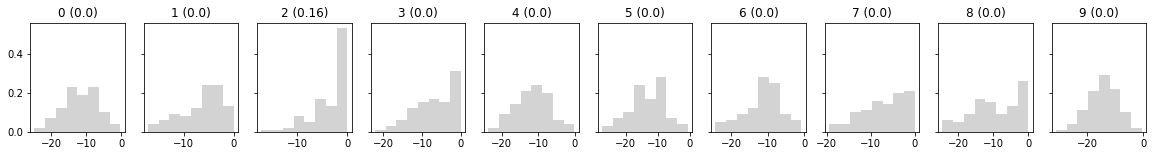

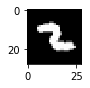

Undecided.
Real:  9


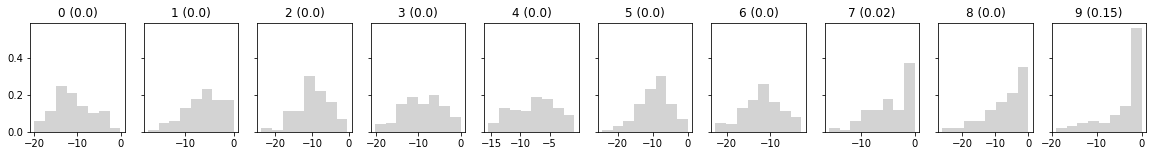

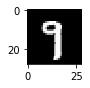

Undecided.
Real:  9


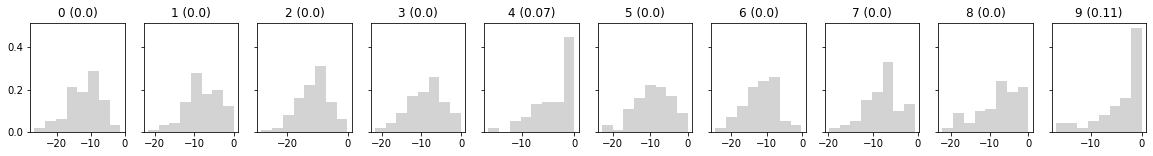

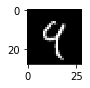

Undecided.
Real:  9


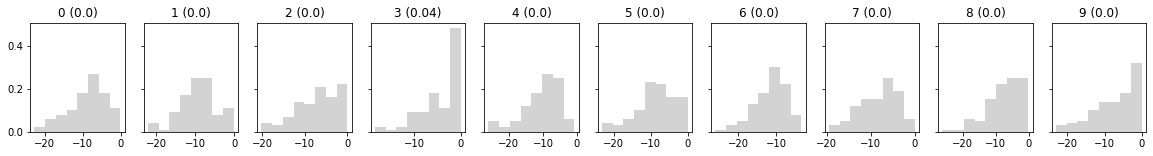

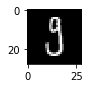

Undecided.
Real:  2


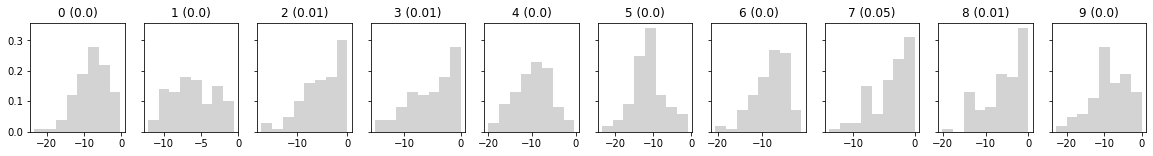

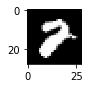

Undecided.
Real:  5


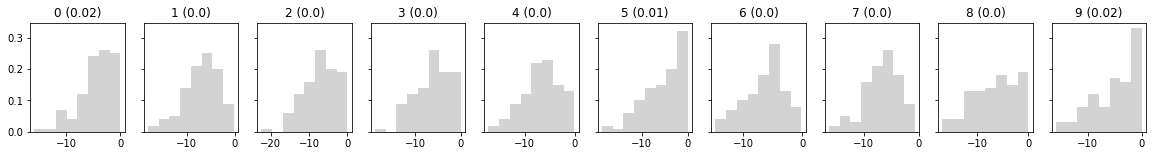

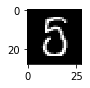

Undecided.
Real:  8


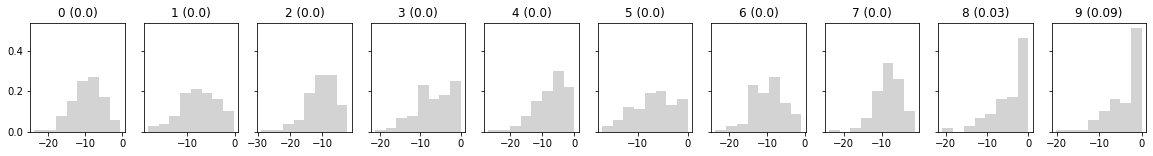

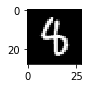

Undecided.
Real:  0


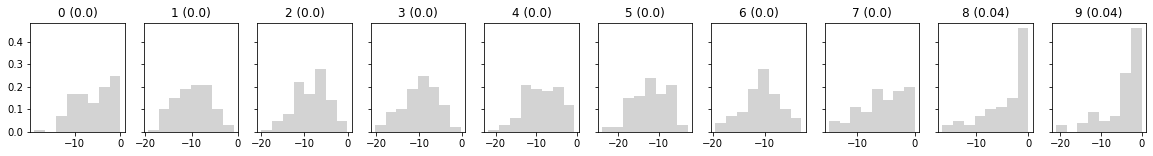

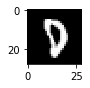

Undecided.
Real:  9


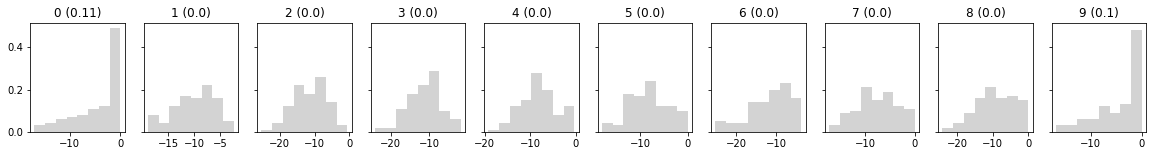

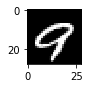

Undecided.
Real:  8


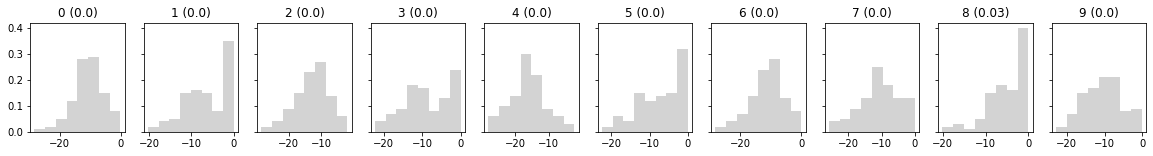

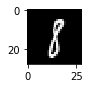

Undecided.
Real:  0


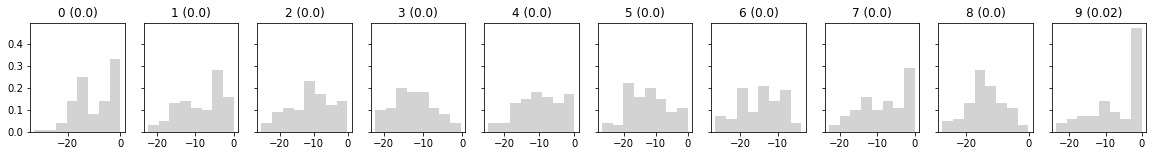

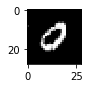

Undecided.
Real:  8


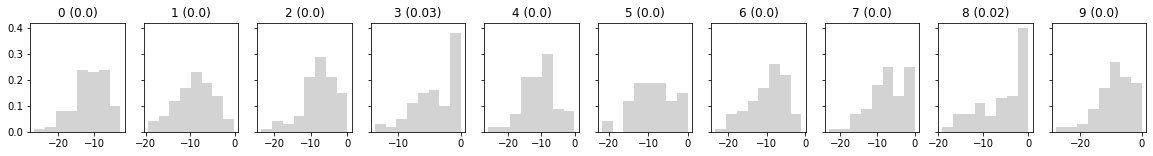

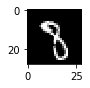

Undecided.
Real:  4


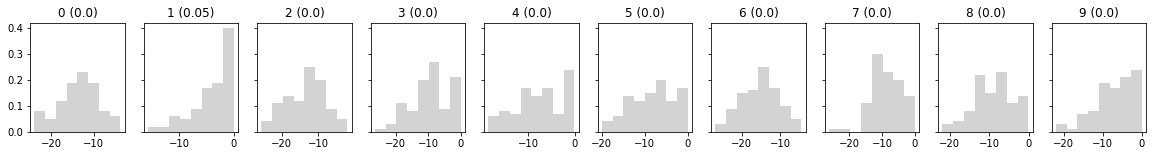

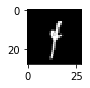

Undecided.
Real:  7


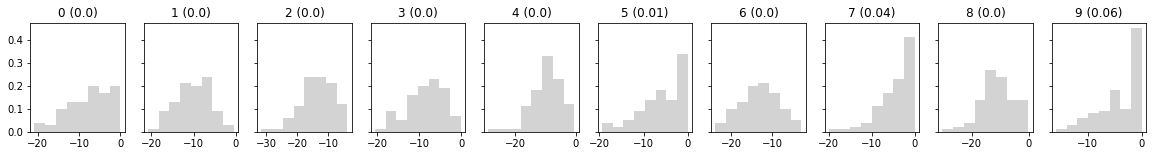

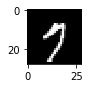

Undecided.
Real:  5


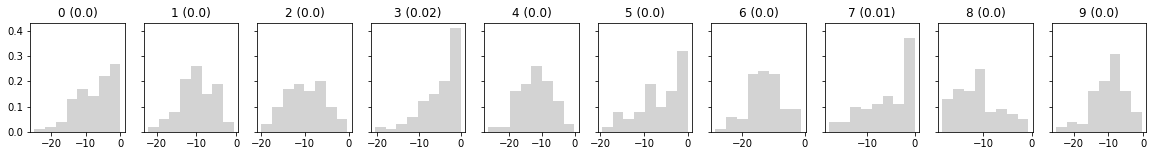

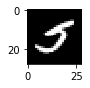

Undecided.
Real:  5


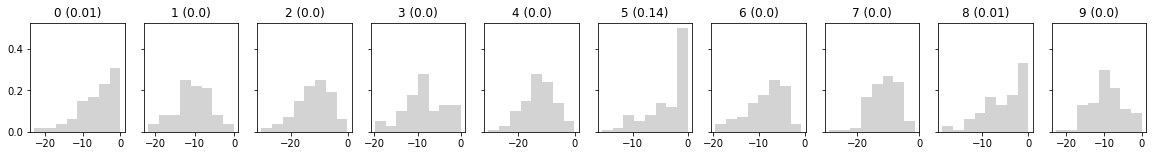

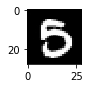

Undecided.
Real:  8


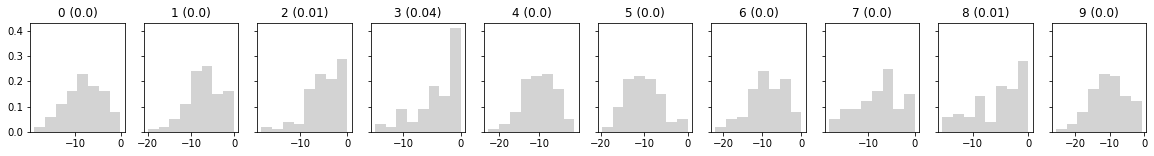

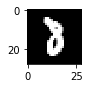

Undecided.
Real:  7


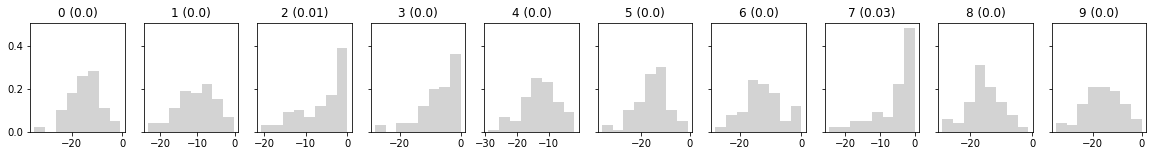

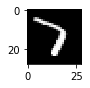

Undecided.
Real:  2


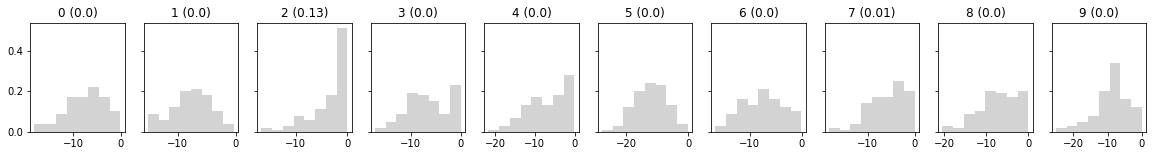

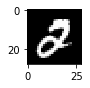

Undecided.
Real:  2


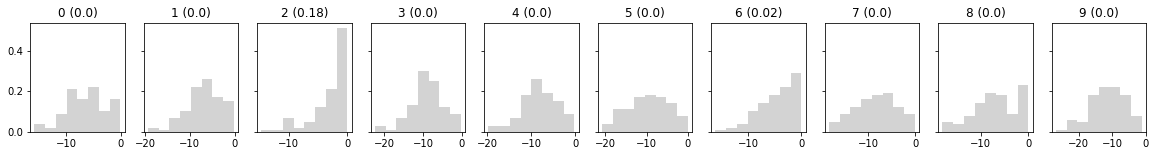

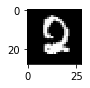

Undecided.
Real:  5


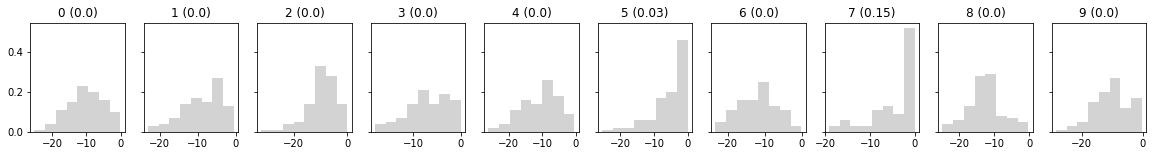

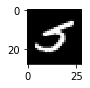

Undecided.
Real:  0


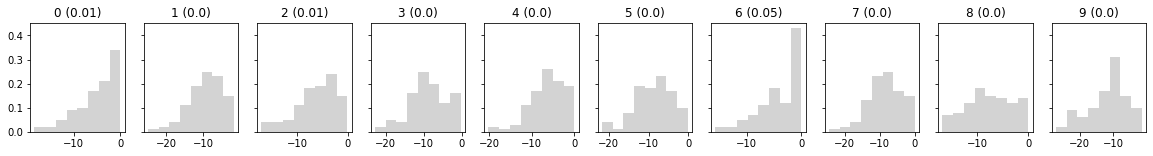

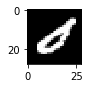

Undecided.
Real:  3


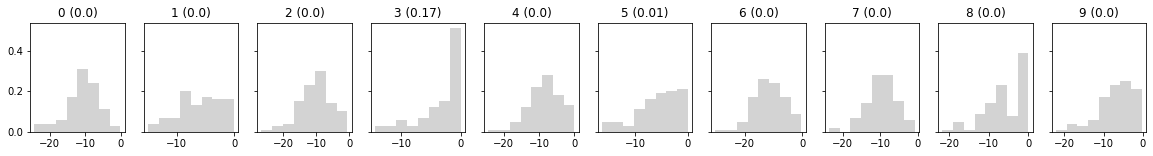

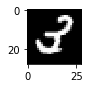

Undecided.
Real:  7


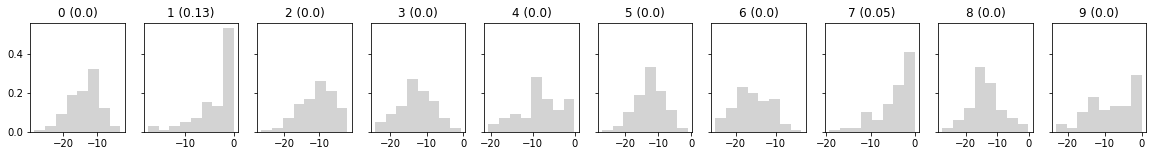

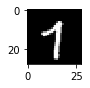

Undecided.
Real:  2


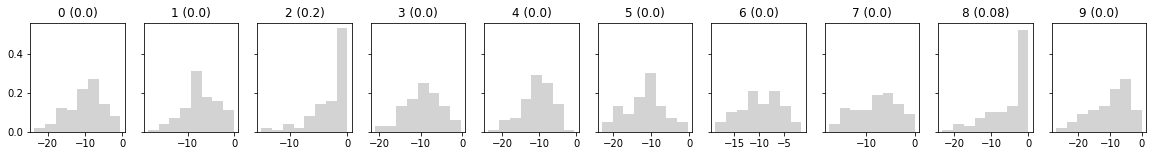

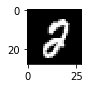

Undecided.
Real:  8


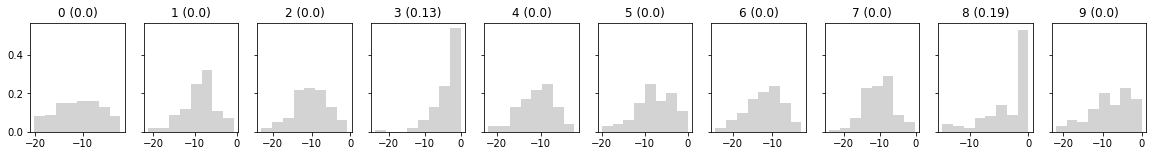

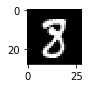

Undecided.
Real:  8


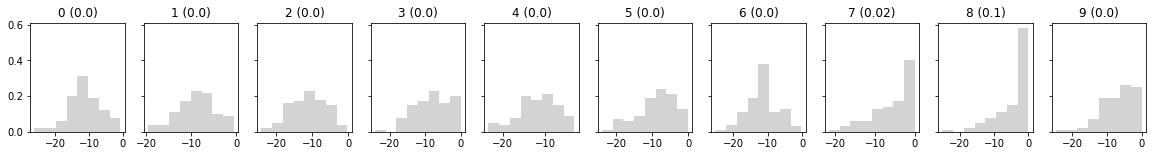

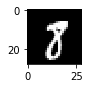

Undecided.
Real:  9


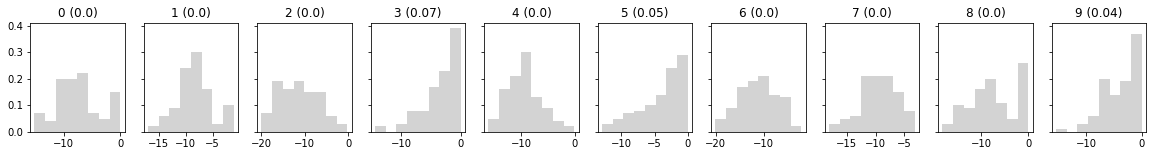

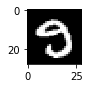

Undecided.
Real:  8


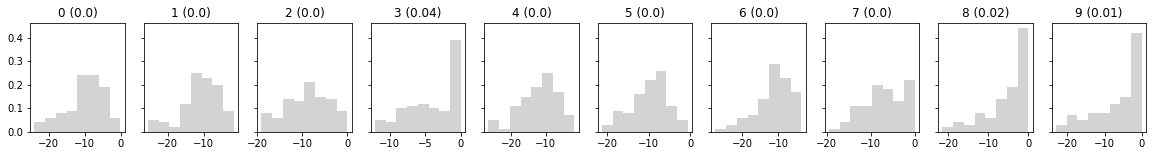

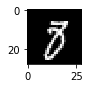

Undecided.
Real:  5


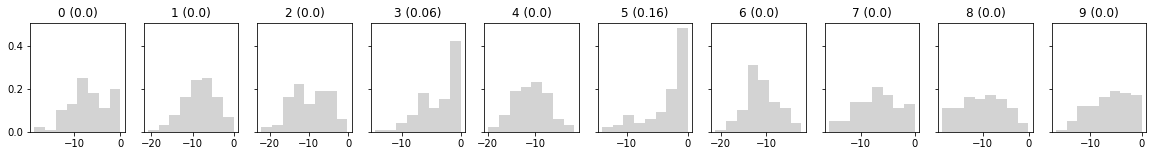

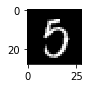

Undecided.
Real:  9


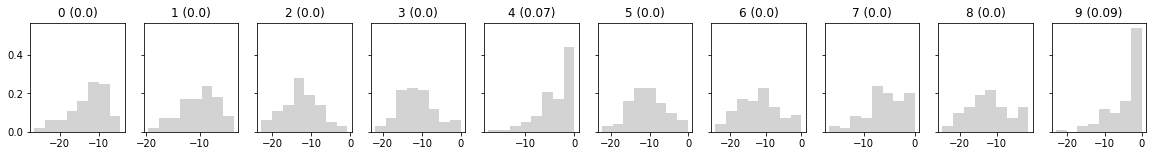

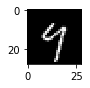

Undecided.
Real:  2


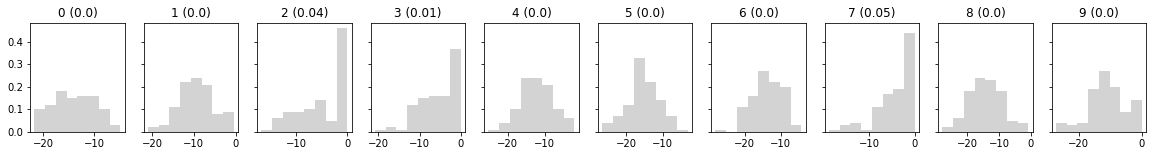

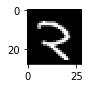

Undecided.
Real:  0


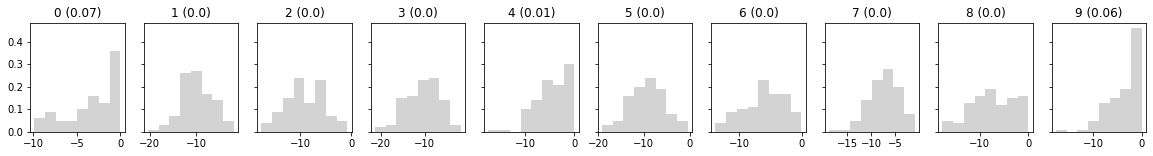

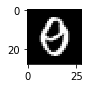

Undecided.
Real:  2


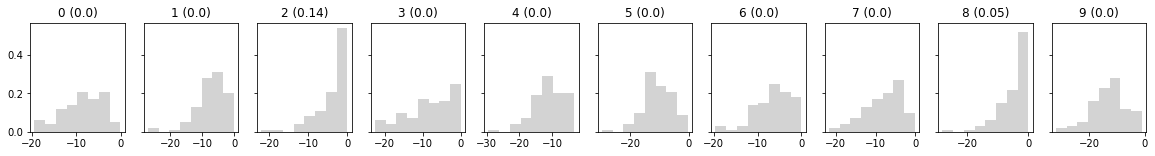

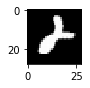

Undecided.
Real:  1


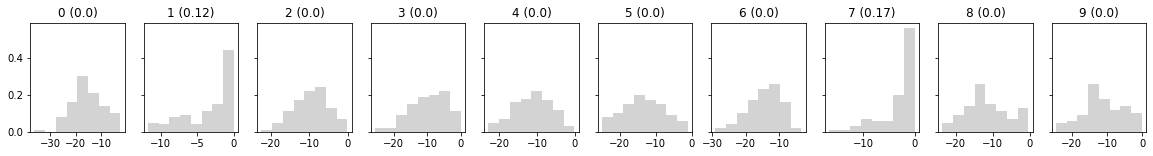

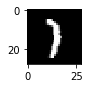

Undecided.
Real:  3


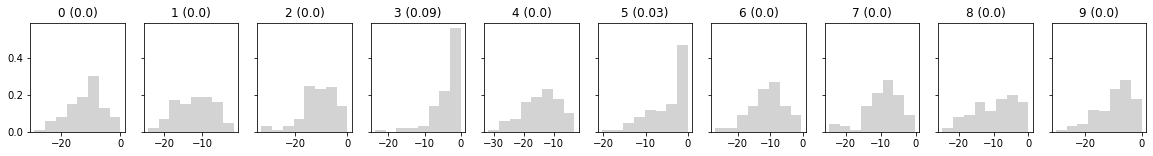

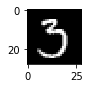

Undecided.
Real:  3


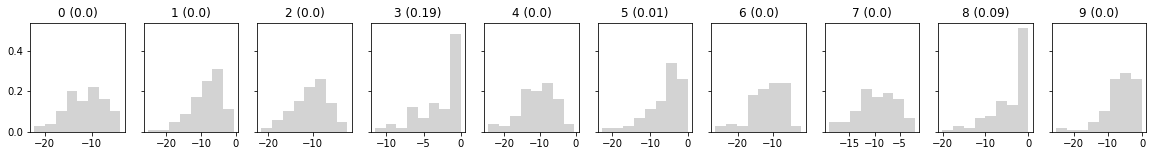

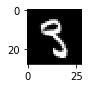

Undecided.
Real:  7


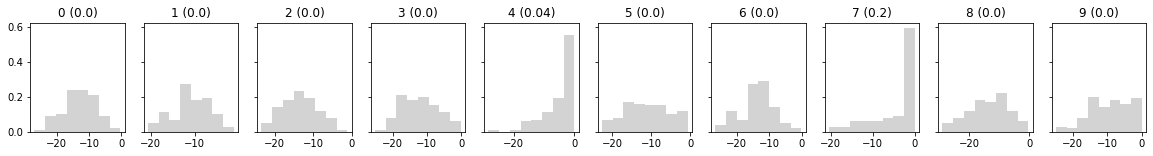

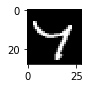

Undecided.
Real:  0


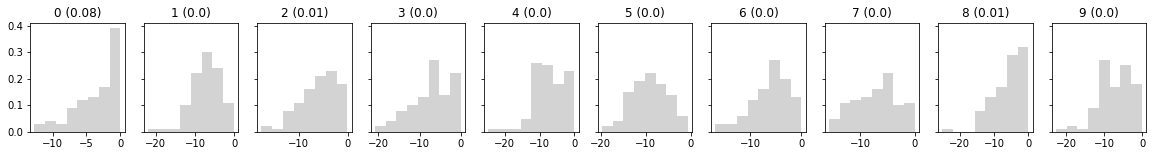

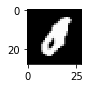

Undecided.
Real:  9


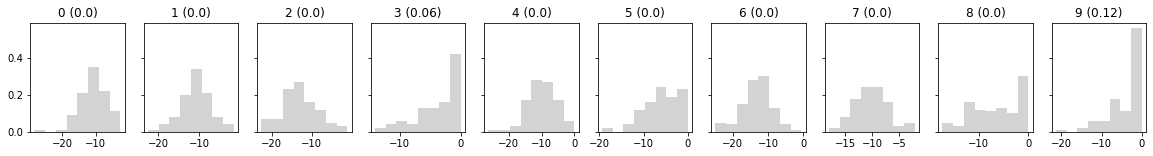

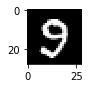

Undecided.
Real:  9


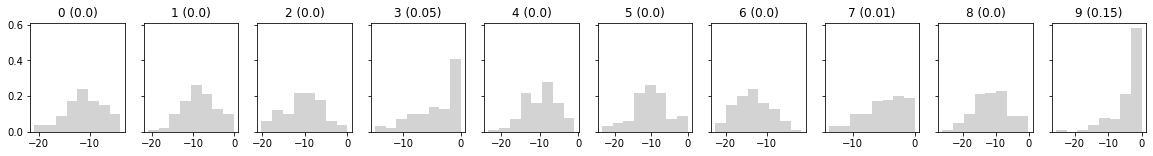

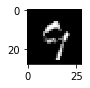

Undecided.
Real:  8


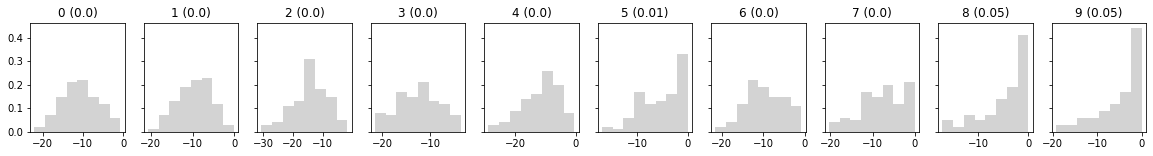

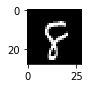

Undecided.
Real:  0


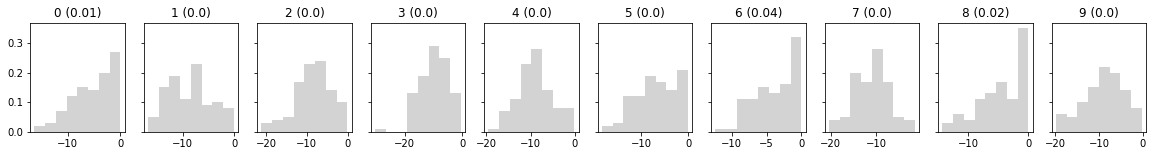

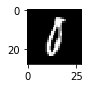

Undecided.
Real:  5


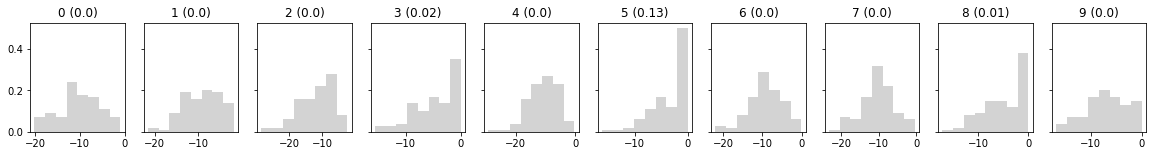

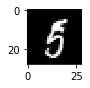

Undecided.
Real:  3


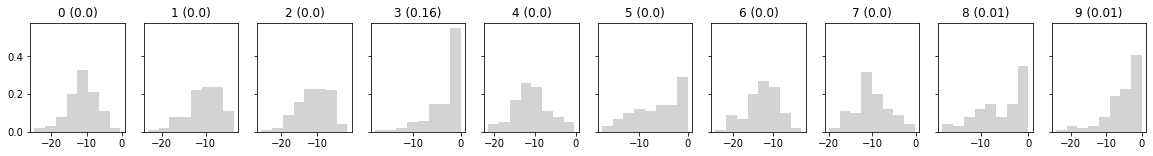

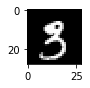

Undecided.
Real:  8


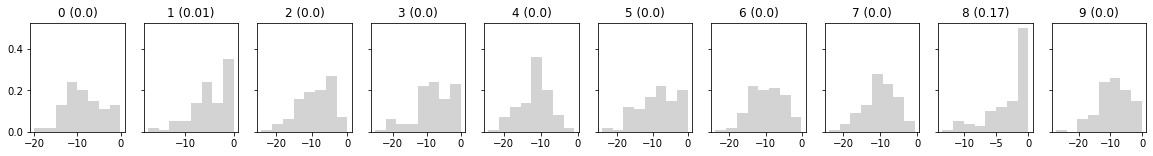

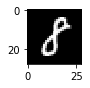

Undecided.
Real:  8


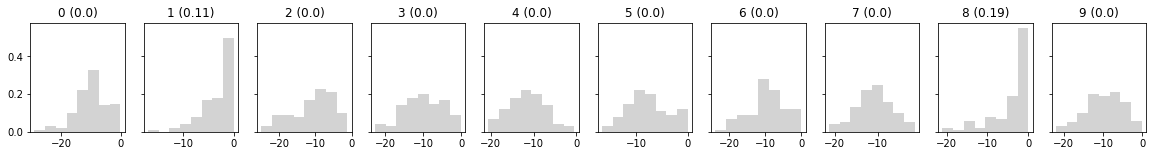

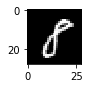

Undecided.
Real:  7


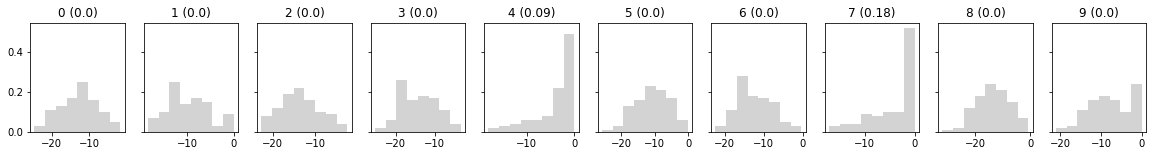

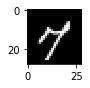

Undecided.
Real:  3


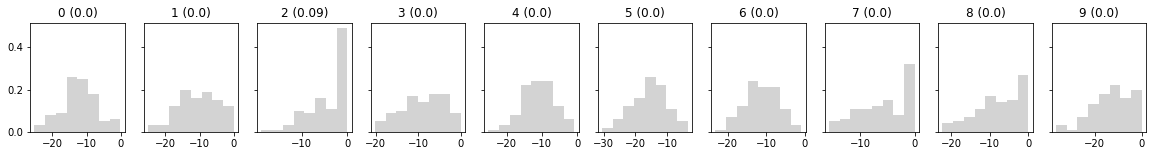

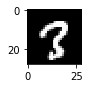

Undecided.
Real:  5


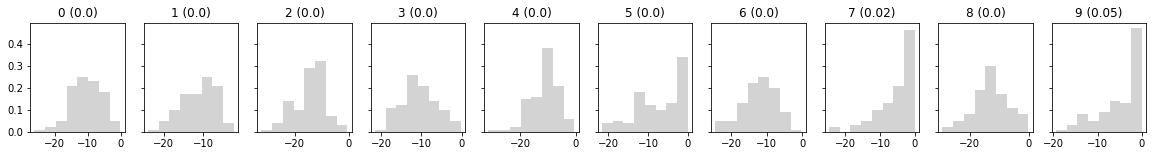

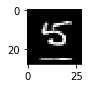

Undecided.
Real:  1


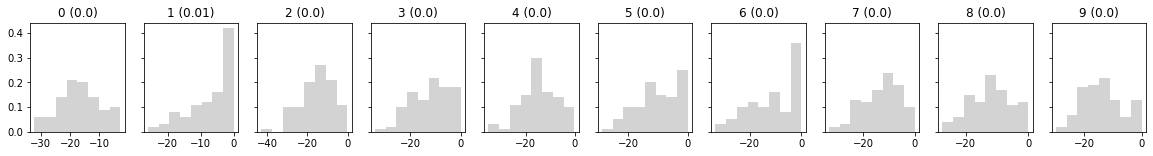

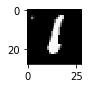

Undecided.
Real:  8


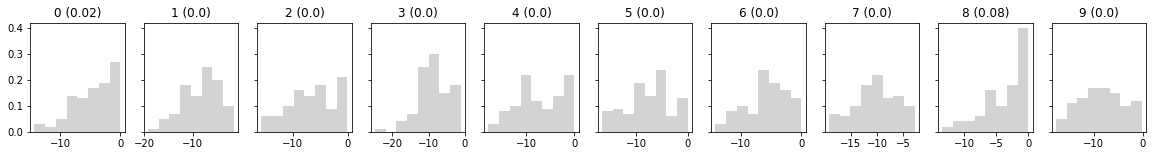

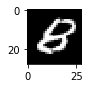

Undecided.
Real:  8


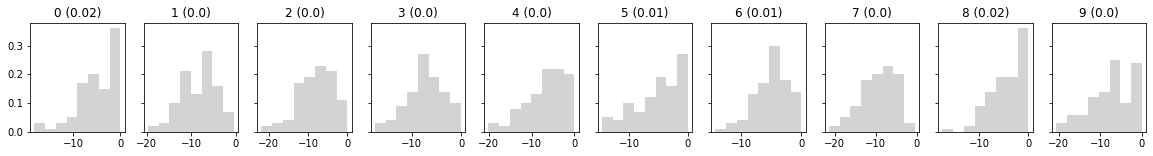

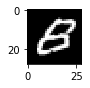

Undecided.
Real:  1


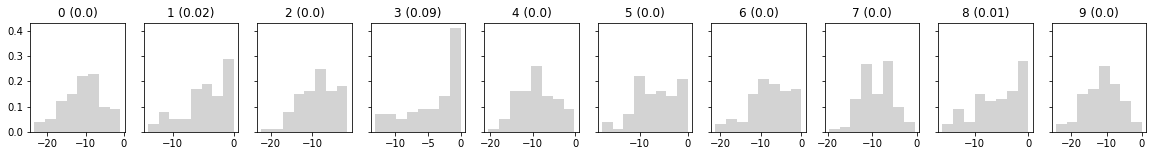

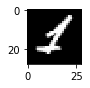

Undecided.
Real:  8


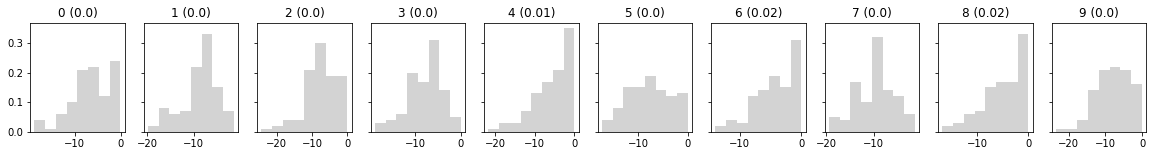

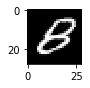

Undecided.
Real:  8


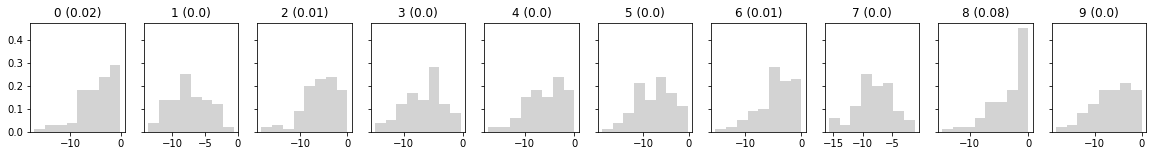

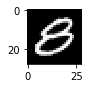

Undecided.
Real:  9


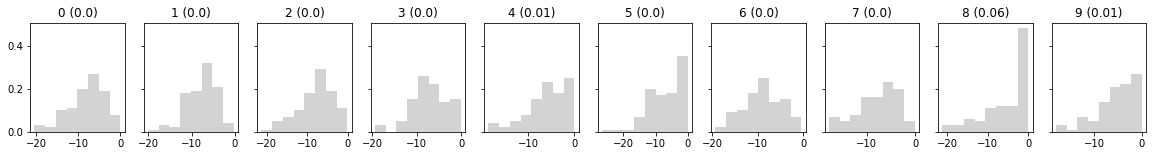

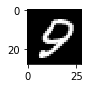

Undecided.
Real:  4


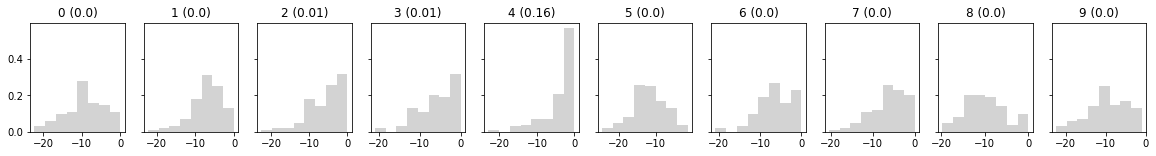

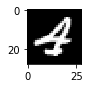

Undecided.
Real:  1


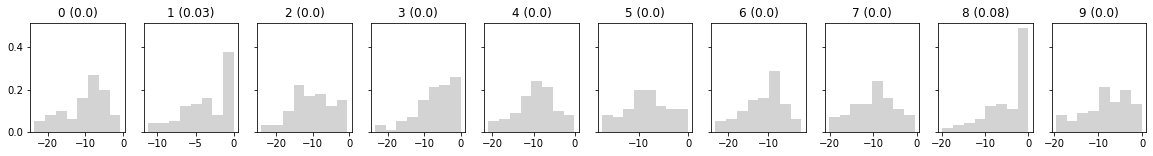

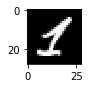

Undecided.
Real:  8


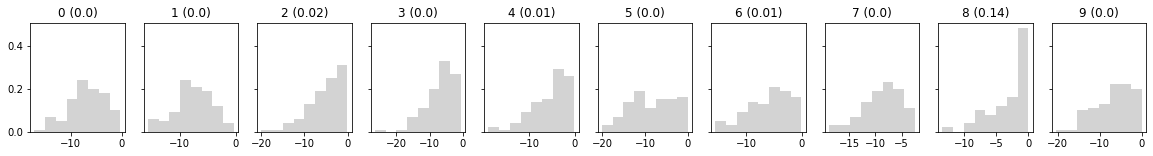

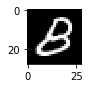

Undecided.
Real:  8


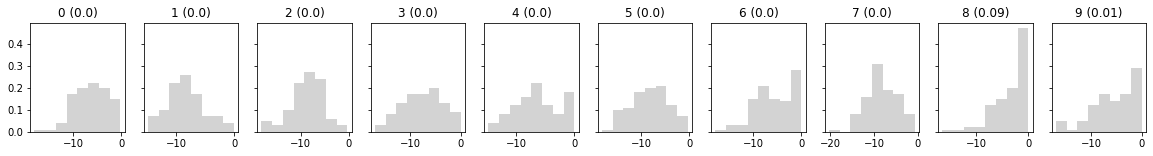

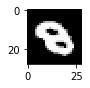

Undecided.
Real:  5


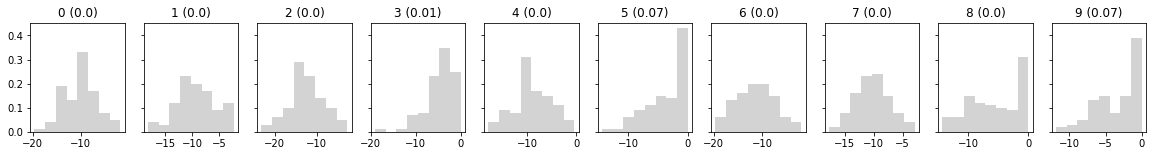

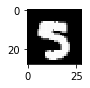

Undecided.
Real:  5


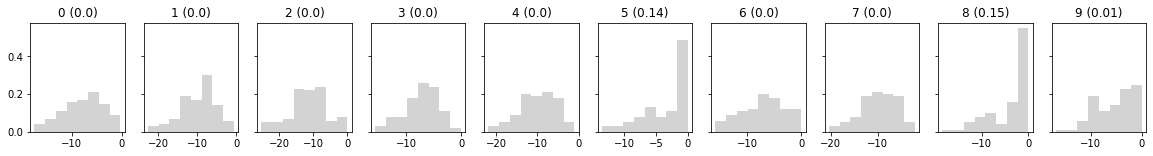

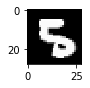

Undecided.
Real:  4


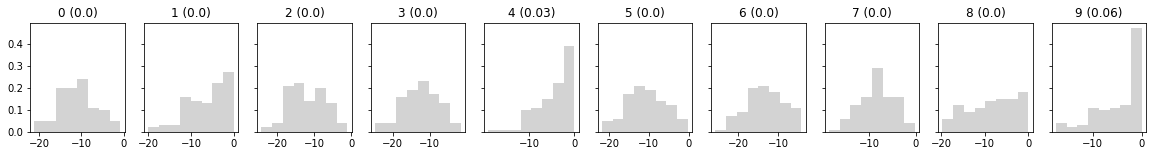

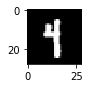

Undecided.
Real:  7


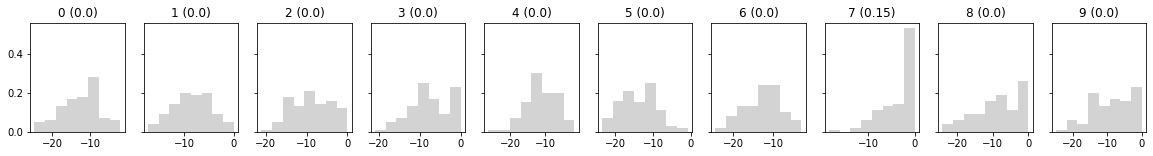

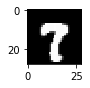

Undecided.
Real:  8


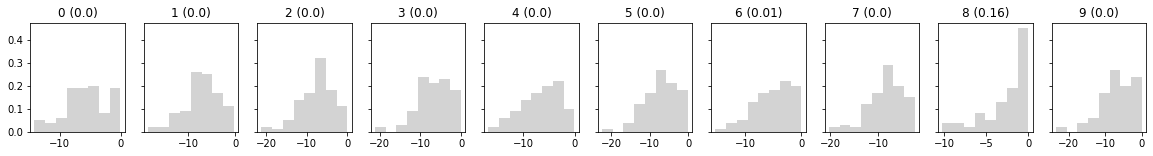

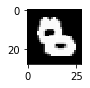

Undecided.
Real:  0


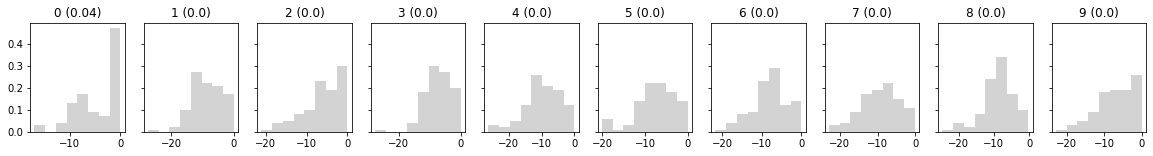

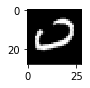

Undecided.
Real:  5


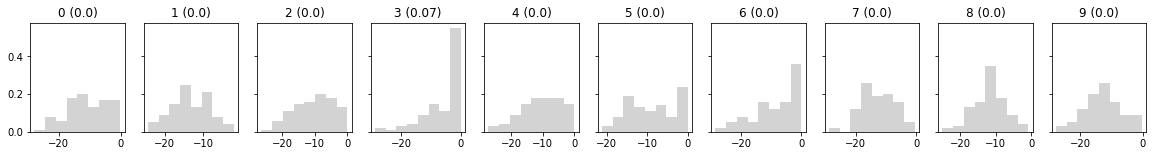

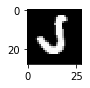

Undecided.
Real:  2


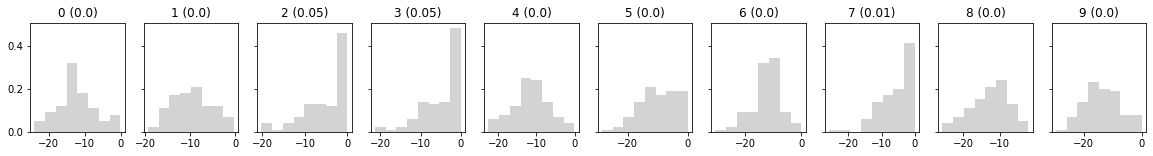

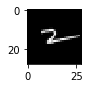

Undecided.
Real:  5


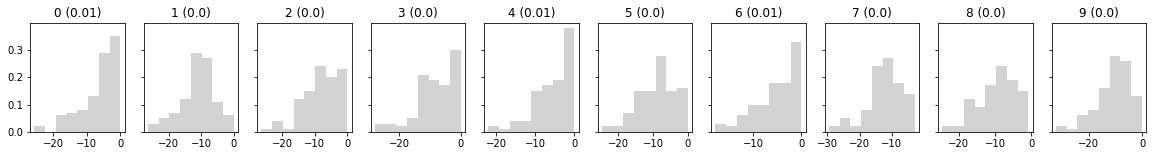

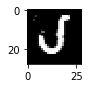

Undecided.
Real:  0


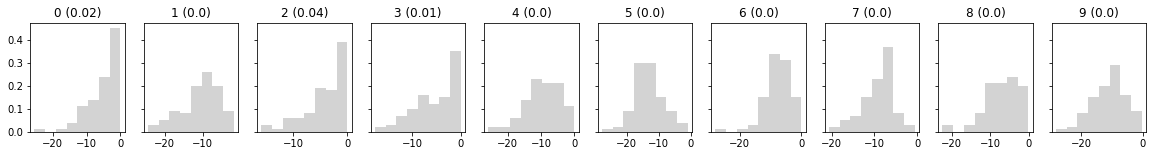

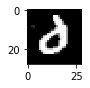

Undecided.
Real:  7


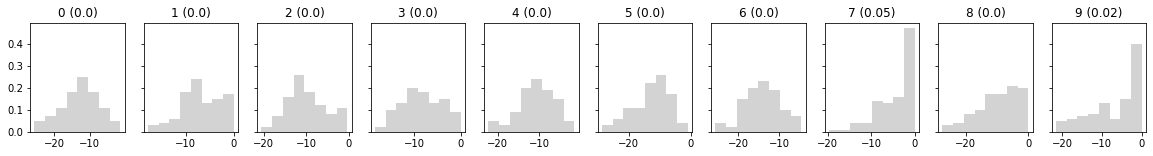

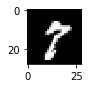

Undecided.
Summary
Total images:  10000
Predicted for:  9775
Accuracy when predicted:  0.9868030690537084


In [52]:
# show only rejected
_ = test_batch(images, labels, show_only_rejected=True)

In [53]:
# should match numbers above
_ = test_batch(images, labels, plot=False)

Summary
Total images:  10000
Predicted for:  9762
Accuracy when predicted:  0.9871952468756402


In [54]:
# generate random data
images_random = torch.rand(10000,28,28)
labels_random = torch.randint(99,100, (10000,))

Real:  99


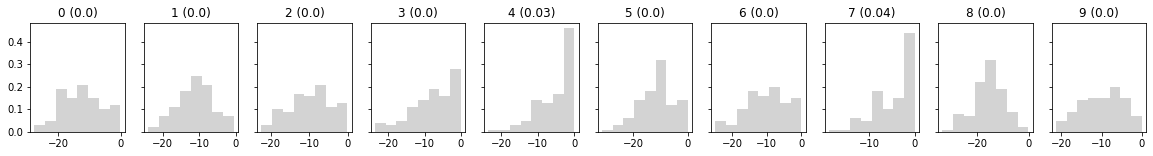

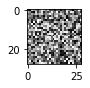

Undecided.
Real:  99


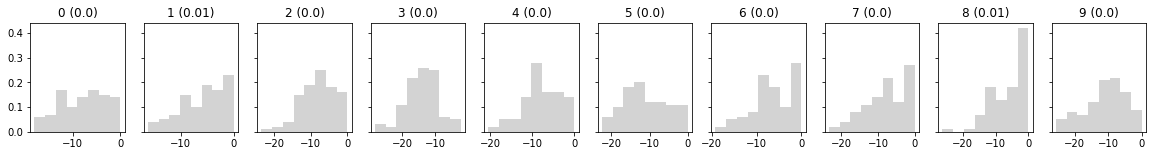

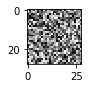

Undecided.
Real:  99


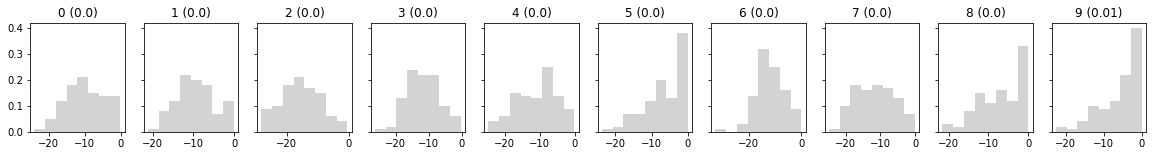

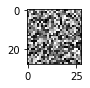

Undecided.
Real:  99


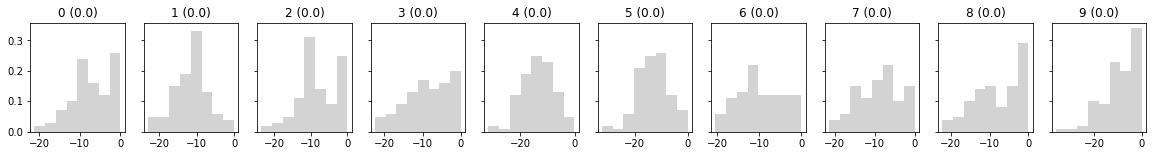

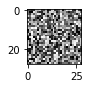

Undecided.
Real:  99


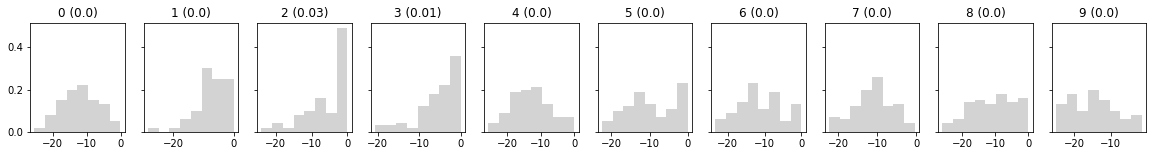

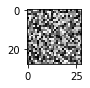

Undecided.
Summary
Total images:  5
Predicted for:  0
Accuracy when predicted:  -0.0


In [55]:
_ = test_batch(images_random[:5], labels_random[:5])

In [56]:
_,_,_,pred_max_values = test_batch(images_random, labels_random, plot=False)

Summary
Total images:  10000
Predicted for:  1649
Accuracy when predicted:  0.0


In [57]:
print(stats.describe(pred_max_values))
print("percentage of confident predictions (>=0.5):",float(len([x for x in pred_max_values if x>=0.5])/float(len(pred_max_values))))

DescribeResult(nobs=10000, minmax=(4.510821236181073e-05, 0.9999745190143585), mean=0.11622539797167937, variance=0.03963858775279533, skewness=2.6866200136380427, kurtosis=7.067944372401977)
percentage of confident predictions (>=0.5): 0.0639


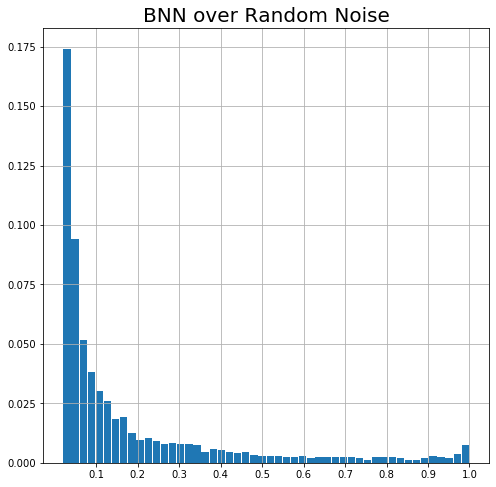

In [58]:
# histogram
weights = np.ones_like(pred_max_values)/len(pred_max_values)
plt.hist(pred_max_values, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title('BNN over Random Noise', fontsize=20)
plt.show()

In [59]:
rand_dataloader = fgnh.mnist_random_shuffled_dataloader(num_samples=10000,
                                                        batch_size=10000)

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/mnist_random_shuffled_dataloader.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data = torch.tensor(data[:num_samples])


In [60]:
dataiter = iter(rand_dataloader)
images_random_shuffled = dataiter.next()[0]

Real:  99


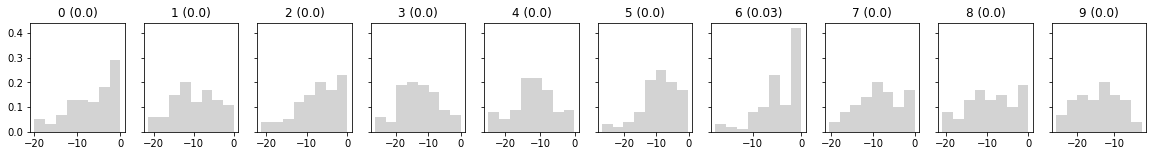

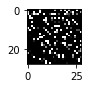

Undecided.
Real:  99


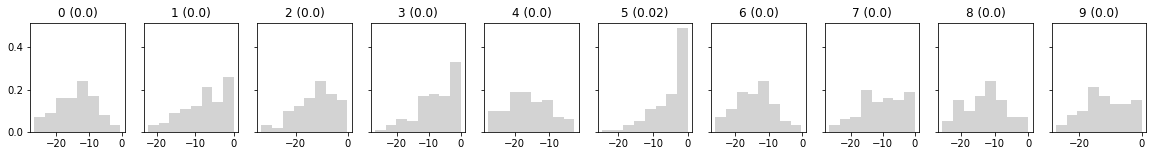

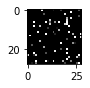

Undecided.
Real:  99


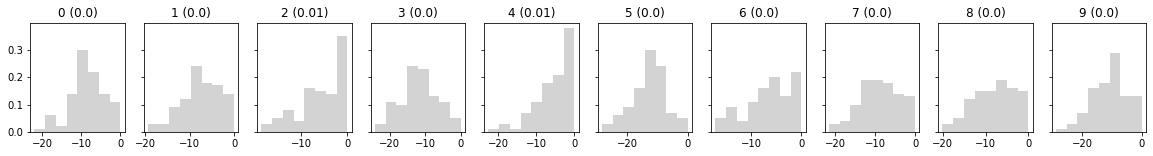

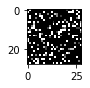

Undecided.
Real:  99


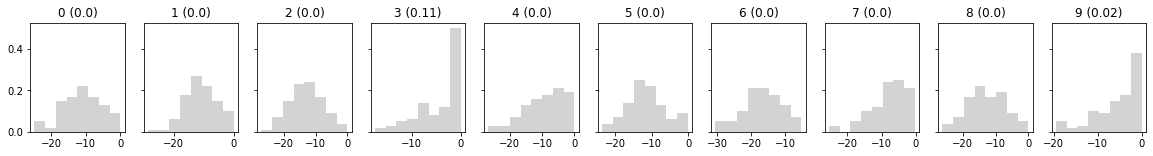

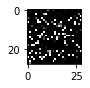

Undecided.
Real:  99


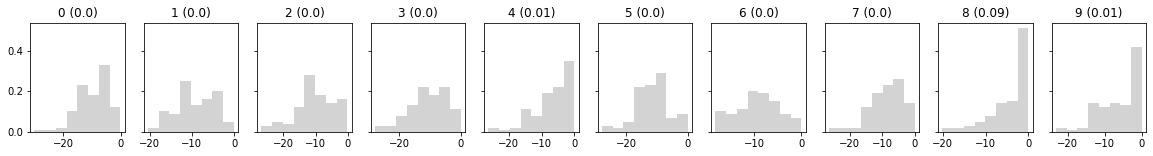

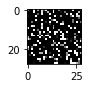

Undecided.
Summary
Total images:  5
Predicted for:  0
Accuracy when predicted:  -0.0


In [61]:
_ = test_batch(images_random_shuffled[:5], labels_random[:5])

In [62]:
_,_,_,pred_max_values = test_batch(images_random_shuffled, labels_random, plot=False)

Summary
Total images:  10000
Predicted for:  1468
Accuracy when predicted:  0.0


In [63]:
print(stats.describe(pred_max_values))
print("percentage of confident predictions (>=0.5):",float(len([x for x in pred_max_values if x>=0.5])/float(len(pred_max_values))))

DescribeResult(nobs=10000, minmax=(0.00013159595982870087, 0.9999658763408661), mean=0.10048987651405004, variance=0.031857434869282324, skewness=2.803190024602134, kurtosis=8.012569850432849)
percentage of confident predictions (>=0.5): 0.0536


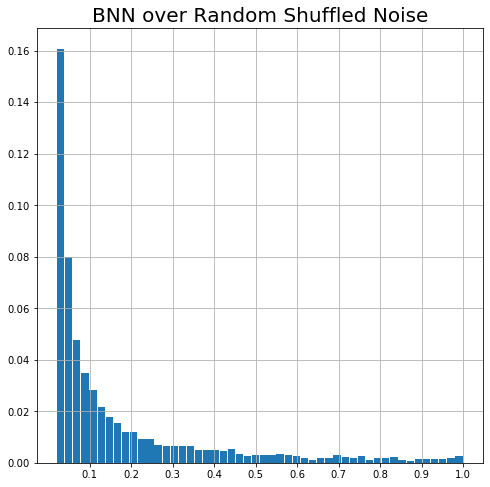

In [64]:
# histogram
weights = np.ones_like(pred_max_values)/len(pred_max_values)
plt.hist(pred_max_values, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title('BNN over Random Shuffled Noise', fontsize=20)
plt.show()

In [71]:
# torch.save({"net": net.state_dict(), "guide" : guide},
#            "../Experiments/sample_models/sample_bayesian_from_pretrained_classic_2.pt")
# pyro.get_param_store().save("../Experiments/sample_models/sample_bayesian_params_from_pretrained_classic_2.pt")

In [66]:
# # save model
# import pickle

# with open('../Experiments/sample_models/sample_bayesian_net_model.pickle', 'wb') as f:
#     pickle.dump(model, f)

In [67]:

# with open('../Experiments/sample_models/sample_bayesian_net_guide.pickle', 'wb') as f:
#     pickle.dump(model, f)

In [68]:

# with open('../Experiments/sample_models/sample_bayesian_net.pickle', 'wb') as f:
#     pickle.dump(net, f)

In [69]:
### 3 load some adversarial examples

In [70]:
#